In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.io as io
import random
from torch_geometric.data import Data

In [2]:
os.chdir('/public/home/jijh/diffusion_project/ADiffusion')

In [3]:
import importlib
import src.preprocessing.data_process
importlib.reload(src.preprocessing.data_process)

<module 'src.preprocessing.data_process' from '/public/home/jijh/diffusion_project/ADiffusion/src/preprocessing/data_process.py'>

In [4]:
from src.preprocessing.data_process import extract_patches, create_graph_data_dict, construct_affinity_matrix

In [5]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

# Data Preprocessing

In [141]:
from tqdm import tqdm

file_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

# Preprocess each AnnData object
for key in tqdm(adatas.keys(), desc="Preprocessing datasets"):
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    adatas[key].layers["raw"] = adatas[key].X.copy()  # Store the raw data in the "raw" layer
    sc.pp.scale(adatas[key], max_value=10)  # Scale the data to have a maximum value of 10
    sc.tl.pca(adatas[key], svd_solver="arpack")  # Perform PCA

Preprocessing datasets: 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


In [142]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()

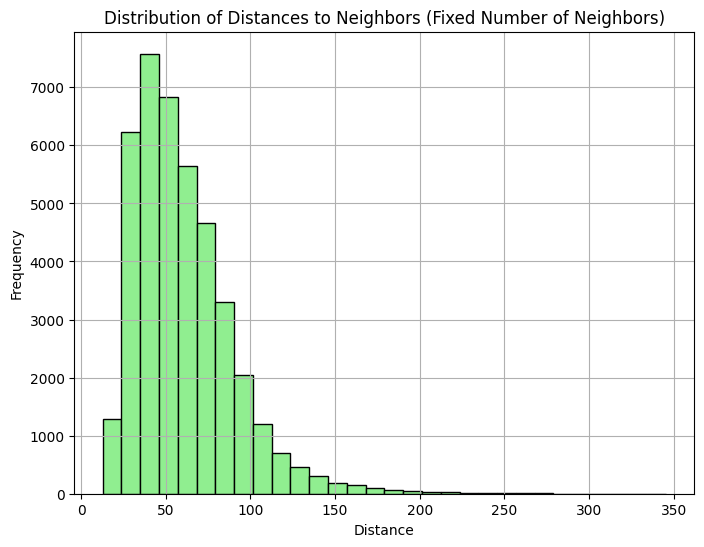

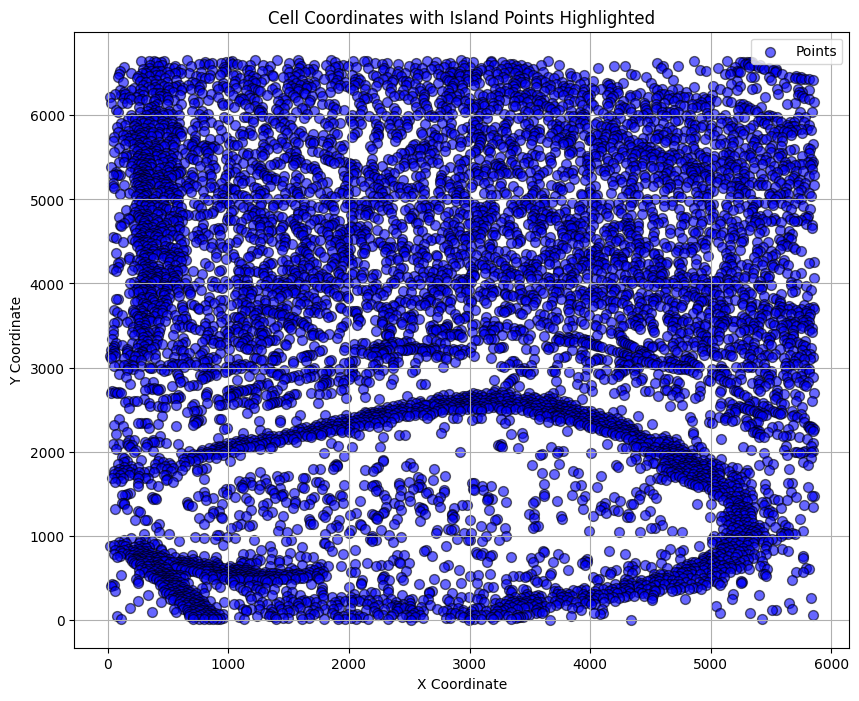

Number of island points: 0


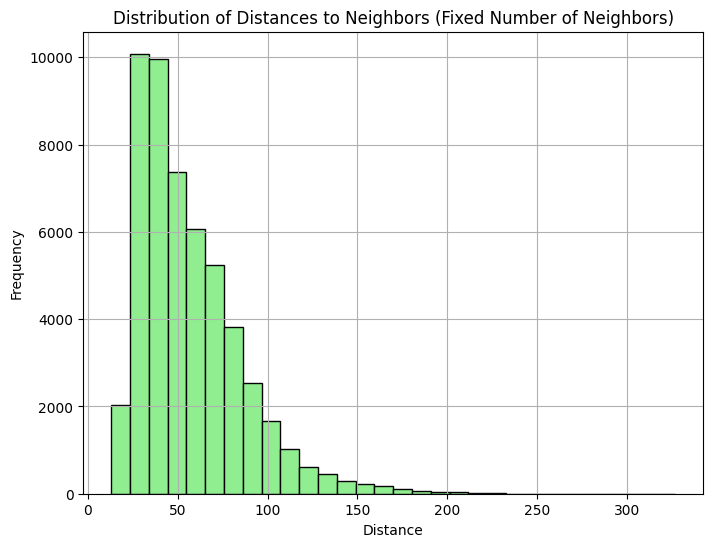

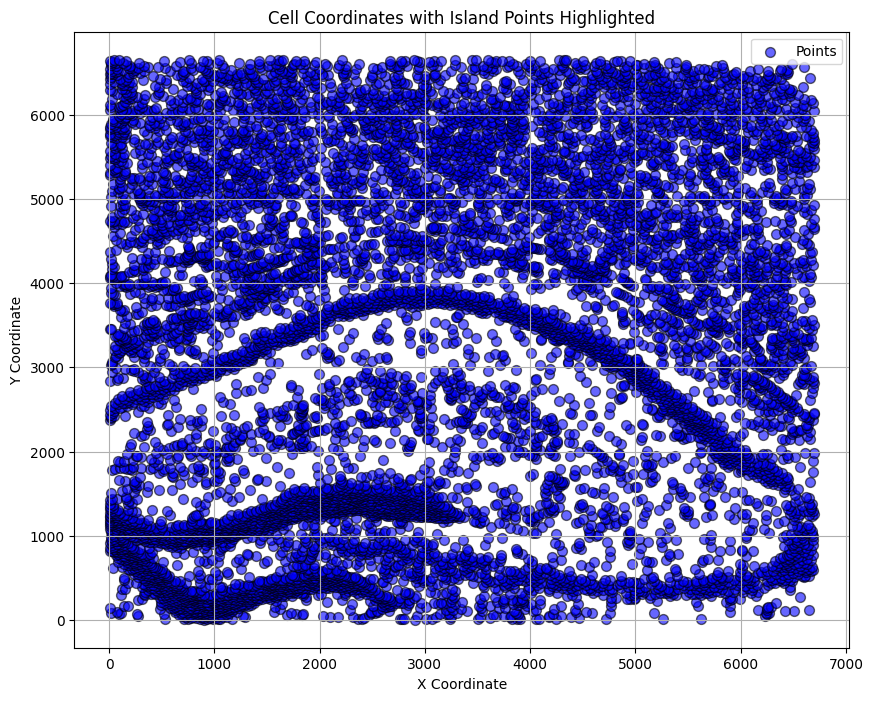

Number of island points: 0


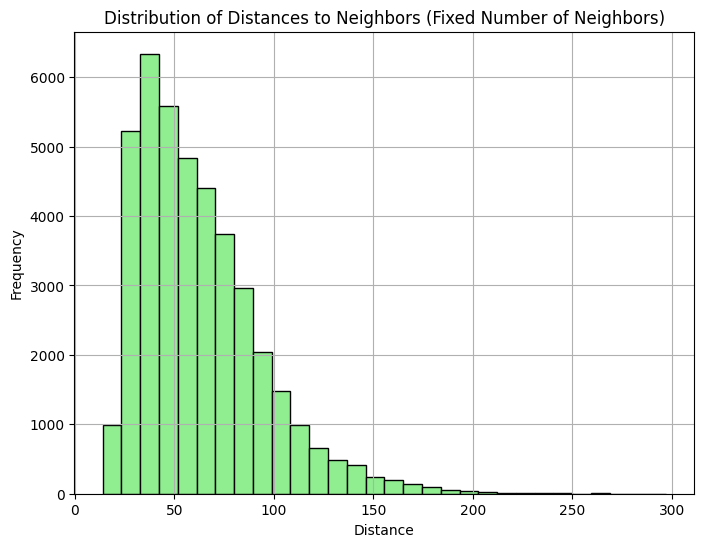

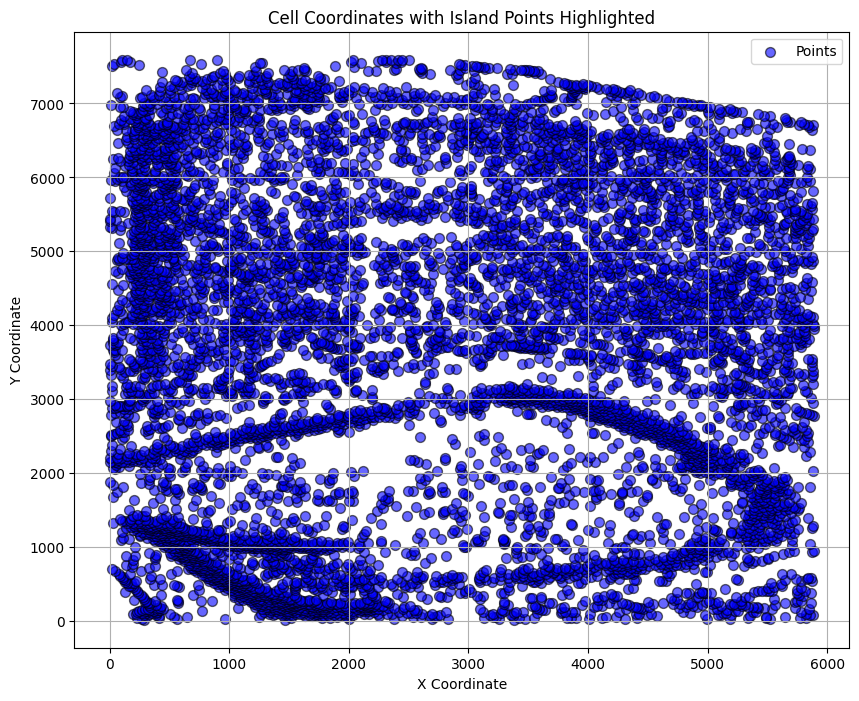

Number of island points: 0


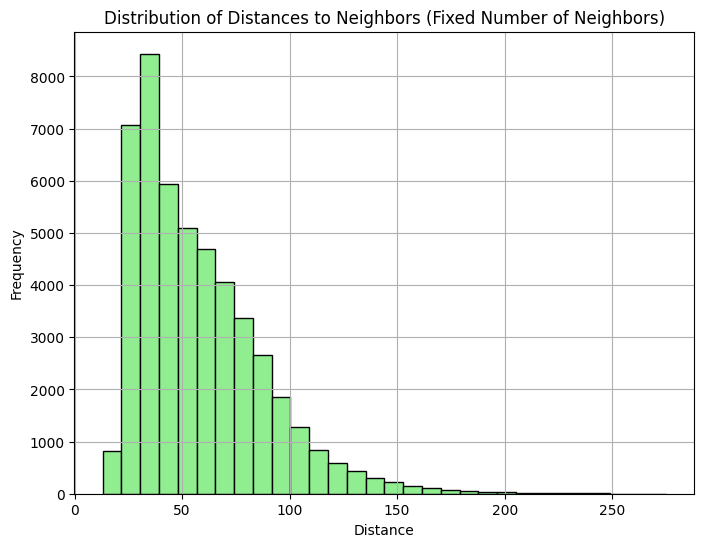

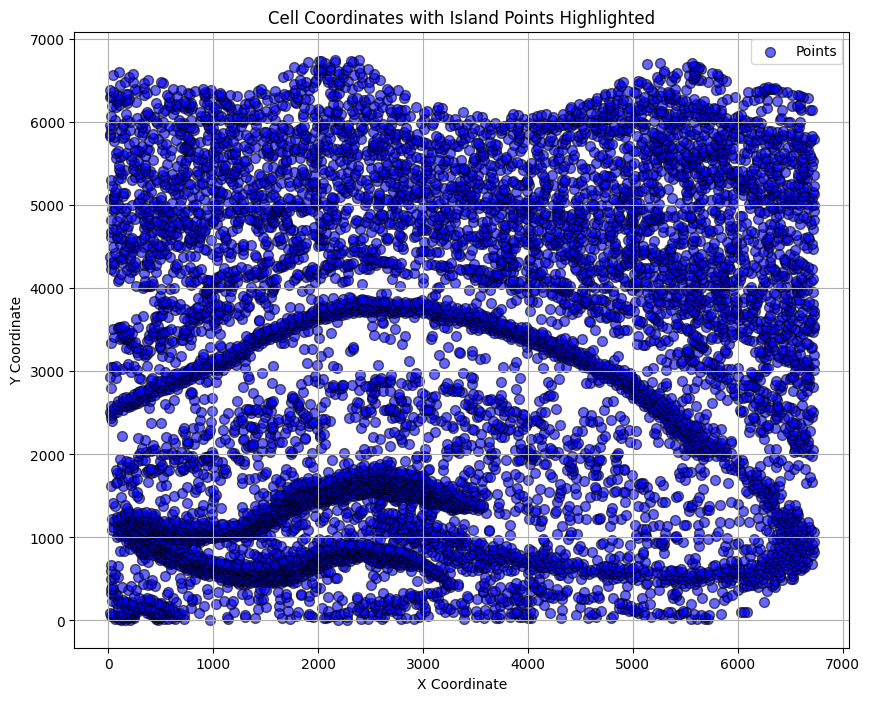

Number of island points: 0


In [144]:
neighbors = {}
for key in cell_coords.keys():
    neighbors[key] = construct_affinity_matrix(cell_coords[key], mode='number', cutoff=10)

In [145]:

# Load the plaque dataset
img_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/protein_seg_result/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)



In [146]:
# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0


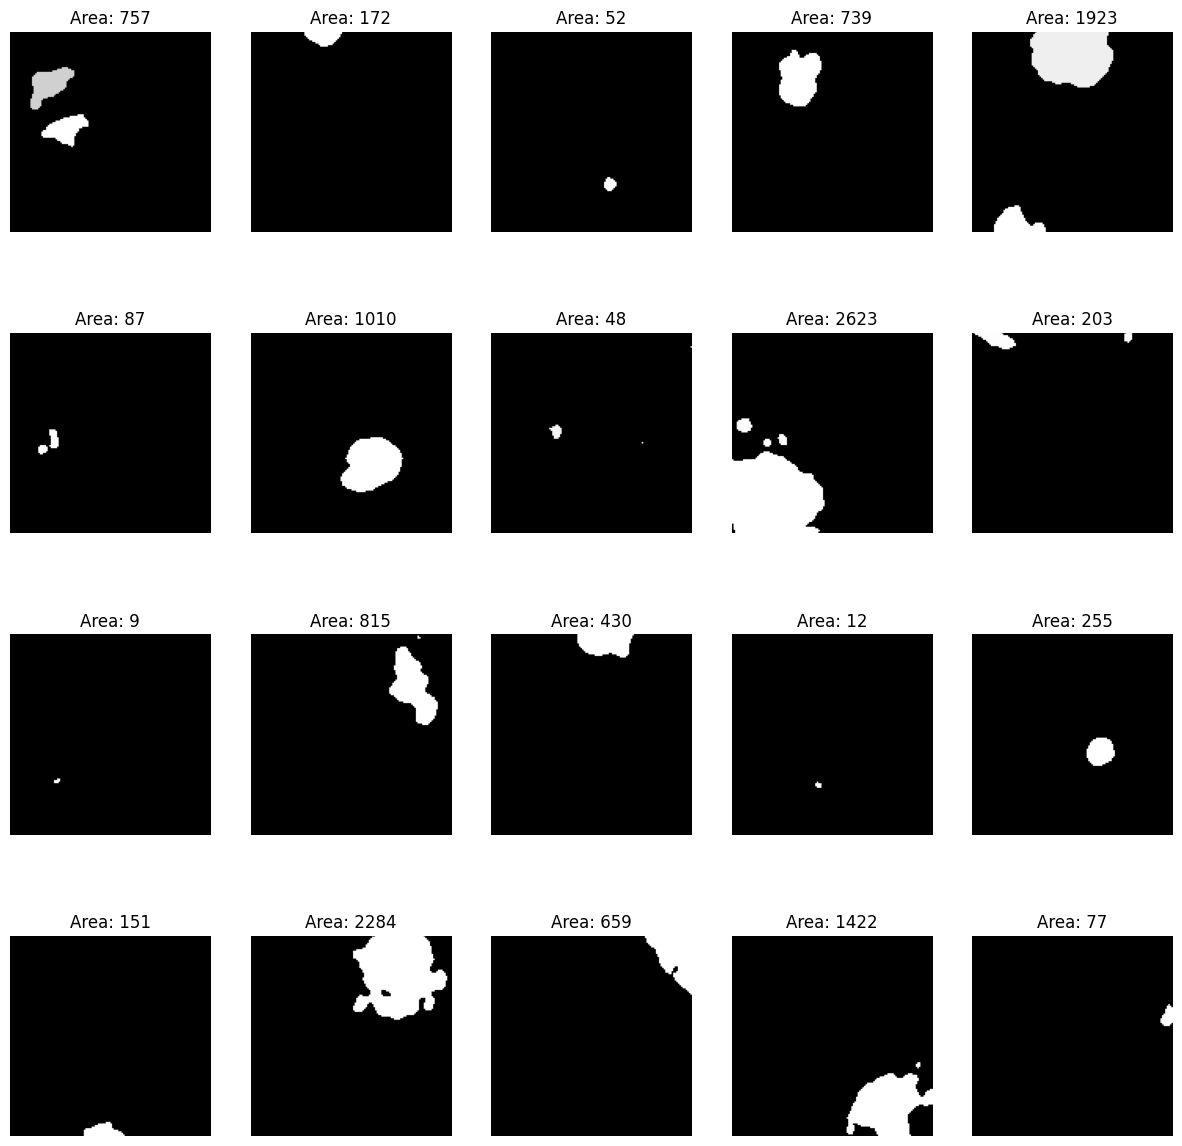

In [147]:
# Choose 5 patches with non-zero area for each image and plot them
import matplotlib.pyplot as plt

# Set the number of patches to plot
n_patches = 5

# Plot the patches
fig, axes = plt.subplots(nrows=len(areas), ncols=n_patches, figsize=(15, 15))
axes = np.atleast_2d(axes)  # Ensure axes is 2D for consistent indexing

for i, key in enumerate(areas.keys()):
    non_zero_indices = np.where(np.array(areas[key]) > 0)[0]
    chosen_indices = random.sample(list(non_zero_indices), n_patches)
    for j, idx in enumerate(chosen_indices):
        axes[i, j].imshow(patches[key][idx], cmap="gray")
        axes[i, j].set_title(f"Area: {areas[key][idx]}")
        axes[i, j].axis("off")
    axes[i, 0].set_ylabel(key, rotation=0, size="large", labelpad=50)

In [148]:
# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas, areas, neighbors, cell_coords, embeddings=["X"])


# Efficiently convert patches to tensors in batch
for key, graph in tqdm(graph_data_dict.items(), desc="Adding patches to graph data"):
    # Ensure patches[key] is a list of NumPy arrays
    patches_tensor = torch.tensor(np.array(patches[key]), dtype=torch.float)  # Convert patches to a single tensor efficiently
    graph.patches = patches_tensor

Adding patches to graph data: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


In [149]:
# Normalize the edge_attr
for key, graph in tqdm(graph_data_dict.items(), desc="Normalizing edge_attr"):
    graph.edge_attr = graph.edge_attr / graph.edge_attr.max()

Normalizing edge_attr: 100%|██████████| 4/4 [00:00<00:00, 38.60it/s]


In [150]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 40930], edge_attr=[40930, 1], y=[8186, 1], pos=[8186, 2], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 51860], edge_attr=[51860, 1], y=[10372, 1], pos=[10372, 2], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 41010], edge_attr=[41010, 1], y=[8202, 1], pos=[8202, 2], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 48170], edge_attr=[48170, 1], y=[9634, 1], pos=[9634, 2], patches=[9634, 128, 128, 1])}

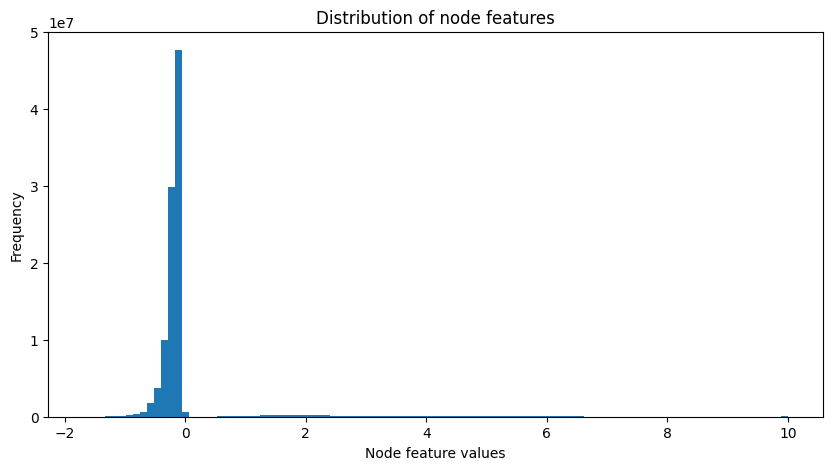

In [152]:
# Visualize the values distribution of the node features
node_features = torch.cat([graph.x for graph in graph_data_dict.values()], dim=0)
plt.figure(figsize=(10, 5))
plt.hist(node_features.numpy().flatten(), bins=100)
plt.xlabel("Node feature values")
plt.ylabel("Frequency")
plt.title("Distribution of node features")
plt.show()


# Prediction & Represenation of the graph

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool


In [88]:
test_replicate_name = '13months-disease-replicate_2'


In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_val_datalist = []
test_data = None

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    data.y = (data.y > 0).float()  # Binarize

    if name == test_replicate_name:
        # This entire graph is our final test set.
        test_data = data
    else:
        # We do random node-level splits for training & validation
        num_nodes = data.x.size(0)
        perm = torch.randperm(num_nodes)

        train_cutoff = int(0.8 * num_nodes)
        val_cutoff   = int(0.9 * num_nodes)

        data.train_idx = perm[:train_cutoff]
        data.val_idx   = perm[train_cutoff:val_cutoff]
        data.mini_test_idx = perm[val_cutoff:]  # optional mini-test

        train_val_datalist.append(data)

# Move test_data to device
test_data = test_data.to(device)


In [100]:
class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, residual=True, dropout=0.5):
        super().__init__()
        
        # -- GCN Layer --
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        # -- GraphSAGE Layer --
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        # Optional skip connection parameter
        self.residual = residual

        # -- Final MLP block --
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, out_channels)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None, edge_weight=None):
        # --- First layer: GCN ---
        out1 = self.conv1(x, edge_index, edge_weight)
        out1 = self.bn1(out1)
        out1 = F.relu(out1)
        out1 = self.dropout(out1)
        
        # --- Second layer: GraphSAGE ---
        out2 = self.conv2(out1, edge_index)
        out2 = self.bn2(out2)
        out2 = F.relu(out2)
        out2 = self.dropout(out2)
        
        # --- Residual Connection (optional) ---
        if self.residual:
            out2 = out1 + out2  # Skip connection

        # If graph-level classification, you'd pool here:
        #   out2 = global_mean_pool(out2, batch)
        # But for node-level, we skip global pooling.

        # --- Final MLP (per node) ---
        out = self.mlp(out2)

        return out


In [101]:
def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


criterion = nn.BCEWithLogitsLoss()

def train_classifier(model, optimizer, datalist):
    """ Train on the 'train_idx' of each graph in datalist. """
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr).squeeze()  # shape: [num_nodes]
        
        train_labels = data.y[data.train_idx].view(-1)
        train_preds  = out[data.train_idx]              # shape: [num_train_nodes]
        
        loss = criterion(train_preds, train_labels)
        loss.backward()
        total_loss += loss.item()
    
    # Single optimizer step for all graphs combined
    optimizer.step()
    return total_loss / len(datalist)


@torch.no_grad()
def evaluate_classifier(model, datalist, split="val_idx"):
    """
    Evaluate the model on the given split of each graph in datalist.
    Return average (loss, accuracy, AUC) across all graphs.
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_nodes   = 0
    all_labels    = []
    all_scores    = []
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index).squeeze()
        
        idx = getattr(data, split)  # e.g. data.val_idx
        labels = data.y[idx].view(-1)
        preds  = out[idx]
        
        # BCEWithLogitsLoss
        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        # Accuracy
        prob = torch.sigmoid(preds)
        binary_pred = (prob > 0.5).float()
        correct = (binary_pred == labels).sum().item()
        
        total_correct += correct
        total_nodes   += len(labels)
        
        # For AUC
        all_labels.append(labels.cpu())
        all_scores.append(prob.cpu())
    
    avg_loss = total_loss / len(datalist)
    avg_acc  = total_correct / total_nodes
    
    # Compute AUC across all graphs combined
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except ValueError:
        # If all labels are 0 or 1, AUC can be undefined
        auc = float('nan')
    
    return avg_loss, avg_acc, auc


In [102]:
in_channels = train_val_datalist[0].x.size(1)

pre_model = GNNClassifier(
    in_channels=in_channels,
    hidden_channels=128,
    dropout=0.6
).to(device)

pre_model.apply(weights_init)

optimizer = torch.optim.Adam(pre_model.parameters(), lr=0.0001)


Training on multiple graphs: 100%|██████████| 1000/1000 [00:19<00:00, 50.46it/s]


Best validation accuracy: 0.9350


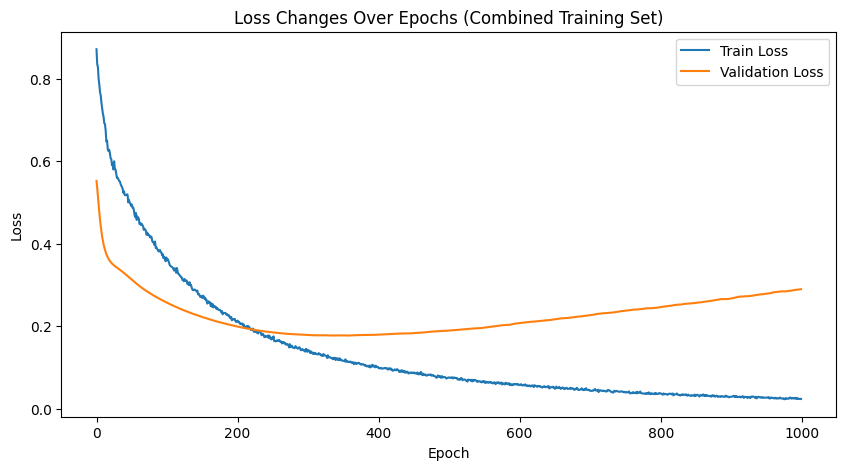

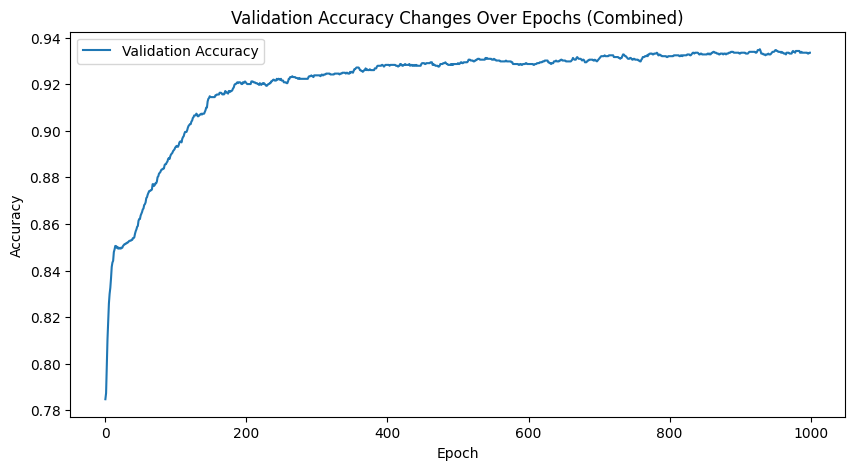

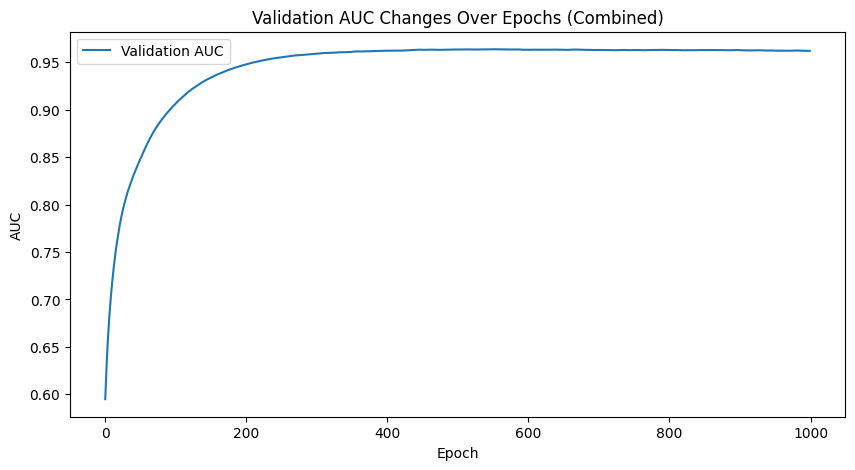

In [103]:
best_val_acc = 0.0
best_state = None

train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

EPOCHS = 1000
for epoch in tqdm(range(EPOCHS), desc="Training on multiple graphs"):
    # 1) Train step (all training graphs)
    train_loss = train_classifier(pre_model, optimizer, train_val_datalist)
    train_losses.append(train_loss)

    # 2) Validation step (all training graphs)
    val_loss, val_acc, val_auc = evaluate_classifier(pre_model, train_val_datalist, split="val_idx")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    # Track best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = pre_model.state_dict()

# Reload best model
if best_state is not None:
    pre_model.load_state_dict(best_state)

print(f"Best validation accuracy: {best_val_acc:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Changes Over Epochs (Combined Training Set)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Changes Over Epochs (Combined)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC Changes Over Epochs (Combined)')
plt.show()



In [104]:
@torch.no_grad()
def test_on_withheld_graph(model, data):
    model.eval()
    data = data.to(device)
    
    logits = model(data.x, data.edge_index).squeeze()
    labels = data.y.view(-1)
    
    loss = criterion(logits, labels).item()
    probs = torch.sigmoid(logits)
    binary_pred = (probs > 0.5).float()
    
    correct = (binary_pred == labels).sum().item()
    acc = correct / labels.size(0)
    
    try:
        auc = roc_auc_score(labels.cpu(), probs.cpu())
    except ValueError:
        auc = float('nan')
    
    return loss, acc, auc

test_loss, test_acc, test_auc = test_on_withheld_graph(pre_model, test_data)
print(f"\n=== Final Test on '{test_replicate_name}' ===")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")



=== Final Test on '13months-disease-replicate_2' ===
Test Loss: 0.5418 | Test Accuracy: 0.9095 | Test AUC: 0.8320


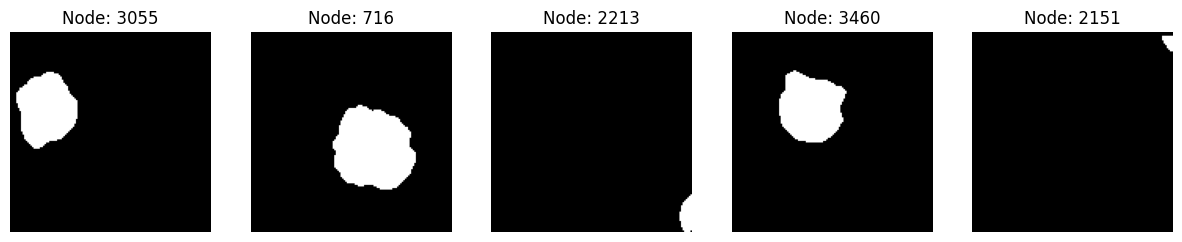

In [105]:
# Get predictions from the classifier
pre_model.eval()
data = graph_data_dict['8months-disease-replicate_1'].clone().to(device)
with torch.no_grad():
    logits = pre_model(data.x, data.edge_index).squeeze()
    preds = (logits.sigmoid() > 0.5).float()

# Identify positive nodes
positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]

# Visualize a subset of the positive nodes' patches images
num_images_to_plot = min(5, len(positive_nodes))  # Plot up to 5 images
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
axes = np.atleast_1d(axes)

# Randomly select positive nodes to plot
random_positive_nodes = random.sample(list(positive_nodes), num_images_to_plot)

for i, node in enumerate(random_positive_nodes):
    patch = data.patches[node].squeeze().to("cpu").numpy()
    axes[i].imshow(patch, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Node: {node.item()}")
plt.show()


In [96]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 76592], edge_attr=[76592, 1], y=[8186, 1], pos=[8186, 2], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 123704], edge_attr=[123704, 1], y=[10372, 1], pos=[10372, 2], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 75568], edge_attr=[75568, 1], y=[8202, 1], pos=[8202, 2], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 115726], edge_attr=[115726, 1], y=[9634, 1], pos=[9634, 2], patches=[9634, 128, 128, 1])}

In [97]:
# Store the positive nodes in a dictionary
positive_nodes_dict = {}

for key, data in graph_data_dict.items():
    data = data.clone().to(device)
    with torch.no_grad():
        logits = pre_model(data.x, data.edge_index).squeeze()
        preds = (logits.sigmoid() > 0.5).float()
    positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]
    positive_nodes_dict[key] = positive_nodes

#  Print the number of positive nodes for each replicate
for key, nodes in positive_nodes_dict.items():
    print(f"Number of positive nodes in '{key}': {len(nodes)}")

Number of positive nodes in '8months-disease-replicate_1': 830
Number of positive nodes in '13months-disease-replicate_1': 2234
Number of positive nodes in '8months-disease-replicate_2': 980
Number of positive nodes in '13months-disease-replicate_2': 760


# Exact values prediction

/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training:   0%|          | 12/5000 [00:00<01:29, 55.66it/s]

Epoch 0: Train Loss=4.9287, Val RMSE=2.6621, Val R²=-0.2283


Training:   2%|▏         | 110/5000 [00:01<01:23, 58.63it/s]

Epoch 100: Train Loss=0.7645, Val RMSE=1.4693, Val R²=0.6258


Training:   4%|▍         | 208/5000 [00:03<01:25, 55.77it/s]

Epoch 200: Train Loss=0.6023, Val RMSE=1.4474, Val R²=0.6369


Training:   6%|▌         | 312/5000 [00:05<01:22, 56.66it/s]

Epoch 300: Train Loss=0.4531, Val RMSE=1.4652, Val R²=0.6279


Training:   8%|▊         | 410/5000 [00:07<01:20, 56.92it/s]

Epoch 400: Train Loss=0.4422, Val RMSE=1.4527, Val R²=0.6342


Training:  10%|█         | 509/5000 [00:08<01:18, 57.30it/s]

Epoch 500: Train Loss=0.4124, Val RMSE=1.4665, Val R²=0.6272


Training:  12%|█▏        | 606/5000 [00:10<01:24, 51.85it/s]

Epoch 600: Train Loss=0.3399, Val RMSE=1.4602, Val R²=0.6305


Training:  14%|█▍        | 712/5000 [00:12<01:08, 62.96it/s]

Epoch 700: Train Loss=0.4031, Val RMSE=1.4654, Val R²=0.6278


Training:  15%|█▍        | 746/5000 [00:12<01:13, 57.73it/s]


Early stopping!
Best validation RMSE: 1.4290


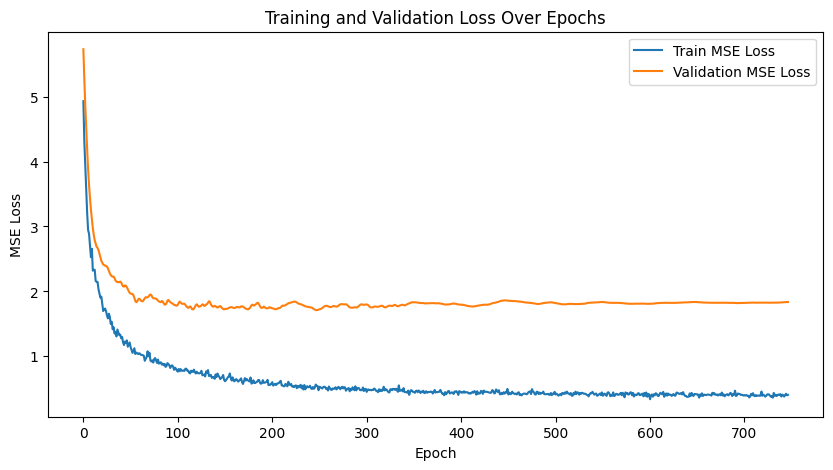

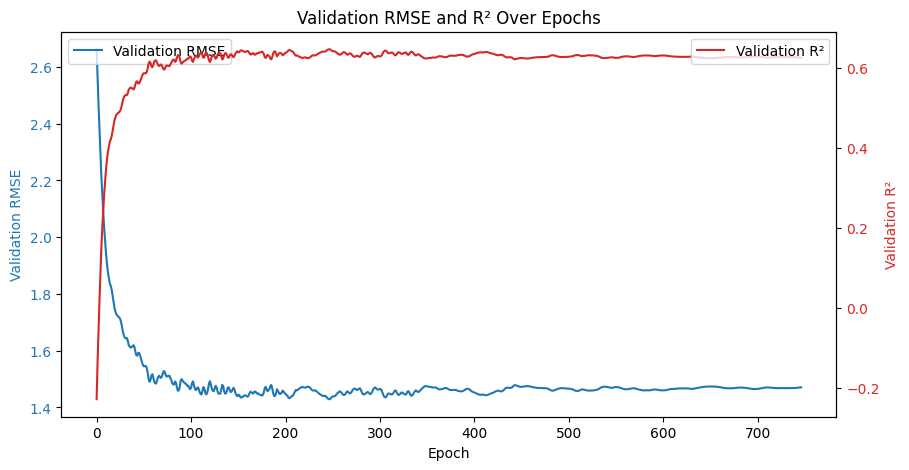

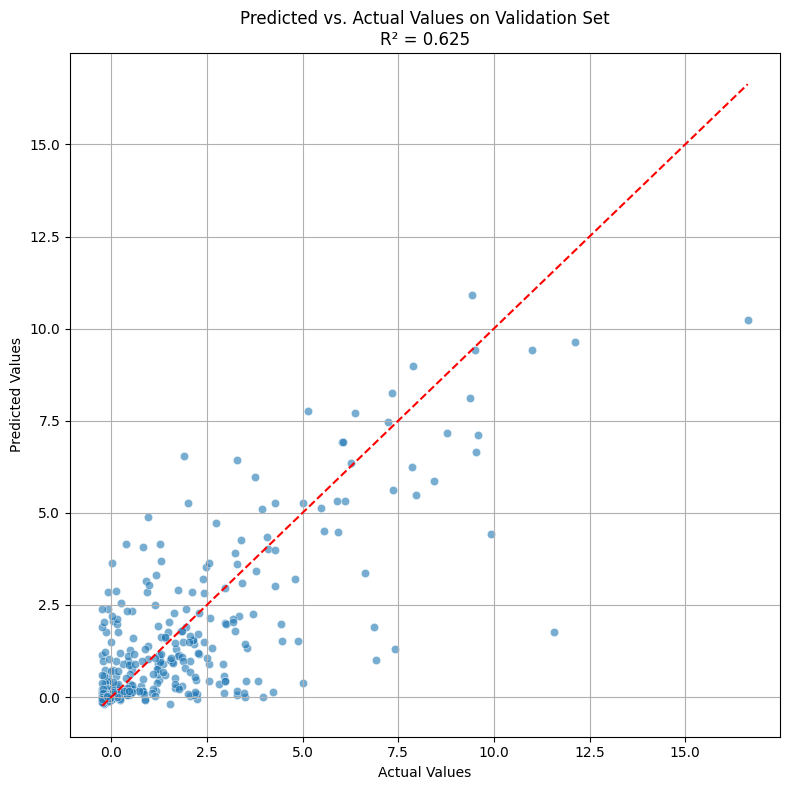


=== Final Test on '13months-disease-replicate_2' ===
Test MSE: 1267073.1250 | Test MAE: 787.1167 | Test RMSE: 1125.6434 | Test R²: -0.7911


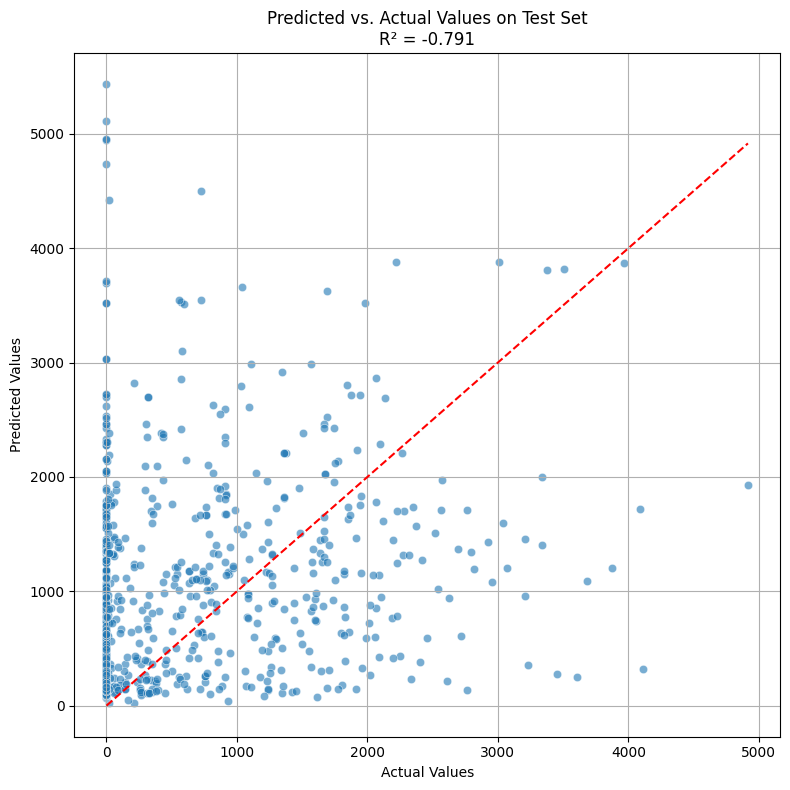

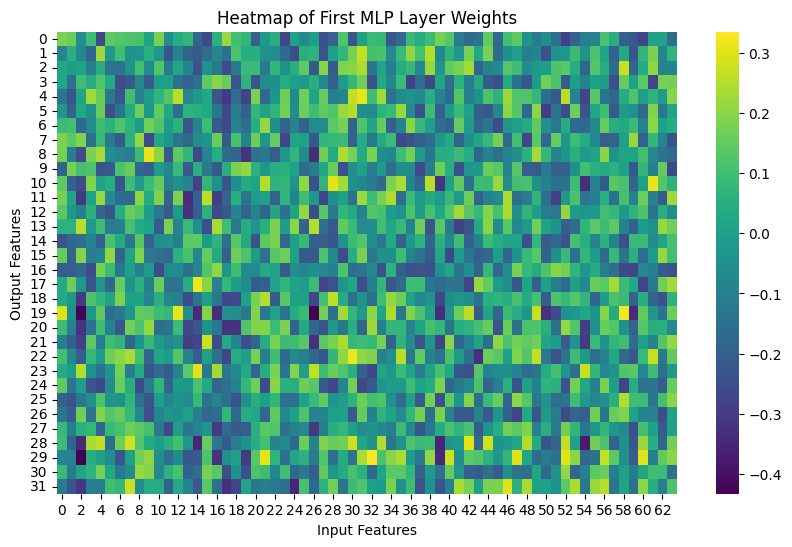


Total number of parameters: 183,617
Trainable parameters: 183,617


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from tqdm import tqdm  # For progress bar

# =====================================
# Step 1: Data Preparation
# =====================================

# Assuming graph_data_dict and positive_nodes_dict are predefined
# Example:
# graph_data_dict = {
#     'graph1': Data(x=..., edge_index=..., y=...),
#     'graph2': Data(x=..., edge_index=..., y=...),
#     ...
# }
# positive_nodes_dict = {
#     'graph1': torch.tensor([...]),
#     'graph2': torch.tensor([...]),
#     ...
# }

test_replicate_name = '13months-disease-replicate_2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_val_datalist = []
test_data = None

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Collect all node features and targets for scaling
all_features = []
all_targets = []
all_edge_weights = []  # Collect edge weights for scaling

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    all_features.append(data.x.cpu().numpy())
    all_targets.append(data.y.cpu().numpy())
    
    # Collect edge weights if they exist
    if hasattr(data, 'edge_attr'):
        # If edge_attr exists and represents weights, use it
        all_edge_weights.append(data.edge_attr.cpu().numpy().reshape(-1, 1))

# Fit feature and target scalers
all_features = np.vstack(all_features)
feature_scaler.fit(all_features)

all_targets = np.concatenate(all_targets).reshape(-1, 1)
target_scaler.fit(all_targets)

# Fit edge weight scaler if edge weights exist
if all_edge_weights:
    all_edge_weights = np.vstack(all_edge_weights)
    edge_weight_scaler = StandardScaler()
    edge_weight_scaler.fit(all_edge_weights)

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    
    # Normalize node features
    data.x = torch.tensor(feature_scaler.transform(data.x.cpu()), dtype=torch.float32)
    
    # Normalize target
    data.y = torch.tensor(target_scaler.transform(data.y.cpu().numpy().reshape(-1, 1)).flatten(), dtype=torch.float32)
    
    # Normalize edge weights if they exist
    if hasattr(data, 'edge_attr'):
        # If edge_attr exists and represents weights, normalize them
        data.edge_attr = torch.tensor(
            edge_weight_scaler.transform(data.edge_attr.cpu().numpy().reshape(-1, 1)).flatten(),
            dtype=torch.float32
        )
    
    # Assign default edge weights if none exist
    if not hasattr(data, 'edge_weight') and not hasattr(data, 'edge_attr'):
        data.edge_weight = torch.ones(data.edge_index.size(1), dtype=torch.float32)
    
    if name == test_replicate_name:
        # Assign the entire test graph
        test_data = data.to(device)
        # Assign only positive nodes for testing
        test_data.test_idx = positive_nodes_dict[name].to(device)
    else:
        # Retrieve positive nodes for the current graph
        positive_nodes = positive_nodes_dict[name]
        num_positive = positive_nodes.size(0)
        
        if num_positive == 0:
            print(f"No positive nodes found in '{name}'. Skipping this graph.")
            continue  # Skip graphs with no positive nodes
        
        # Shuffle positive node indices
        perm = torch.randperm(num_positive)
        
        # Split positive nodes into train and validation
        train_cutoff = int(0.8 * num_positive)
        val_cutoff   = int(0.9 * num_positive)
        
        data.train_idx = positive_nodes[perm[:train_cutoff]].to(device)
        data.val_idx   = positive_nodes[perm[train_cutoff:val_cutoff]].to(device)
        # data.mini_test_idx = positive_nodes[perm[val_cutoff:]].to(device)  # Optional
        
        train_val_datalist.append(data.to(device))

test_datalist = [test_data] if test_data is not None else []

# =====================================
# Step 2: Define the Simplified GNN Regressor Model
# =====================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax



class SimplifiedGNNRegressor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, dropout=0.3):
        super(SimplifiedGNNRegressor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None, batch=None):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc(x)
        return x.squeeze()  # [num_nodes]

# =====================================
# Step 3: Initialize Model, Optimizer, and Loss Function
# =====================================

def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Determine the number of input features
if not train_val_datalist:
    raise ValueError("No training/validation data available. Check positive_nodes_dict and graph_data_dict.")
in_channels = train_val_datalist[0].x.size(1)

# Initialize the model
model = SimplifiedGNNRegressor(
    in_channels=in_channels,
    hidden_channels=64,  # Reduced from 128
    dropout=0.3  # Reduced from 0.6
).to(device)

# Apply weight initialization
model.apply(weights_init)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

# Define the loss function
criterion = nn.MSELoss()

# =====================================
# Step 4: Define Training and Evaluation Functions
# =====================================

@torch.no_grad()
def evaluate_regressor(model, datalist, split="val_idx"):
    """
    Evaluate the model on the given split of each graph in datalist.
    Returns average MSE, MAE, RMSE, MAE overall, R², and all labels and predictions.
    """
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    total_nodes = 0
    all_labels = []
    all_preds = []
    
    for data in datalist:
        out = model(data.x, data.edge_index, edge_weight=data.edge_weight).squeeze()
        
        idx = getattr(data, split, None)
        if idx is None or idx.numel() == 0:
            continue
        
        labels = data.y[idx].view(-1)
        preds = out[idx]
        
        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        mae = F.l1_loss(preds, labels, reduction='sum').item()
        total_mae += mae
        
        total_nodes += labels.size(0)
        
        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
    
    if total_nodes == 0:
        return float('nan'), float('nan'), float('nan'), float('nan'), None, None
    
    avg_loss = total_loss / len(datalist)
    avg_mae = total_mae / total_nodes
    
    all_labels_np = torch.cat(all_labels, dim=0).numpy()
    all_preds_np = torch.cat(all_preds, dim=0).numpy()
    
    rmse = np.sqrt(mean_squared_error(all_labels_np, all_preds_np))
    mae_overall = mean_absolute_error(all_labels_np, all_preds_np)
    r2 = r2_score(all_labels_np, all_preds_np)
    
    return avg_loss, avg_mae, rmse, mae_overall, r2, (all_labels_np, all_preds_np)

def train_regressor(model, optimizer, datalist):
    """ Train on the 'train_idx' of each graph in datalist. """
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0
    
    for data in datalist:
        out = model(data.x, data.edge_index, edge_weight=data.edge_weight).squeeze()
        
        if data.train_idx.numel() == 0:
            continue  # Skip if there are no training nodes
        
        train_labels = data.y[data.train_idx].view(-1)
        train_preds  = out[data.train_idx]              # shape: [num_train_nodes]
        
        loss = criterion(train_preds, train_labels)
        loss.backward()
        total_loss += loss.item()
    
    # Gradient clipping (optional)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    
    # Single optimizer step for all graphs combined
    optimizer.step()
    
    return total_loss / len(datalist)

# =====================================
# Step 5: Training Loop with Early Stopping
# =====================================

best_val_rmse = float('inf')
best_state = None
patience = 500
trigger_times = 0

train_losses = []
val_losses = []
val_maes = []
val_rmses = []
val_r2s = []

test_losses = []
test_maes = []
test_rmses = []
test_r2s = []

EPOCHS = 5000
for epoch in tqdm(range(EPOCHS), desc="Training"):
    # 1) Train step (all training graphs)
    train_loss = train_regressor(model, optimizer, train_val_datalist)
    train_losses.append(train_loss)

    # 2) Validation step (all training graphs)
    val_loss, val_mae, val_rmse, val_mae_overall, val_r2, _ = evaluate_regressor(model, train_val_datalist, split="val_idx")
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    # 3) Update scheduler
    scheduler.step(val_loss)

    # 4) Early Stopping Check
    if not np.isnan(val_rmse) and val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping!")
        break

    # Optional: Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val RMSE={val_rmse:.4f}, Val R²={val_r2:.4f}")

# Load Best Model
if best_state:
    model.load_state_dict(best_state)

print(f"Best validation RMSE: {best_val_rmse:.4f}")

# =====================================
# Step 6: Plotting Results
# =====================================

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MSE Loss')
plt.plot(val_losses, label='Validation MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Plot Validation RMSE and R²
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation RMSE', color=color)
ax1.plot(val_rmses, color=color, label='Validation RMSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation R²', color=color)
ax2.plot(val_r2s, color=color, label='Validation R²')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Validation RMSE and R² Over Epochs')
plt.show()

# Scatter Plot: Predicted vs. Actual on Validation Set
_, _, _, _, val_r2, (val_labels, val_preds) = evaluate_regressor(
    model, 
    train_val_datalist, 
    split="val_idx"
)

if val_labels is not None and val_preds is not None:
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=val_labels, y=val_preds, alpha=0.6)
    plt.plot([val_labels.min(), val_labels.max()], [val_labels.min(), val_labels.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs. Actual Values on Validation Set\nR² = {val_r2:.3f}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No positive nodes available in the validation split for plotting.")

# =====================================
# Step 7: Final Testing on Withheld Graph
# =====================================

@torch.no_grad()
def test_on_withheld_graph_regression(model, data):
    model.eval()
    out = model(data.x, data.edge_index, edge_weight=data.edge_weight).squeeze()
    
    idx = data.test_idx  # Use only positive nodes for testing
    if idx.numel() == 0:
        print("No positive nodes in the test graph.")
        return float('nan'), float('nan'), float('nan'), float('nan')
    
    labels = data.y[idx].view(-1)
    preds  = out[idx]
    
    # Inverse transform to original scale
    labels = target_scaler.inverse_transform(labels.cpu().numpy().reshape(-1, 1)).flatten()
    preds = target_scaler.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).flatten()
    
    loss = mean_squared_error(labels, preds)
    mae = mean_absolute_error(labels, preds)
    rmse = np.sqrt(loss)
    r2 = r2_score(labels, preds)
    
    return loss, mae, rmse, r2

if test_data is not None:
    test_loss, test_mae, test_rmse, test_r2 = test_on_withheld_graph_regression(model, test_data)
    print(f"\n=== Final Test on '{test_replicate_name}' ===")
    print(f"Test MSE: {test_loss:.4f} | Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f} | Test R²: {test_r2:.4f}")
else:
    print("No test data available.")

# Optional: Scatter Plot for Test Set
if test_data is not None:
    with torch.no_grad():
        out = model(test_data.x, test_data.edge_index, edge_weight=test_data.edge_weight).squeeze()
        idx = test_data.test_idx
        labels = test_data.y[idx].view(-1)
        preds = out[idx]
        
        # Inverse transform to original scale
        labels = target_scaler.inverse_transform(labels.cpu().numpy().reshape(-1, 1)).flatten()
        preds = target_scaler.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).flatten()
        
        if len(labels) > 0:
            test_r2 = r2_score(labels, preds)
            plt.figure(figsize=(8, 8))
            sns.scatterplot(x=labels, y=preds, alpha=0.6)
            plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.title(f'Predicted vs. Actual Values on Test Set\nR² = {test_r2:.3f}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("No positive nodes available in the test split for plotting.")

# =====================================
# Step 8: (Optional) Visualize Model Parameters
# =====================================

# Visualize weights of the first linear layer in the MLP
mlp_weights = model.fc[0].weight.detach().cpu().numpy()

plt.figure(figsize=(10, 6))
sns.heatmap(mlp_weights, cmap='viridis')
plt.xlabel('Input Features')
plt.ylabel('Output Features')
plt.title('Heatmap of First MLP Layer Weights')
plt.show()

# Optional: Print model parameter statistics
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal number of parameters: {total_params:,}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")


# Graph Autoregressive Construction

In [348]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATv2Conv, LayerNorm
from tqdm import tqdm

class GATv2EncoderLayer(nn.Module):
    def __init__(self, in_channels, out_channels, heads=4, edge_dim=None, dropout=0.1):
        super(GATv2EncoderLayer, self).__init__()
        self.gatv2 = GATv2Conv(
            in_channels,
            out_channels,
            heads=heads,
            edge_dim=edge_dim,
            concat=True,
            dropout=dropout,
            add_self_loops=True,
            bias=True,
            residual=True
        )

        # Learnable linear transformation layer
        self.heads_transform = nn.Linear(out_channels * heads, out_channels)

        self.mlp = nn.Sequential(
            nn.Linear(out_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels),
        )

        self.norm1 = LayerNorm(out_channels * heads)  # After GATv2Conv
        self.norm2 = LayerNorm(out_channels)  # After MLP
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x, edge_index, edge_attr):
        # GATv2 forward pass
        out = self.gatv2(x, edge_index, edge_attr)
        out = self.norm1(out)  # Layer normalization after GATv2
        out = self.dropout(out)
        out = self.activation(out)

        # Learnable linear transformation
        out = self.heads_transform(out)

        # MLP with residual connection
        residual_mlp = out
        out = self.mlp(out)
        out = out + residual_mlp  # Add residual connection for MLP
        out = self.norm2(out)  # Layer normalization after MLP
        out = self.dropout(out)

        return out


class MaskedNodePredictorWithEncoder(nn.Module):
    def __init__(self, in_features, hidden_channels, edge_dim=None, heads=4, num_encoders=2, dropout=0.1):
        super(MaskedNodePredictorWithEncoder, self).__init__()
        self.encoders = nn.ModuleList()

        # Add encoder layers
        for i in range(num_encoders):
            self.encoders.append(
                GATv2EncoderLayer(
                    in_channels=in_features if i == 0 else hidden_channels,
                    out_channels=hidden_channels,
                    heads=heads,
                    edge_dim=edge_dim,
                    dropout=dropout,
                )
            )

        # Prediction MLP
        self.predictor = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.GELU(),
            nn.Linear(hidden_channels, in_features),  # Predict original features
        )

    def forward(self, data, mask):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = x.clone()  # To avoid modifying the original features

        # # Apply masking
        # x[mask] = 0  # Mask features (can use a learnable token here)

        # Pass through encoder layers
        for encoder in self.encoders:
            x = encoder(x, edge_index, edge_attr)

        # Extract embeddings of masked nodes
        masked_embeddings = x[mask]

        # Predict original features
        predictions = self.predictor(masked_embeddings)

        return predictions



In [349]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATv2Conv, LayerNorm
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import random

# Objective: Mimic BERT-style training (Masked Node Prediction)

# Dataset preparation
# Replace synthetic data with your dataset
data = graph_data_dict['13months-disease-replicate_1'].clone().to(device)

# Extract data dimensions
num_nodes = data.x.size(0)
in_features = data.x.size(1)
hidden_channels = 64
edge_dim = data.edge_attr.size(1) if data.edge_attr is not None else None
heads = 4

# Initialize model
masked_pre_model = MaskedNodePredictorWithEncoder(
    in_features=in_features,
    hidden_channels=hidden_channels,
    edge_dim=edge_dim,
    heads=heads,
    num_encoders=2,
    dropout=0.2,
).to(device)

# Learning rate schedule parameters
warmup_epochs = 200
initial_lr = 1e-4
warmup_lr = 1e-6
epochs = 500
eta_min = 1e-7

# Initialize optimizer with warmup_lr
optimizer = torch.optim.Adam(masked_pre_model.parameters(), lr=warmup_lr)

# Create cosine scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs, eta_min=eta_min)

# Training loop with BERT-style masking
loss_history = []
lr_history = []
smoothing_factor = 0.9
smoothed_loss = None
criterion = nn.MSELoss()

for epoch in tqdm(range(epochs), desc="Training", leave=True):
    masked_pre_model.train()
    optimizer.zero_grad()

    # Warmup learning rate
    if epoch < warmup_epochs:
        lr = warmup_lr + (initial_lr - warmup_lr) * epoch / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    else:
        scheduler.step()

    # Record current learning rate
    lr_history.append(optimizer.param_groups[0]['lr'])

    # Randomly select 15% of the nodes to mask
    mask = torch.rand(num_nodes) < 0.15
    target = data.x[mask]

    # Apply BERT-style masking strategy
    modified_data_x = data.x.clone()
    for idx in torch.where(mask)[0]:
        rand = random.random()
        if rand < 0.8:  # 80% of the time, replace with [MASK]
            modified_data_x[idx] = 0
        elif rand < 0.9:  # 10% of the time, replace with a random value
            modified_data_x[idx] = torch.randn_like(data.x[idx])
        # 10% of the time, leave it unchanged

    # Update the data object
    data.x = modified_data_x

    # Forward pass
    predictions = masked_pre_model(data, mask)

    # Compute loss only for masked nodes
    loss = criterion(predictions, target)

    # Smooth loss using exponential moving average
    if smoothed_loss is None:
        smoothed_loss = loss.item()
    else:
        smoothed_loss = smoothing_factor * smoothed_loss + (1 - smoothing_factor) * loss.item()

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Log smoothed loss
    loss_history.append(smoothed_loss)

    # Update progress bar with loss info
    if epoch % 50 == 0:
        tqdm.write(f"Epoch {epoch}/{epochs}, Loss: {smoothed_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

Training:   1%|          | 6/500 [00:00<00:16, 29.27it/s]

Epoch 0/500, Loss: 1.0056, LR: 0.000001


Training:  11%|█         | 54/500 [00:01<00:14, 30.64it/s]

Epoch 50/500, Loss: 0.1678, LR: 0.000026


Training:  21%|██        | 106/500 [00:03<00:12, 31.41it/s]

Epoch 100/500, Loss: 0.1296, LR: 0.000051


Training:  31%|███       | 154/500 [00:04<00:10, 31.59it/s]

Epoch 150/500, Loss: 0.1198, LR: 0.000075


Training:  41%|████      | 206/500 [00:06<00:09, 30.74it/s]

Epoch 200/500, Loss: 0.1153, LR: 0.000100


Training:  51%|█████     | 254/500 [00:08<00:07, 30.89it/s]

Epoch 250/500, Loss: 0.1118, LR: 0.000093


Training:  61%|██████    | 306/500 [00:09<00:06, 30.78it/s]

Epoch 300/500, Loss: 0.1144, LR: 0.000074


Training:  71%|███████   | 354/500 [00:11<00:04, 30.88it/s]

Epoch 350/500, Loss: 0.1098, LR: 0.000049


Training:  81%|████████  | 406/500 [00:13<00:03, 30.90it/s]

Epoch 400/500, Loss: 0.1093, LR: 0.000025


Training:  91%|█████████ | 454/500 [00:14<00:01, 31.13it/s]

Epoch 450/500, Loss: 0.1123, LR: 0.000007


Training: 100%|██████████| 500/500 [00:16<00:00, 31.11it/s]


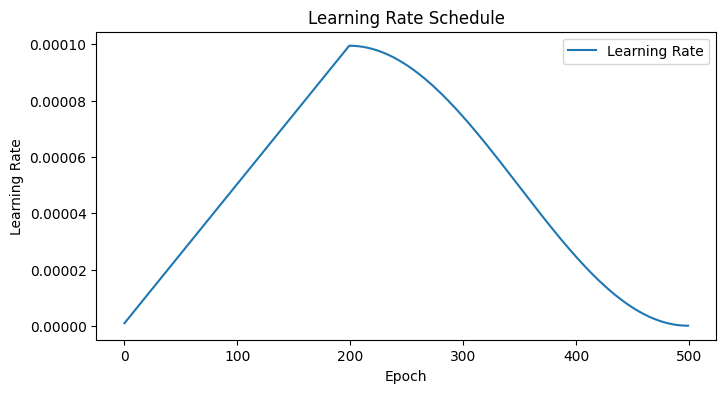

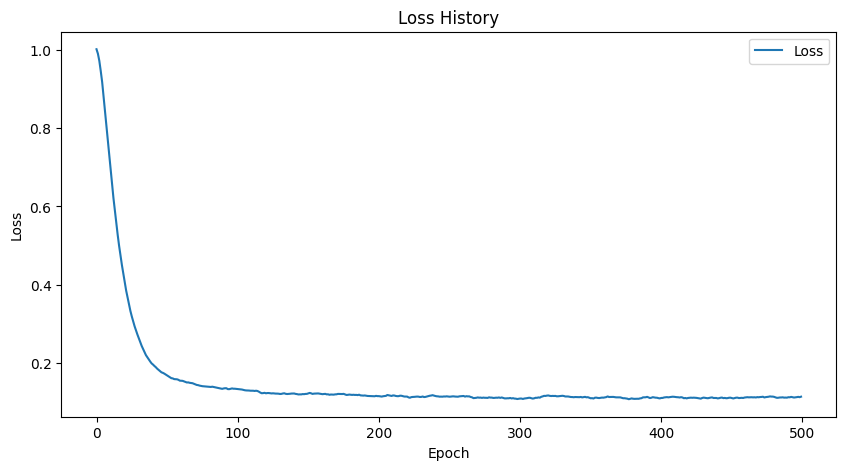

In [345]:
# Plot learning rate schedule
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(lr_history, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

# Visualize the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.show()


Evaluating: 100%|██████████| 10/10 [00:00<00:00, 27.52it/s]
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


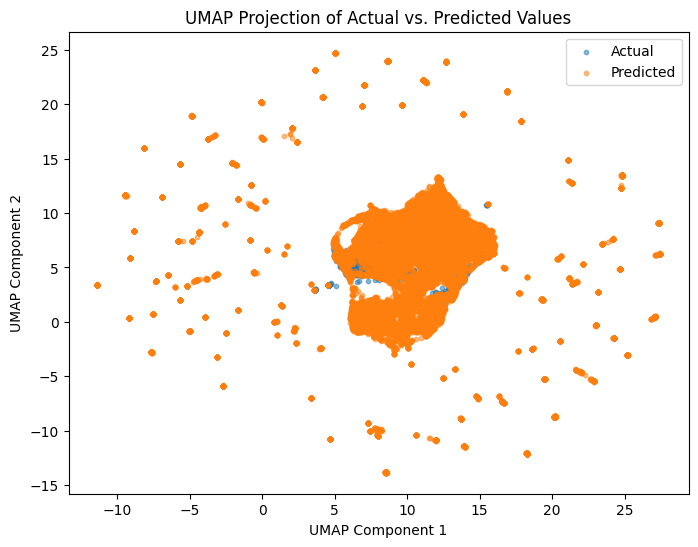

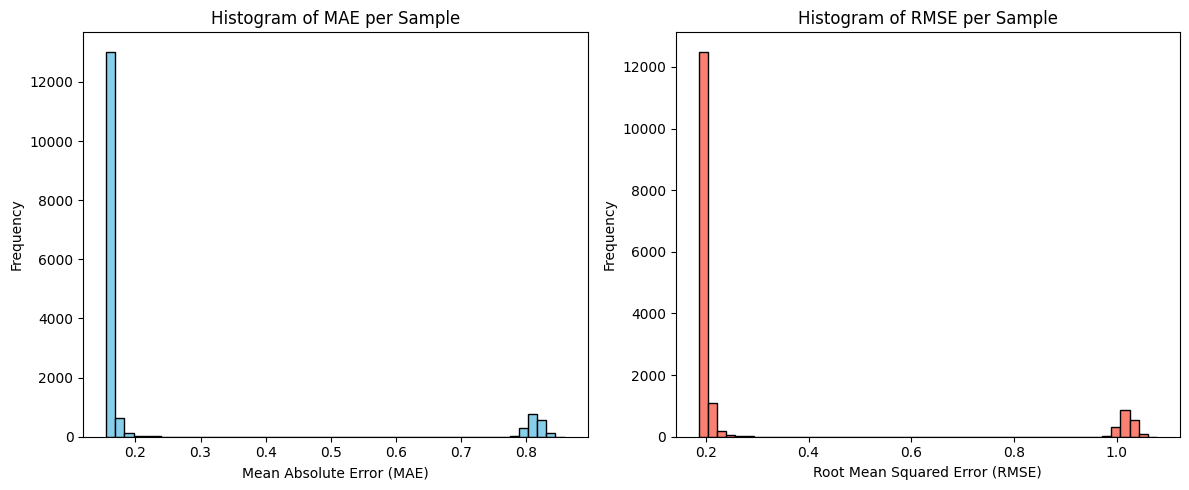

Overall MAE: 0.2351
Overall RMSE: 0.3916


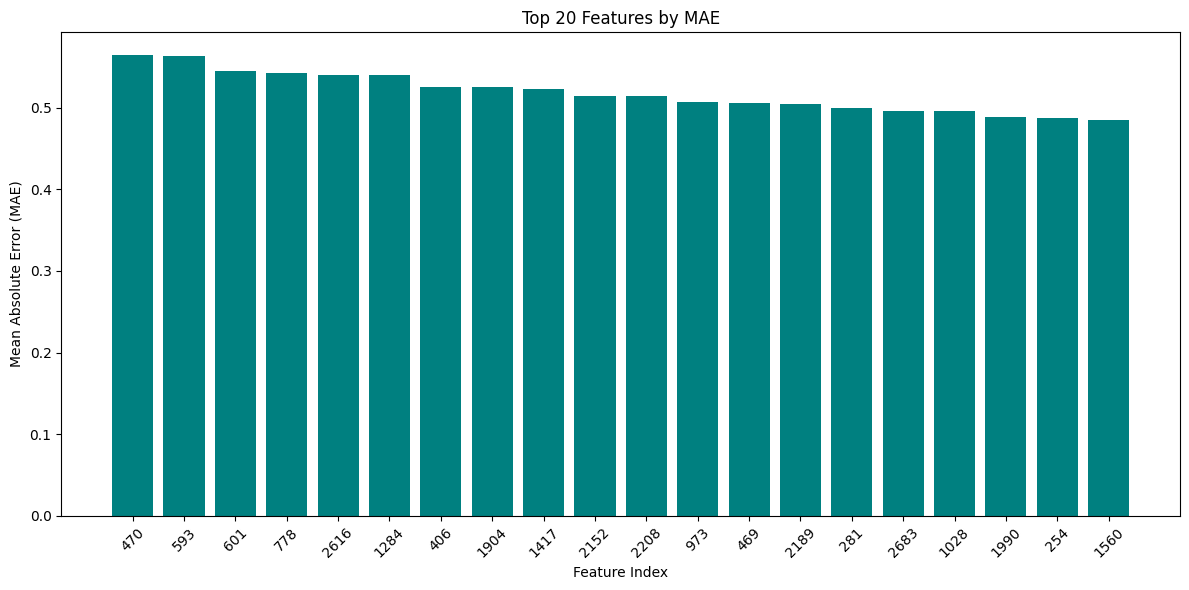

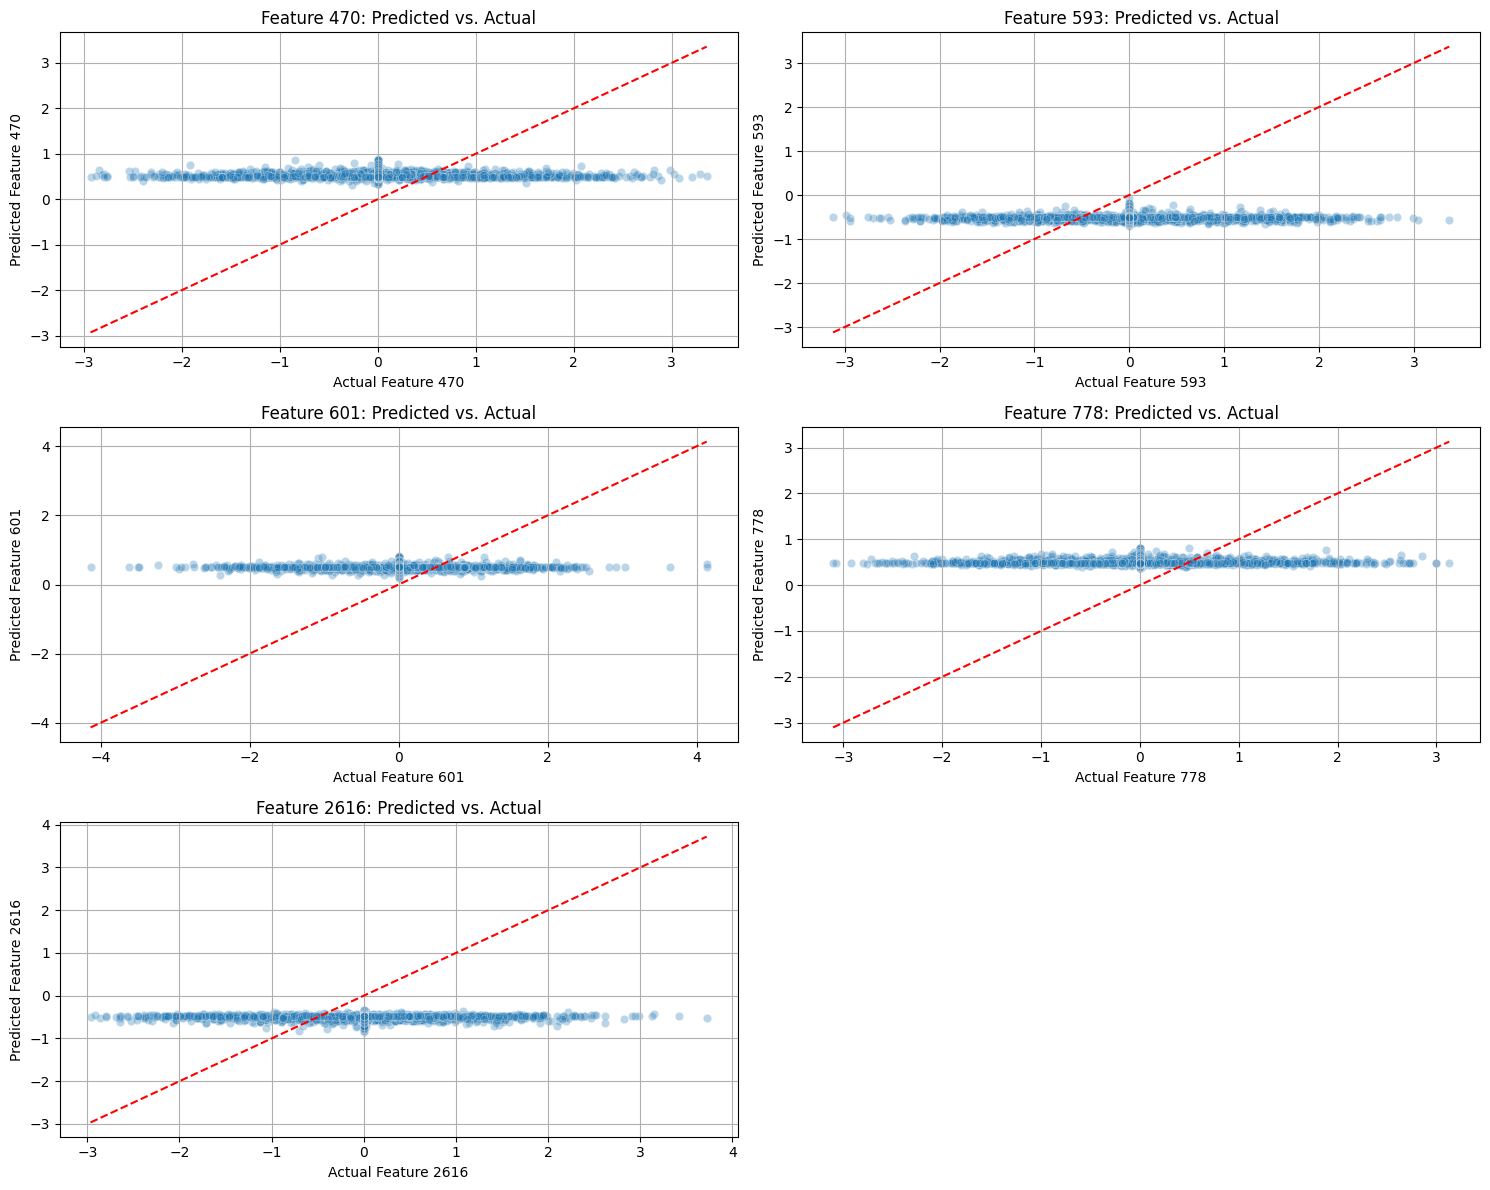

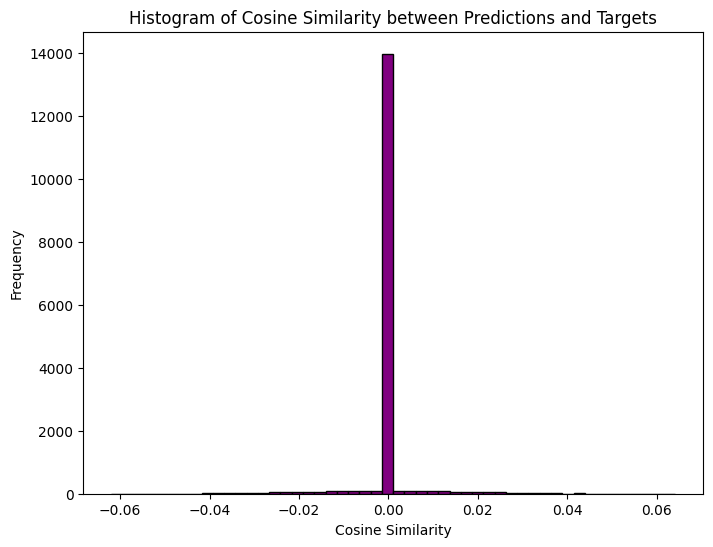

Average Cosine Similarity: 0.0000


In [327]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import umap
from tqdm import tqdm
import random

# Define your model class
# class MaskedNodePredictorWithEncoder(nn.Module):
#     ...
#     # Your model definition here

# Define the evaluation function
def evaluate_model(model, data, mask_percentage=0.15, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Apply masking
        num_nodes = data.x.size(0)
        mask = torch.rand(num_nodes, device=device) < mask_percentage
        target = data.x[mask].clone()
        
        modified_data_x = data.x.clone()
        masked_indices = torch.where(mask)[0]
        
        for idx in masked_indices:
            rand = random.random()
            if rand < 0.8:
                modified_data_x[idx] = 0  # [MASK]
            elif rand < 0.9:
                modified_data_x[idx] = torch.randn_like(data.x[idx])
            # else: leave it unchanged
        
        # Update data with masked features
        data.x = modified_data_x
        
        # Forward pass
        predictions = model(data, mask)
        
        # Move to CPU and convert to NumPy
        predictions = predictions.cpu().numpy()
        targets = target.cpu().numpy()
        
    return predictions, targets

# Assume you have a trained model and data
# model = MaskedNodePredictorWithEncoder(...).to(device)
# ... [Training code here] ...

# After training, collect predictions and targets
model.eval()
all_predictions = []
all_targets = []

num_evaluations = 10  # Adjust based on dataset size

for _ in tqdm(range(num_evaluations), desc="Evaluating"):
    preds, targs = evaluate_model(model, data, mask_percentage=0.15, device=device)
    all_predictions.append(preds)
    all_targets.append(targs)

# Concatenate all collected predictions and targets
all_predictions = np.concatenate(all_predictions, axis=0)  # Shape: [num_samples, 2000]
all_targets = np.concatenate(all_targets, axis=0)          # Shape: [num_samples, 2000]

# ============================
# Visualization: Dimensionality Reduction
# ============================

# PCA for initial dimensionality reduction
pca = PCA(n_components=50, random_state=42)
pred_pca = pca.fit_transform(all_predictions)
target_pca = pca.transform(all_targets)

# UMAP for 2D visualization
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
pred_umap = umap_reducer.fit_transform(pred_pca)
target_umap = umap_reducer.transform(target_pca)

# Scatter Plot: UMAP Projection
plt.figure(figsize=(8, 6))
plt.scatter(target_umap[:, 0], target_umap[:, 1], alpha=0.5, label='Actual', s=10)
plt.scatter(pred_umap[:, 0], pred_umap[:, 1], alpha=0.5, label='Predicted', s=10)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Actual vs. Predicted Values')
plt.legend()
plt.show()

# ============================
# Visualization: Aggregate Metrics
# ============================

# Compute MAE and RMSE
mae_per_sample = np.mean(np.abs(all_predictions - all_targets), axis=1)
rmse_per_sample = np.sqrt(np.mean((all_predictions - all_targets) ** 2, axis=1))

# Plot Histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mae_per_sample, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Frequency')
plt.title('Histogram of MAE per Sample')

plt.subplot(1, 2, 2)
plt.hist(rmse_per_sample, bins=50, color='salmon', edgecolor='black')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE per Sample')

plt.tight_layout()
plt.show()

# Overall Metrics
overall_mae = mean_absolute_error(all_targets, all_predictions)
overall_rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))

print(f"Overall MAE: {overall_mae:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")

# ============================
# Visualization: Feature-wise Error Analysis
# ============================

# Compute MAE for each feature
feature_mae = np.mean(np.abs(all_predictions - all_targets), axis=0)

# Identify top 20 features with highest MAE
top_20_features = np.argsort(feature_mae)[-20:][::-1]  # Sorted descending

# Plot MAE for Top 20 Features
plt.figure(figsize=(12, 6))
plt.bar(range(20), feature_mae[top_20_features], color='teal')
plt.xlabel('Feature Index')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Top 20 Features by MAE')
plt.xticks(range(20), top_20_features, rotation=45)
plt.tight_layout()
plt.show()

# Scatter Plots for Top 5 Features
import seaborn as sns

top_5_features = top_20_features[:5]

plt.figure(figsize=(15, 12))
for i, feature_idx in enumerate(top_5_features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=all_targets[:, feature_idx], y=all_predictions[:, feature_idx], alpha=0.3)
    min_val = min(all_targets[:, feature_idx].min(), all_predictions[:, feature_idx].min())
    max_val = max(all_targets[:, feature_idx].max(), all_predictions[:, feature_idx].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # y=x line
    plt.xlabel(f'Actual Feature {feature_idx}')
    plt.ylabel(f'Predicted Feature {feature_idx}')
    plt.title(f'Feature {feature_idx}: Predicted vs. Actual')
    plt.grid(True)
plt.tight_layout()
plt.show()

# ============================
# Visualization: Cosine Similarity
# ============================

# Normalize predictions and targets
pred_norm = all_predictions / (np.linalg.norm(all_predictions, axis=1, keepdims=True) + 1e-8)
target_norm = all_targets / (np.linalg.norm(all_targets, axis=1, keepdims=True) + 1e-8)

# Compute cosine similarity
cos_sim = np.sum(pred_norm * target_norm, axis=1)

# Plot Histogram of Cosine Similarity
plt.figure(figsize=(8, 6))
plt.hist(cos_sim, bins=50, color='purple', edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarity between Predictions and Targets')
plt.show()

# Compute Overall Average Cosine Similarity
average_cos_sim = np.mean(cos_sim)
print(f"Average Cosine Similarity: {average_cos_sim:.4f}")


In [227]:
# Store the model's state_dict
store_dir = "./model_checkpoints"

if not os.path.exists(store_dir):
    os.makedirs(store_dir)

torch.save(model.state_dict(), os.path.join(store_dir, "masked_node_predictor.pth"))

In [300]:
class NodeValuePredictor(nn.Module):
    """
    Fine-Tuning Model: Reuses pretrained encoders for node-level value prediction.
    """
    def __init__(
        self, 
        in_features, 
        hidden_channels, 
        edge_dim=None, 
        heads=4, 
        num_encoders=2, 
        dropout=0.1,
        out_dim=1  # Number of target values per node
    ):
        super(NodeValuePredictor, self).__init__()
        
        # Initialize encoder layers
        self.encoders = nn.ModuleList()
        for i in range(num_encoders):
            self.encoders.append(
                GATv2EncoderLayer(
                    in_channels=in_features if i == 0 else hidden_channels,
                    out_channels=hidden_channels,
                    heads=heads,
                    edge_dim=edge_dim,
                    dropout=dropout
                )
            )

        # Add dropout to predictor layers
        self.value_predictor = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),  # Add dropout after activation
            nn.Linear(hidden_channels, out_dim)
        )


    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Pass through encoder layers
        for encoder in self.encoders:
            x = encoder(x, edge_index, edge_attr)

        # Predict node-level values
        out = self.value_predictor(x)
        return out

    def load_encoder_weights(self, pretrained_model):
        """
        Load encoder weights from a pretrained MaskedNodePredictorWithEncoder model.
        """
        with torch.no_grad():
            for my_layer, pre_layer in zip(self.encoders, pretrained_model.encoders):
                my_layer.load_state_dict(pre_layer.state_dict())

In [ ]:


# -------------------------------------------------
# 2. Load Pretrained Model and Initialize Fine-Tuning Model
# -------------------------------------------------

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume 'graph_data_dict' is already defined and contains your graph data
data = graph_data_dict['13months-disease-replicate_1'].clone().to(device)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)

# Total number of nodes
num_nodes = data.num_nodes

# Define split ratio
train_ratio = 0.8
val_ratio = 0.2

# Ensure that train_ratio + val_ratio == 1
assert train_ratio + val_ratio == 1.0, "Train and validation ratios must sum to 1."

# Generate shuffled indices
indices = torch.randperm(num_nodes).tolist()

# Calculate split sizes
train_size = int(train_ratio * num_nodes)
val_size = num_nodes - train_size

# Split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
val_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)

train_mask[train_indices] = True
val_mask[val_indices] = True

# Assign masks to the data object
data.train_mask = train_mask
data.val_mask = val_mask

# Verify assignment
print("Data object attributes after assigning masks:", data.keys)
print("Does 'train_mask' exist?", hasattr(data, 'train_mask'))
print("Does 'val_mask' exist?", hasattr(data, 'val_mask'))

# Define model hyperparameters based on your data
in_features = data.x.size(1)          # Example input feature size (2766)
hidden_channels = 64                  # Hidden dimension size
edge_dim = data.edge_attr.size(1) if data.edge_attr is not None else None
heads = 4
num_encoders = 2
dropout = 0.2
out_dim = 1  # Adjust based on your target (e.g., number of regression targets per node)

# Initialize the pretrained MaskedNodePredictorWithEncoder
pretrained_model = MaskedNodePredictorWithEncoder(
    in_features=in_features,
    hidden_channels=hidden_channels,
    edge_dim=edge_dim,
    heads=heads,
    num_encoders=num_encoders,
    dropout=dropout
).to(device)

# Load pretrained weights (ensure the path is correct)
pretrained_checkpoint_path = os.path.join(store_dir, "masked_node_predictor.pth")
pretrained_state = torch.load(pretrained_checkpoint_path, map_location=device)
pretrained_model.load_state_dict(pretrained_state)
pretrained_model.eval()  # Set to evaluation mode

# Initialize the fine-tuning NodeValuePredictor
fine_tuned_model = NodeValuePredictor(
    in_features=in_features,
    hidden_channels=hidden_channels,
    edge_dim=edge_dim,
    heads=heads,
    num_encoders=num_encoders,
    dropout=dropout,
    out_dim=out_dim
).to(device)

# Transfer the encoder weights from the pretrained model
fine_tuned_model.load_encoder_weights(pretrained_model)
fine_tuned_model.train()  # Set to training mode

Data object attributes after assigning masks: <bound method BaseData.keys of Data(x=[10372, 2766], edge_index=[2, 51860], edge_attr=[51860, 1], y=[10372, 1], pos=[10372, 2], patches=[10372, 128, 128, 1], train_mask=[10372], val_mask=[10372])>
Does 'train_mask' exist? True
Does 'val_mask' exist? True


/tmp/ipykernel_30576/2173851398.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(pretrained_checkpoint_path, map_location=device)


NodeValuePredictor(
  (encoders): ModuleList(
    (0): GATv2EncoderLayer(
      (gatv2): GATv2Conv(2766, 64, heads=4)
      (heads_transform): Linear(in_features=256, out_features=64, bias=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm(256, affine=True, mode=graph)
      (norm2): LayerNorm(64, affine=True, mode=graph)
      (dropout): Dropout(p=0.2, inplace=False)
      (activation): GELU(approximate='none')
    )
    (1): GATv2EncoderLayer(
      (gatv2): GATv2Conv(64, 64, heads=4)
      (heads_transform): Linear(in_features=256, out_features=64, bias=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm(256, affine=True, mode=graph

In [350]:
# -------------------------------------------------
# 4. Configure Optimizer and Scheduler with Warmup
# -------------------------------------------------

# Define learning rate schedule parameters
warmup_epochs = 500
total_epochs = 5000
initial_lr = 1e-3
warmup_lr = 1e-5
eta_min = 1e-6

# Initialize optimizer with warmup_lr
optimizer = Adam(fine_tuned_model.parameters(), lr=warmup_lr)

# Define cosine annealing scheduler (only after warmup)
scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs, eta_min=eta_min)


# -------------------------------------------------
# 5. Define Loss Function and Logging Structures
# -------------------------------------------------

criterion = nn.MSELoss()

# Initialize logging variables
train_loss_history = []
val_loss_history = []
lr_history = []

# Parameters for loss smoothing
smoothing_factor = 0.9
smoothed_train_loss = None


# -------------------------------------------------
# 6. Fine-Tuning Training Loop with Advanced Techniques
# -------------------------------------------------

for epoch in tqdm(range(1, total_epochs + 1), desc="Fine-Tuning Training", leave=True):
    fine_tuned_model.train()
    epoch_train_loss = 0.0
    optimizer.zero_grad()

    # Adjust learning rate with warmup
    if epoch <= warmup_epochs:
        lr_increment = (initial_lr - warmup_lr) / warmup_epochs
        current_lr = warmup_lr + lr_increment * epoch
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    else:
        # After warmup, use the scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
    
    lr_history.append(current_lr)

    # Forward pass
    predictions = fine_tuned_model(data)  # Shape: (num_nodes, out_dim)

    # Compute loss only on training nodes
    loss = criterion(predictions[data.train_mask].view(-1), data.y[data.train_mask].view(-1).float())

    # Backward pass
    loss.backward()

    # Gradient clipping (optional)
    torch.nn.utils.clip_grad_norm_(fine_tuned_model.parameters(), max_norm=1.0)

    optimizer.step()
    optimizer.zero_grad()

    # Accumulate loss
    epoch_train_loss += loss.item() * data.train_mask.sum().item()

    # Calculate average training loss
    avg_train_loss = epoch_train_loss / data.train_mask.sum().item()

    # Smooth the training loss
    if smoothed_train_loss is None:
        smoothed_train_loss = avg_train_loss
    else:
        smoothed_train_loss = smoothing_factor * smoothed_train_loss + (1 - smoothing_factor) * avg_train_loss
    train_loss_history.append(smoothed_train_loss)

    # Validation Phase
    fine_tuned_model.eval()
    with torch.no_grad():
        # Forward pass
        val_predictions = fine_tuned_model(data)

        # Compute loss on validation nodes
        val_loss = criterion(val_predictions[data.val_mask].view(-1), data.y[data.val_mask].view(-1).float())

        # Calculate average validation loss
        avg_val_loss = val_loss.item()  # Since it's already averaged over validation nodes
        val_loss_history.append(avg_val_loss)

    # Update tqdm with training and validation loss
    if epoch % 50 == 0:
        tqdm.write(
            f"Epoch [{epoch}/{total_epochs}] "
            f"Train Loss: {smoothed_train_loss:.6f} "
            f"Val Loss: {avg_val_loss:.6f} "
            f"LR: {current_lr:.6f}"
        )


Fine-Tuning Training:   0%|          | 0/5000 [00:00<?, ?it/s]


AttributeError: 'GlobalStorage' object has no attribute 'train_mask'

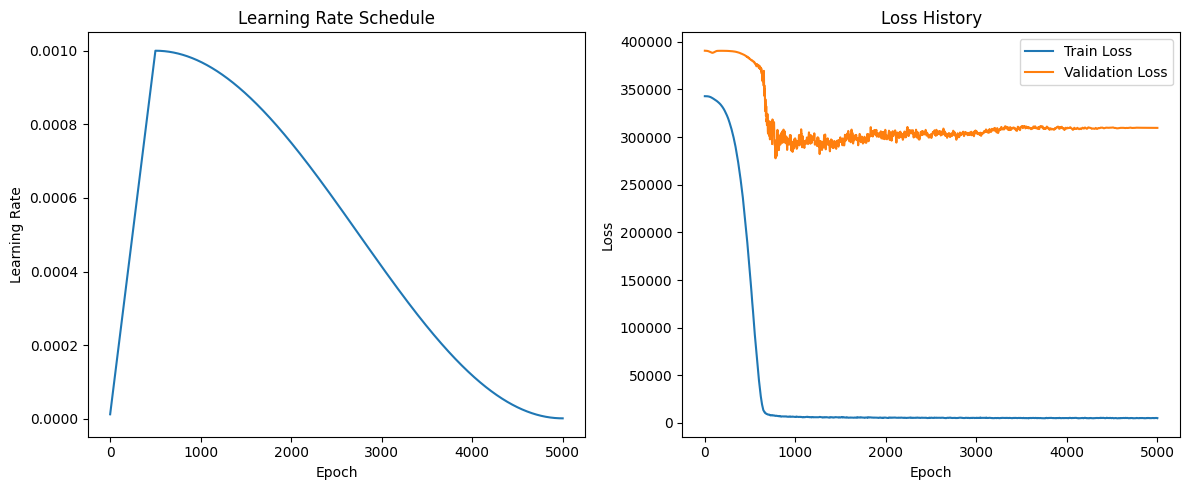

In [258]:
# Visualize the learning rate schedule and loss history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lr_history)
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [301]:
# ------------------------------------------------------------------
# 4. Simple Two-Layer GNN Model with LayerNorm + Residual
# ------------------------------------------------------------------
class SimpleTwoLayerGNNValuePredictor(nn.Module):
    """
    A simple two-layer GNN model using GCNConv, Layer Normalization,
    and an optional residual connection for node-level value prediction.
    """
    def __init__(
        self,
        in_features,
        hidden_channels,
        out_dim=1,
        dropout=0.1,
        with_residual=True
    ):
        super(SimpleTwoLayerGNNValuePredictor, self).__init__()

        # Two GCN layers (you can use GATv2Conv or others if you prefer)
        self.conv1 = GCNConv(in_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Layer Normalization after each GCN layer
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.norm2 = nn.LayerNorm(hidden_channels)

        # Activation and Dropout
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Final linear layer for node-level predictions
        self.fc_out = nn.Linear(hidden_channels, out_dim)

        # Flag to enable/disable residual connections
        self.with_residual = with_residual

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # --- 1st Layer ---
        x1 = self.conv1(x, edge_index)
        x1 = self.norm1(x1)
        x1 = self.activation(x1)
        x1 = self.dropout(x1)

        # --- 2nd Layer ---
        x2 = self.conv2(x1, edge_index)

        if self.with_residual:
            x2 = x2 + x1  # Residual connection

        x2 = self.norm2(x2)
        x2 = self.activation(x2)
        x2 = self.dropout(x2)

        # Final linear projection to out_dim
        out = self.fc_out(x2)
        return out
    
class PretrainedAndTwoLayerGNNValuePredictor(nn.Module):
    """
    This model first passes data through the same pretrained GATv2 encoders
    used in NodeValuePredictor, THEN applies an extra two-layer GNN
    (like the SimpleTwoLayerGNNValuePredictor) before final predictions.
    """
    def __init__(
        self,
        in_features,
        hidden_channels,
        edge_dim=None,
        heads=4,
        num_encoders=2,
        dropout=0.1,
        out_dim=1,
        with_residual=True
    ):
        super(PretrainedAndTwoLayerGNNValuePredictor, self).__init__()

        # --- Pretrained GATv2 encoders ---
        self.encoders = nn.ModuleList()
        for i in range(num_encoders):
            self.encoders.append(
                GATv2EncoderLayer(
                    in_channels=in_features if i == 0 else hidden_channels,
                    out_channels=hidden_channels,
                    heads=heads,
                    edge_dim=edge_dim,
                    dropout=dropout
                )
            )

        # --- Additional two-layer GCN ---
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        self.norm1 = nn.LayerNorm(hidden_channels)
        self.norm2 = nn.LayerNorm(hidden_channels)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Final linear layer
        self.fc_out = nn.Linear(hidden_channels, out_dim)

        self.with_residual = with_residual

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # 1) Pass through GATv2 pretrained encoders
        for encoder in self.encoders:
            x = encoder(x, edge_index, edge_attr)

        # 2) Pass through two-layer GCN with LN + residual
        x1 = self.conv1(x, edge_index)
        x1 = self.norm1(x1)
        x1 = self.activation(x1)
        x1 = self.dropout(x1)

        x2 = self.conv2(x1, edge_index)
        if self.with_residual:
            x2 = x2 + x1
        x2 = self.norm2(x2)
        x2 = self.activation(x2)
        x2 = self.dropout(x2)

        # 3) Final output
        out = self.fc_out(x2)
        return out

    def load_encoder_weights(self, pretrained_model):
        """
        Load encoder weights from a pretrained MaskedNodePredictorWithEncoder model.
        """
        with torch.no_grad():
            for my_layer, pre_layer in zip(self.encoders, pretrained_model.encoders):
                my_layer.load_state_dict(pre_layer.state_dict())

In [302]:
# ------------------------------------------------------------------
# 10. Initialize Models
# ------------------------------------------------------------------

# A) Fine-Tuned Model (original NodeValuePredictor)
fine_tuned_model = NodeValuePredictor(
    in_features=in_features,
    hidden_channels=hidden_channels,
    edge_dim=edge_dim,
    heads=heads,
    num_encoders=num_encoders,
    dropout=dropout,
    out_dim=out_dim
).to(device)
fine_tuned_model.load_encoder_weights(pretrained_model)
fine_tuned_model.train()

# B) Simple Two-Layer GNN Model
two_layer_model = SimpleTwoLayerGNNValuePredictor(
    in_features=in_features,
    hidden_channels=hidden_channels,
    out_dim=out_dim,
    dropout=dropout,
    with_residual=True
).to(device)
two_layer_model.train()

# C) Pretrained + Two-Layer GNN
pretrained_plus_two_layer_model = PretrainedAndTwoLayerGNNValuePredictor(
    in_features=in_features,
    hidden_channels=hidden_channels,
    edge_dim=edge_dim,
    heads=heads,
    num_encoders=num_encoders,
    dropout=dropout,
    out_dim=out_dim,
    with_residual=True
).to(device)
pretrained_plus_two_layer_model.load_encoder_weights(pretrained_model)
pretrained_plus_two_layer_model.train()


PretrainedAndTwoLayerGNNValuePredictor(
  (encoders): ModuleList(
    (0): GATv2EncoderLayer(
      (gatv2): GATv2Conv(2766, 64, heads=4)
      (heads_transform): Linear(in_features=256, out_features=64, bias=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm(256, affine=True, mode=graph)
      (norm2): LayerNorm(64, affine=True, mode=graph)
      (dropout): Dropout(p=0.2, inplace=False)
      (activation): GELU(approximate='none')
    )
    (1): GATv2EncoderLayer(
      (gatv2): GATv2Conv(64, 64, heads=4)
      (heads_transform): Linear(in_features=256, out_features=64, bias=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm(256, aff

In [304]:
# ------------------------------------------------------------------
# 11. Define Warmup + Cosine Annealing for each model
# ------------------------------------------------------------------
warmup_epochs = 20000
total_epochs = 100000
initial_lr = 1e-3
warmup_lr = 1e-5
eta_min = 1e-6

optimizer_fine_tuned = Adam(fine_tuned_model.parameters(), lr=warmup_lr)
scheduler_fine_tuned = CosineAnnealingLR(
    optimizer_fine_tuned,
    T_max=total_epochs - warmup_epochs,
    eta_min=eta_min
)

optimizer_two_layer = Adam(two_layer_model.parameters(), lr=warmup_lr)
scheduler_two_layer = CosineAnnealingLR(
    optimizer_two_layer,
    T_max=total_epochs - warmup_epochs,
    eta_min=eta_min
)

optimizer_pretrained_plus = Adam(pretrained_plus_two_layer_model.parameters(), lr=warmup_lr)
scheduler_pretrained_plus = CosineAnnealingLR(
    optimizer_pretrained_plus,
    T_max=total_epochs - warmup_epochs,
    eta_min=eta_min
)

criterion = nn.MSELoss()

# Track losses and learning rates
train_loss_history_fine = []
val_loss_history_fine = []
lr_history_fine = []

train_loss_history_two = []
val_loss_history_two = []
lr_history_two = []

train_loss_history_pre2 = []
val_loss_history_pre2 = []
lr_history_pre2 = []

# For smoothing
smoothing_factor = 0.9
smoothed_train_loss_fine = None
smoothed_train_loss_two = None
smoothed_train_loss_pre2 = None

# ------------------------------------------------------------------
# 12. Training Loop (all three models in parallel)
# ------------------------------------------------------------------
for epoch in tqdm(range(1, total_epochs + 1), desc="Training All Models", leave=True):

    # -------------------------------------------------
    # 12a. Train Model A (Fine-Tuned GATv2)
    # -------------------------------------------------
    fine_tuned_model.train()
    optimizer_fine_tuned.zero_grad()

    # Warmup or Scheduler
    if epoch <= warmup_epochs:
        lr_inc = (initial_lr - warmup_lr) / warmup_epochs
        current_lr_fine = warmup_lr + lr_inc * epoch
        for param_group in optimizer_fine_tuned.param_groups:
            param_group['lr'] = current_lr_fine
    else:
        scheduler_fine_tuned.step()
        current_lr_fine = optimizer_fine_tuned.param_groups[0]['lr']
    lr_history_fine.append(current_lr_fine)

    # Forward
    predictions_fine = fine_tuned_model(data)
    loss_fine = criterion(
        predictions_fine[data.train_mask].view(-1),
        data.y[data.train_mask].view(-1).float()
    )
    loss_fine.backward()
    torch.nn.utils.clip_grad_norm_(fine_tuned_model.parameters(), max_norm=1.0)
    optimizer_fine_tuned.step()

    # Smooth training loss
    avg_train_loss_fine = loss_fine.item()
    if smoothed_train_loss_fine is None:
        smoothed_train_loss_fine = avg_train_loss_fine
    else:
        smoothed_train_loss_fine = smoothing_factor * smoothed_train_loss_fine + \
                                   (1 - smoothing_factor) * avg_train_loss_fine
    train_loss_history_fine.append(smoothed_train_loss_fine)

    # Validation
    fine_tuned_model.eval()
    with torch.no_grad():
        val_predictions_fine = fine_tuned_model(data)
        val_loss_fine = criterion(
            val_predictions_fine[data.val_mask].view(-1),
            data.y[data.val_mask].view(-1).float()
        )
    val_loss_history_fine.append(val_loss_fine.item())

    # -------------------------------------------------
    # 12b. Train Model B (Two-Layer GNN)
    # -------------------------------------------------
    two_layer_model.train()
    optimizer_two_layer.zero_grad()

    if epoch <= warmup_epochs:
        lr_inc = (initial_lr - warmup_lr) / warmup_epochs
        current_lr_two = warmup_lr + lr_inc * epoch
        for param_group in optimizer_two_layer.param_groups:
            param_group['lr'] = current_lr_two
    else:
        scheduler_two_layer.step()
        current_lr_two = optimizer_two_layer.param_groups[0]['lr']
    lr_history_two.append(current_lr_two)

    predictions_two = two_layer_model(data)
    loss_two = criterion(
        predictions_two[data.train_mask].view(-1),
        data.y[data.train_mask].view(-1).float()
    )
    loss_two.backward()
    torch.nn.utils.clip_grad_norm_(two_layer_model.parameters(), max_norm=1.0)
    optimizer_two_layer.step()

    avg_train_loss_two = loss_two.item()
    if smoothed_train_loss_two is None:
        smoothed_train_loss_two = avg_train_loss_two
    else:
        smoothed_train_loss_two = smoothing_factor * smoothed_train_loss_two + \
                                  (1 - smoothing_factor) * avg_train_loss_two
    train_loss_history_two.append(smoothed_train_loss_two)

    two_layer_model.eval()
    with torch.no_grad():
        val_predictions_two = two_layer_model(data)
        val_loss_two = criterion(
            val_predictions_two[data.val_mask].view(-1),
            data.y[data.val_mask].view(-1).float()
        )
    val_loss_history_two.append(val_loss_two.item())

    # -------------------------------------------------
    # 12c. Train Model C (Pretrained + Two-Layer GNN)
    # -------------------------------------------------
    pretrained_plus_two_layer_model.train()
    optimizer_pretrained_plus.zero_grad()

    if epoch <= warmup_epochs:
        lr_inc = (initial_lr - warmup_lr) / warmup_epochs
        current_lr_pre2 = warmup_lr + lr_inc * epoch
        for param_group in optimizer_pretrained_plus.param_groups:
            param_group['lr'] = current_lr_pre2
    else:
        scheduler_pretrained_plus.step()
        current_lr_pre2 = optimizer_pretrained_plus.param_groups[0]['lr']
    lr_history_pre2.append(current_lr_pre2)

    predictions_pre2 = pretrained_plus_two_layer_model(data)
    loss_pre2 = criterion(
        predictions_pre2[data.train_mask].view(-1),
        data.y[data.train_mask].view(-1).float()
    )
    loss_pre2.backward()
    torch.nn.utils.clip_grad_norm_(pretrained_plus_two_layer_model.parameters(), max_norm=1.0)
    optimizer_pretrained_plus.step()

    avg_train_loss_pre2 = loss_pre2.item()
    if smoothed_train_loss_pre2 is None:
        smoothed_train_loss_pre2 = avg_train_loss_pre2
    else:
        smoothed_train_loss_pre2 = smoothing_factor * smoothed_train_loss_pre2 + \
                                   (1 - smoothing_factor) * avg_train_loss_pre2
    train_loss_history_pre2.append(smoothed_train_loss_pre2)

    pretrained_plus_two_layer_model.eval()
    with torch.no_grad():
        val_predictions_pre2 = pretrained_plus_two_layer_model(data)
        val_loss_pre2 = criterion(
            val_predictions_pre2[data.val_mask].view(-1),
            data.y[data.val_mask].view(-1).float()
        )
    val_loss_history_pre2.append(val_loss_pre2.item())

    # -------------------------------------------------
    # 12d. Print Progress
    # -------------------------------------------------
    if epoch % 50 == 0:
        tqdm.write(
            f"Epoch [{epoch}/{total_epochs}]\n"
            f"    [A: Fine-Tuned GATv2]  "
            f"Train Loss: {smoothed_train_loss_fine:.6f}, "
            f"Val Loss: {val_loss_fine.item():.6f}, "
            f"LR: {current_lr_fine:.6f}\n"
            f"    [B: Two-Layer GNN]     "
            f"Train Loss: {smoothed_train_loss_two:.6f}, "
            f"Val Loss: {val_loss_two.item():.6f}, "
            f"LR: {current_lr_two:.6f}\n"
            f"    [C: Pretrained+2Layer] "
            f"Train Loss: {smoothed_train_loss_pre2:.6f}, "
            f"Val Loss: {val_loss_pre2.item():.6f}, "
            f"LR: {current_lr_pre2:.6f}\n"
        )

# ------------------------------------------------------------------
# 13. Results and Comparison
# ------------------------------------------------------------------
print("Training finished.")
print("--------------------------------------------------------")
print("[A: Fine-Tuned GATv2] Final Val Loss :", val_loss_history_fine[-1])
print("[B: Two-Layer GNN]    Final Val Loss :", val_loss_history_two[-1])
print("[C: Pretrained+2Layer] Final Val Loss:", val_loss_history_pre2[-1])

Training All Models:   0%|          | 51/100000 [00:02<1:38:18, 16.94it/s]

Epoch [50/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 216152.416887, Val Loss: 382166.906250, LR: 0.000012
    [B: Two-Layer GNN]     Train Loss: 321423.242673, Val Loss: 368844.687500, LR: 0.000012
    [C: Pretrained+2Layer] Train Loss: 320946.425758, Val Loss: 368246.125000, LR: 0.000012



Training All Models:   0%|          | 102/100000 [00:05<1:29:55, 18.52it/s]

Epoch [100/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 215820.525762, Val Loss: 382175.125000, LR: 0.000015
    [B: Two-Layer GNN]     Train Loss: 321451.565368, Val Loss: 368823.656250, LR: 0.000015
    [C: Pretrained+2Layer] Train Loss: 320857.995676, Val Loss: 368226.812500, LR: 0.000015



Training All Models:   0%|          | 153/100000 [00:08<1:30:49, 18.32it/s]

Epoch [150/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 215894.101902, Val Loss: 382200.843750, LR: 0.000017
    [B: Two-Layer GNN]     Train Loss: 321397.593933, Val Loss: 368793.656250, LR: 0.000017
    [C: Pretrained+2Layer] Train Loss: 320832.248267, Val Loss: 368198.343750, LR: 0.000017



Training All Models:   0%|          | 202/100000 [00:11<1:32:58, 17.89it/s]

Epoch [200/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 215512.157694, Val Loss: 382227.031250, LR: 0.000020
    [B: Two-Layer GNN]     Train Loss: 321395.549954, Val Loss: 368759.437500, LR: 0.000020
    [C: Pretrained+2Layer] Train Loss: 320808.158738, Val Loss: 368171.750000, LR: 0.000020



Training All Models:   0%|          | 253/100000 [00:14<1:28:17, 18.83it/s]

Epoch [250/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 215456.092599, Val Loss: 382194.500000, LR: 0.000022
    [B: Two-Layer GNN]     Train Loss: 321283.289163, Val Loss: 368728.343750, LR: 0.000022
    [C: Pretrained+2Layer] Train Loss: 320760.428476, Val Loss: 368134.531250, LR: 0.000022



Training All Models:   0%|          | 302/100000 [00:16<1:38:19, 16.90it/s]

Epoch [300/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 215297.747996, Val Loss: 382174.562500, LR: 0.000025
    [B: Two-Layer GNN]     Train Loss: 321315.500264, Val Loss: 368691.000000, LR: 0.000025
    [C: Pretrained+2Layer] Train Loss: 320771.712420, Val Loss: 368096.093750, LR: 0.000025



Training All Models:   0%|          | 352/100000 [00:19<1:35:04, 17.47it/s]

Epoch [350/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 215105.909096, Val Loss: 382158.781250, LR: 0.000027
    [B: Two-Layer GNN]     Train Loss: 321259.569620, Val Loss: 368643.843750, LR: 0.000027
    [C: Pretrained+2Layer] Train Loss: 320708.443109, Val Loss: 368032.281250, LR: 0.000027



Training All Models:   0%|          | 403/100000 [00:22<1:32:04, 18.03it/s]

Epoch [400/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 214779.798261, Val Loss: 382123.062500, LR: 0.000030
    [B: Two-Layer GNN]     Train Loss: 321202.976941, Val Loss: 368601.062500, LR: 0.000030
    [C: Pretrained+2Layer] Train Loss: 320652.782657, Val Loss: 368099.531250, LR: 0.000030



Training All Models:   0%|          | 453/100000 [00:25<1:35:55, 17.30it/s]

Epoch [450/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 214207.884742, Val Loss: 382116.031250, LR: 0.000032
    [B: Two-Layer GNN]     Train Loss: 321123.663658, Val Loss: 368543.687500, LR: 0.000032
    [C: Pretrained+2Layer] Train Loss: 320562.696202, Val Loss: 368007.218750, LR: 0.000032



Training All Models:   1%|          | 502/100000 [00:27<1:31:36, 18.10it/s]

Epoch [500/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 214066.904463, Val Loss: 382046.187500, LR: 0.000035
    [B: Two-Layer GNN]     Train Loss: 321110.856961, Val Loss: 368486.781250, LR: 0.000035
    [C: Pretrained+2Layer] Train Loss: 320534.994591, Val Loss: 367972.406250, LR: 0.000035



Training All Models:   1%|          | 552/100000 [00:30<1:31:56, 18.03it/s]

Epoch [550/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 213830.166046, Val Loss: 382018.562500, LR: 0.000037
    [B: Two-Layer GNN]     Train Loss: 321040.091652, Val Loss: 368420.093750, LR: 0.000037
    [C: Pretrained+2Layer] Train Loss: 320492.576155, Val Loss: 367899.156250, LR: 0.000037



Training All Models:   3%|▎         | 2752/100000 [02:31<1:29:45, 18.06it/s]

Epoch [2750/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 176361.063866, Val Loss: 377653.968750, LR: 0.000146
    [B: Two-Layer GNN]     Train Loss: 313048.516505, Val Loss: 360604.125000, LR: 0.000146
    [C: Pretrained+2Layer] Train Loss: 312433.900466, Val Loss: 360380.531250, LR: 0.000146



Training All Models:   3%|▎         | 2802/100000 [02:34<1:22:57, 19.53it/s]

Epoch [2800/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 174840.020292, Val Loss: 377422.937500, LR: 0.000149
    [B: Two-Layer GNN]     Train Loss: 312741.417222, Val Loss: 360392.000000, LR: 0.000149
    [C: Pretrained+2Layer] Train Loss: 312036.974895, Val Loss: 360156.625000, LR: 0.000149



Training All Models:   3%|▎         | 2853/100000 [02:37<1:28:34, 18.28it/s]

Epoch [2850/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 173328.832087, Val Loss: 377335.750000, LR: 0.000151
    [B: Two-Layer GNN]     Train Loss: 312409.741060, Val Loss: 360098.906250, LR: 0.000151
    [C: Pretrained+2Layer] Train Loss: 311711.684194, Val Loss: 359877.562500, LR: 0.000151



Training All Models:   3%|▎         | 2902/100000 [02:39<1:32:30, 17.49it/s]

Epoch [2900/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 172261.031422, Val Loss: 377122.437500, LR: 0.000154
    [B: Two-Layer GNN]     Train Loss: 312149.727956, Val Loss: 359714.687500, LR: 0.000154
    [C: Pretrained+2Layer] Train Loss: 311477.152308, Val Loss: 359512.156250, LR: 0.000154



Training All Models:   3%|▎         | 2953/100000 [02:42<1:34:25, 17.13it/s]

Epoch [2950/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 170341.704142, Val Loss: 376961.531250, LR: 0.000156
    [B: Two-Layer GNN]     Train Loss: 311745.167197, Val Loss: 359453.906250, LR: 0.000156
    [C: Pretrained+2Layer] Train Loss: 311000.289338, Val Loss: 359247.781250, LR: 0.000156



Training All Models:   3%|▎         | 3002/100000 [02:45<1:31:55, 17.59it/s]

Epoch [3000/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 168662.098258, Val Loss: 376506.125000, LR: 0.000159
    [B: Two-Layer GNN]     Train Loss: 311406.475112, Val Loss: 359112.437500, LR: 0.000159
    [C: Pretrained+2Layer] Train Loss: 310725.772840, Val Loss: 358950.750000, LR: 0.000159



Training All Models:   3%|▎         | 3053/100000 [02:48<1:24:50, 19.04it/s]

Epoch [3050/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 167362.379485, Val Loss: 376563.906250, LR: 0.000161
    [B: Two-Layer GNN]     Train Loss: 311045.978905, Val Loss: 358850.250000, LR: 0.000161
    [C: Pretrained+2Layer] Train Loss: 310324.480229, Val Loss: 358430.906250, LR: 0.000161



Training All Models:   3%|▎         | 3104/100000 [02:51<1:23:32, 19.33it/s]

Epoch [3100/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 165853.411949, Val Loss: 376215.218750, LR: 0.000163
    [B: Two-Layer GNN]     Train Loss: 310730.865514, Val Loss: 358457.718750, LR: 0.000163
    [C: Pretrained+2Layer] Train Loss: 310040.719858, Val Loss: 358366.687500, LR: 0.000163



Training All Models:   3%|▎         | 3152/100000 [02:53<1:31:35, 17.62it/s]

Epoch [3150/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 164076.113703, Val Loss: 375836.093750, LR: 0.000166
    [B: Two-Layer GNN]     Train Loss: 310421.481008, Val Loss: 358157.562500, LR: 0.000166
    [C: Pretrained+2Layer] Train Loss: 309621.144734, Val Loss: 357825.281250, LR: 0.000166



Training All Models:   3%|▎         | 3203/100000 [02:56<1:22:13, 19.62it/s]

Epoch [3200/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 162431.312962, Val Loss: 375509.875000, LR: 0.000168
    [B: Two-Layer GNN]     Train Loss: 309971.021661, Val Loss: 357805.718750, LR: 0.000168
    [C: Pretrained+2Layer] Train Loss: 309204.940974, Val Loss: 357621.656250, LR: 0.000168



Training All Models:   3%|▎         | 3253/100000 [02:59<1:26:07, 18.72it/s]

Epoch [3250/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 160813.517120, Val Loss: 375384.343750, LR: 0.000171
    [B: Two-Layer GNN]     Train Loss: 309625.314951, Val Loss: 357421.906250, LR: 0.000171
    [C: Pretrained+2Layer] Train Loss: 308840.736980, Val Loss: 357267.062500, LR: 0.000171



Training All Models:   3%|▎         | 3302/100000 [03:01<1:24:46, 19.01it/s]

Epoch [3300/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 159210.597964, Val Loss: 375407.500000, LR: 0.000173
    [B: Two-Layer GNN]     Train Loss: 309257.342583, Val Loss: 357003.906250, LR: 0.000173
    [C: Pretrained+2Layer] Train Loss: 308438.966642, Val Loss: 356781.781250, LR: 0.000173



Training All Models:   3%|▎         | 3353/100000 [03:04<1:24:08, 19.14it/s]

Epoch [3350/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 157260.727962, Val Loss: 375305.750000, LR: 0.000176
    [B: Two-Layer GNN]     Train Loss: 308863.685727, Val Loss: 356697.656250, LR: 0.000176
    [C: Pretrained+2Layer] Train Loss: 307998.051662, Val Loss: 356377.281250, LR: 0.000176



Training All Models:   3%|▎         | 3403/100000 [03:07<1:24:30, 19.05it/s]

Epoch [3400/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 155768.614133, Val Loss: 374809.031250, LR: 0.000178
    [B: Two-Layer GNN]     Train Loss: 308435.857897, Val Loss: 356290.656250, LR: 0.000178
    [C: Pretrained+2Layer] Train Loss: 307578.411228, Val Loss: 355791.312500, LR: 0.000178



Training All Models:   3%|▎         | 3454/100000 [03:10<1:23:30, 19.27it/s]

Epoch [3450/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 154129.433797, Val Loss: 374521.375000, LR: 0.000181
    [B: Two-Layer GNN]     Train Loss: 307966.212712, Val Loss: 355921.343750, LR: 0.000181
    [C: Pretrained+2Layer] Train Loss: 307100.434694, Val Loss: 355762.718750, LR: 0.000181



Training All Models:   4%|▎         | 3503/100000 [03:12<1:29:27, 17.98it/s]

Epoch [3500/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 152402.170758, Val Loss: 374289.875000, LR: 0.000183
    [B: Two-Layer GNN]     Train Loss: 307610.741918, Val Loss: 355542.062500, LR: 0.000183
    [C: Pretrained+2Layer] Train Loss: 306628.923102, Val Loss: 355039.687500, LR: 0.000183



Training All Models:   4%|▎         | 3552/100000 [03:15<1:31:29, 17.57it/s]

Epoch [3550/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 150193.984526, Val Loss: 373993.968750, LR: 0.000186
    [B: Two-Layer GNN]     Train Loss: 307183.544272, Val Loss: 355123.093750, LR: 0.000186
    [C: Pretrained+2Layer] Train Loss: 306238.851075, Val Loss: 354780.156250, LR: 0.000186



Training All Models:   4%|▎         | 3602/100000 [03:18<1:29:45, 17.90it/s]

Epoch [3600/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 148636.014250, Val Loss: 374014.281250, LR: 0.000188
    [B: Two-Layer GNN]     Train Loss: 306787.949038, Val Loss: 354698.281250, LR: 0.000188
    [C: Pretrained+2Layer] Train Loss: 305867.063592, Val Loss: 354398.093750, LR: 0.000188



Training All Models:   4%|▎         | 3652/100000 [03:21<1:28:53, 18.07it/s]

Epoch [3650/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 146674.145266, Val Loss: 373699.062500, LR: 0.000191
    [B: Two-Layer GNN]     Train Loss: 306297.110634, Val Loss: 354315.875000, LR: 0.000191
    [C: Pretrained+2Layer] Train Loss: 305226.514636, Val Loss: 353922.500000, LR: 0.000191



Training All Models:   4%|▎         | 3703/100000 [03:23<1:32:12, 17.40it/s]

Epoch [3700/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 145059.764138, Val Loss: 373539.968750, LR: 0.000193
    [B: Two-Layer GNN]     Train Loss: 305954.992866, Val Loss: 353887.375000, LR: 0.000193
    [C: Pretrained+2Layer] Train Loss: 304892.582978, Val Loss: 353388.343750, LR: 0.000193



Training All Models:   4%|▍         | 3753/100000 [03:26<1:29:33, 17.91it/s]

Epoch [3750/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 142962.407468, Val Loss: 373421.281250, LR: 0.000196
    [B: Two-Layer GNN]     Train Loss: 305466.609752, Val Loss: 353423.906250, LR: 0.000196
    [C: Pretrained+2Layer] Train Loss: 304395.848869, Val Loss: 352987.468750, LR: 0.000196



Training All Models:   4%|▍         | 3803/100000 [03:29<1:29:37, 17.89it/s]

Epoch [3800/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 141004.376819, Val Loss: 372802.812500, LR: 0.000198
    [B: Two-Layer GNN]     Train Loss: 304930.445631, Val Loss: 352996.562500, LR: 0.000198
    [C: Pretrained+2Layer] Train Loss: 303947.969135, Val Loss: 352477.562500, LR: 0.000198



Training All Models:   4%|▍         | 3852/100000 [03:31<1:25:50, 18.67it/s]

Epoch [3850/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 139240.602586, Val Loss: 372652.562500, LR: 0.000201
    [B: Two-Layer GNN]     Train Loss: 304427.853895, Val Loss: 352577.312500, LR: 0.000201
    [C: Pretrained+2Layer] Train Loss: 303457.749016, Val Loss: 351942.031250, LR: 0.000201



Training All Models:   4%|▍         | 3903/100000 [03:34<1:33:50, 17.07it/s]

Epoch [3900/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 137419.738857, Val Loss: 372728.968750, LR: 0.000203
    [B: Two-Layer GNN]     Train Loss: 303923.844921, Val Loss: 352125.562500, LR: 0.000203
    [C: Pretrained+2Layer] Train Loss: 303035.676830, Val Loss: 351545.875000, LR: 0.000203



Training All Models:   4%|▍         | 3953/100000 [03:37<1:24:30, 18.94it/s]

Epoch [3950/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 135413.379111, Val Loss: 372407.093750, LR: 0.000206
    [B: Two-Layer GNN]     Train Loss: 303491.935491, Val Loss: 351643.500000, LR: 0.000206
    [C: Pretrained+2Layer] Train Loss: 302409.056258, Val Loss: 351094.343750, LR: 0.000206



Training All Models:   4%|▍         | 4003/100000 [03:40<1:29:20, 17.91it/s]

Epoch [4000/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 132998.543485, Val Loss: 371784.343750, LR: 0.000208
    [B: Two-Layer GNN]     Train Loss: 302911.021240, Val Loss: 351119.375000, LR: 0.000208
    [C: Pretrained+2Layer] Train Loss: 301963.960896, Val Loss: 350356.843750, LR: 0.000208



Training All Models:   4%|▍         | 4053/100000 [03:43<1:31:01, 17.57it/s]

Epoch [4050/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 131701.758992, Val Loss: 371612.312500, LR: 0.000210
    [B: Two-Layer GNN]     Train Loss: 302493.991561, Val Loss: 350683.562500, LR: 0.000210
    [C: Pretrained+2Layer] Train Loss: 301356.766282, Val Loss: 350136.687500, LR: 0.000210



Training All Models:   4%|▍         | 4103/100000 [03:45<1:28:45, 18.01it/s]

Epoch [4100/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 129779.189603, Val Loss: 371311.500000, LR: 0.000213
    [B: Two-Layer GNN]     Train Loss: 302016.725433, Val Loss: 350238.531250, LR: 0.000213
    [C: Pretrained+2Layer] Train Loss: 300836.522210, Val Loss: 349359.562500, LR: 0.000213



Training All Models:   4%|▍         | 4152/100000 [03:48<1:33:48, 17.03it/s]

Epoch [4150/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 127336.455079, Val Loss: 371002.125000, LR: 0.000215
    [B: Two-Layer GNN]     Train Loss: 301339.975946, Val Loss: 349668.593750, LR: 0.000215
    [C: Pretrained+2Layer] Train Loss: 300266.927771, Val Loss: 349034.718750, LR: 0.000215



Training All Models:   4%|▍         | 4203/100000 [03:51<1:27:19, 18.28it/s]

Epoch [4200/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 125336.071472, Val Loss: 371143.812500, LR: 0.000218
    [B: Two-Layer GNN]     Train Loss: 300789.537057, Val Loss: 349166.062500, LR: 0.000218
    [C: Pretrained+2Layer] Train Loss: 299709.145656, Val Loss: 348671.468750, LR: 0.000218



Training All Models:   4%|▍         | 4253/100000 [03:54<1:23:54, 19.02it/s]

Epoch [4250/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 123339.314054, Val Loss: 370650.812500, LR: 0.000220
    [B: Two-Layer GNN]     Train Loss: 300266.274430, Val Loss: 348666.250000, LR: 0.000220
    [C: Pretrained+2Layer] Train Loss: 299093.002555, Val Loss: 347625.156250, LR: 0.000220



Training All Models:   4%|▍         | 4303/100000 [03:56<1:30:02, 17.71it/s]

Epoch [4300/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 120746.091364, Val Loss: 370653.250000, LR: 0.000223
    [B: Two-Layer GNN]     Train Loss: 299684.265653, Val Loss: 348185.375000, LR: 0.000223
    [C: Pretrained+2Layer] Train Loss: 298529.065913, Val Loss: 347506.562500, LR: 0.000223



Training All Models:   4%|▍         | 4352/100000 [03:59<1:32:26, 17.24it/s]

Epoch [4350/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 118792.226770, Val Loss: 370041.000000, LR: 0.000225
    [B: Two-Layer GNN]     Train Loss: 299050.799069, Val Loss: 347562.812500, LR: 0.000225
    [C: Pretrained+2Layer] Train Loss: 298034.640763, Val Loss: 347280.375000, LR: 0.000225



Training All Models:   4%|▍         | 4403/100000 [04:02<1:25:21, 18.67it/s]

Epoch [4400/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 116710.344266, Val Loss: 369868.375000, LR: 0.000228
    [B: Two-Layer GNN]     Train Loss: 298635.843731, Val Loss: 346991.281250, LR: 0.000228
    [C: Pretrained+2Layer] Train Loss: 297395.142800, Val Loss: 346713.312500, LR: 0.000228



Training All Models:   4%|▍         | 4453/100000 [04:04<1:27:57, 18.10it/s]

Epoch [4450/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 114924.790523, Val Loss: 370083.218750, LR: 0.000230
    [B: Two-Layer GNN]     Train Loss: 297871.333613, Val Loss: 346498.843750, LR: 0.000230
    [C: Pretrained+2Layer] Train Loss: 296801.829771, Val Loss: 345922.937500, LR: 0.000230



Training All Models:   5%|▍         | 4503/100000 [04:07<1:20:23, 19.80it/s]

Epoch [4500/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 113001.289175, Val Loss: 369236.718750, LR: 0.000233
    [B: Two-Layer GNN]     Train Loss: 297368.086357, Val Loss: 345984.656250, LR: 0.000233
    [C: Pretrained+2Layer] Train Loss: 296108.788634, Val Loss: 345225.125000, LR: 0.000233



Training All Models:   5%|▍         | 4552/100000 [04:10<1:33:19, 17.04it/s]

Epoch [4550/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 110854.102481, Val Loss: 369417.312500, LR: 0.000235
    [B: Two-Layer GNN]     Train Loss: 296692.670671, Val Loss: 345409.187500, LR: 0.000235
    [C: Pretrained+2Layer] Train Loss: 295561.948073, Val Loss: 344690.312500, LR: 0.000235



Training All Models:   5%|▍         | 4601/100000 [04:13<1:26:40, 18.34it/s]

Epoch [4600/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 108481.466340, Val Loss: 368904.562500, LR: 0.000238
    [B: Two-Layer GNN]     Train Loss: 296141.130975, Val Loss: 344925.812500, LR: 0.000238
    [C: Pretrained+2Layer] Train Loss: 294874.344860, Val Loss: 343769.843750, LR: 0.000238



Training All Models:   5%|▍         | 4653/100000 [04:15<1:28:36, 17.93it/s]

Epoch [4650/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 106572.859105, Val Loss: 368912.343750, LR: 0.000240
    [B: Two-Layer GNN]     Train Loss: 295524.552776, Val Loss: 344272.406250, LR: 0.000240
    [C: Pretrained+2Layer] Train Loss: 294133.766738, Val Loss: 343531.375000, LR: 0.000240



Training All Models:   5%|▍         | 4703/100000 [04:18<1:28:12, 18.01it/s]

Epoch [4700/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 104332.662453, Val Loss: 368430.218750, LR: 0.000243
    [B: Two-Layer GNN]     Train Loss: 294797.702773, Val Loss: 343763.031250, LR: 0.000243
    [C: Pretrained+2Layer] Train Loss: 293544.504861, Val Loss: 342942.531250, LR: 0.000243



Training All Models:   5%|▍         | 4753/100000 [04:21<1:29:00, 17.83it/s]

Epoch [4750/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 102273.876699, Val Loss: 367710.156250, LR: 0.000245
    [B: Two-Layer GNN]     Train Loss: 294302.825241, Val Loss: 343041.468750, LR: 0.000245
    [C: Pretrained+2Layer] Train Loss: 292887.993669, Val Loss: 342199.875000, LR: 0.000245



Training All Models:   5%|▍         | 4803/100000 [04:24<1:30:24, 17.55it/s]

Epoch [4800/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 99988.209618, Val Loss: 367299.625000, LR: 0.000248
    [B: Two-Layer GNN]     Train Loss: 293520.038084, Val Loss: 342423.375000, LR: 0.000248
    [C: Pretrained+2Layer] Train Loss: 292136.983318, Val Loss: 341869.656250, LR: 0.000248



Training All Models:   5%|▍         | 4852/100000 [04:26<1:23:30, 18.99it/s]

Epoch [4850/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 97986.619015, Val Loss: 367726.812500, LR: 0.000250
    [B: Two-Layer GNN]     Train Loss: 292932.116693, Val Loss: 341824.406250, LR: 0.000250
    [C: Pretrained+2Layer] Train Loss: 291577.535570, Val Loss: 341516.406250, LR: 0.000250



Training All Models:   5%|▍         | 4903/100000 [04:29<1:28:52, 17.83it/s]

Epoch [4900/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 95770.663914, Val Loss: 367497.625000, LR: 0.000253
    [B: Two-Layer GNN]     Train Loss: 292221.279709, Val Loss: 341167.375000, LR: 0.000253
    [C: Pretrained+2Layer] Train Loss: 290755.662689, Val Loss: 340995.375000, LR: 0.000253



Training All Models:   5%|▍         | 4953/100000 [04:32<1:28:01, 18.00it/s]

Epoch [4950/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 93155.861705, Val Loss: 367493.156250, LR: 0.000255
    [B: Two-Layer GNN]     Train Loss: 291458.560208, Val Loss: 340574.500000, LR: 0.000255
    [C: Pretrained+2Layer] Train Loss: 290118.525115, Val Loss: 340009.468750, LR: 0.000255



Training All Models:   5%|▌         | 5003/100000 [04:35<1:19:11, 19.99it/s]

Epoch [5000/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 91555.951661, Val Loss: 366887.906250, LR: 0.000258
    [B: Two-Layer GNN]     Train Loss: 290721.086787, Val Loss: 340019.281250, LR: 0.000258
    [C: Pretrained+2Layer] Train Loss: 289361.008969, Val Loss: 339618.968750, LR: 0.000258



Training All Models:   5%|▌         | 5052/100000 [04:37<1:33:58, 16.84it/s]

Epoch [5050/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 89235.829853, Val Loss: 366482.000000, LR: 0.000260
    [B: Two-Layer GNN]     Train Loss: 290094.813415, Val Loss: 339274.218750, LR: 0.000260
    [C: Pretrained+2Layer] Train Loss: 288634.563259, Val Loss: 338911.687500, LR: 0.000260



Training All Models:   5%|▌         | 5102/100000 [04:40<1:31:02, 17.37it/s]

Epoch [5100/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 86782.010290, Val Loss: 366617.125000, LR: 0.000262
    [B: Two-Layer GNN]     Train Loss: 289325.335806, Val Loss: 338631.750000, LR: 0.000262
    [C: Pretrained+2Layer] Train Loss: 288007.668689, Val Loss: 338245.312500, LR: 0.000262



Training All Models:   5%|▌         | 5152/100000 [04:43<1:25:52, 18.41it/s]

Epoch [5150/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 85034.904344, Val Loss: 365838.437500, LR: 0.000265
    [B: Two-Layer GNN]     Train Loss: 288605.084589, Val Loss: 338018.687500, LR: 0.000265
    [C: Pretrained+2Layer] Train Loss: 287121.681303, Val Loss: 337309.437500, LR: 0.000265



Training All Models:   5%|▌         | 5203/100000 [04:46<1:25:17, 18.52it/s]

Epoch [5200/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 83074.536991, Val Loss: 366020.718750, LR: 0.000267
    [B: Two-Layer GNN]     Train Loss: 287927.641325, Val Loss: 337414.718750, LR: 0.000267
    [C: Pretrained+2Layer] Train Loss: 286433.552610, Val Loss: 336975.437500, LR: 0.000267



Training All Models:   5%|▌         | 5252/100000 [04:49<1:28:49, 17.78it/s]

Epoch [5250/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 80752.945604, Val Loss: 366132.000000, LR: 0.000270
    [B: Two-Layer GNN]     Train Loss: 287091.367764, Val Loss: 336701.312500, LR: 0.000270
    [C: Pretrained+2Layer] Train Loss: 285791.018940, Val Loss: 336223.687500, LR: 0.000270



Training All Models:   5%|▌         | 5303/100000 [04:51<1:29:29, 17.64it/s]

Epoch [5300/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 78454.111145, Val Loss: 365646.250000, LR: 0.000272
    [B: Two-Layer GNN]     Train Loss: 286259.116684, Val Loss: 336023.437500, LR: 0.000272
    [C: Pretrained+2Layer] Train Loss: 284883.985618, Val Loss: 335092.031250, LR: 0.000272



Training All Models:   5%|▌         | 5353/100000 [04:54<1:21:48, 19.28it/s]

Epoch [5350/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 76873.651597, Val Loss: 365464.750000, LR: 0.000275
    [B: Two-Layer GNN]     Train Loss: 285544.081695, Val Loss: 335186.812500, LR: 0.000275
    [C: Pretrained+2Layer] Train Loss: 284045.438903, Val Loss: 333947.437500, LR: 0.000275



Training All Models:   5%|▌         | 5402/100000 [04:57<1:28:36, 17.79it/s]

Epoch [5400/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 74532.880837, Val Loss: 365571.281250, LR: 0.000277
    [B: Two-Layer GNN]     Train Loss: 284606.133411, Val Loss: 334508.187500, LR: 0.000277
    [C: Pretrained+2Layer] Train Loss: 283308.856226, Val Loss: 333862.437500, LR: 0.000277



Training All Models:   5%|▌         | 5453/100000 [04:59<1:23:25, 18.89it/s]

Epoch [5450/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 72404.250753, Val Loss: 366024.437500, LR: 0.000280
    [B: Two-Layer GNN]     Train Loss: 283887.750869, Val Loss: 333754.218750, LR: 0.000280
    [C: Pretrained+2Layer] Train Loss: 282402.480932, Val Loss: 333444.312500, LR: 0.000280



Training All Models:   6%|▌         | 5503/100000 [05:02<1:24:40, 18.60it/s]

Epoch [5500/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 70190.276518, Val Loss: 366070.468750, LR: 0.000282
    [B: Two-Layer GNN]     Train Loss: 283131.693682, Val Loss: 332903.937500, LR: 0.000282
    [C: Pretrained+2Layer] Train Loss: 281518.752193, Val Loss: 332426.562500, LR: 0.000282



Training All Models:   6%|▌         | 5553/100000 [05:05<1:25:43, 18.36it/s]

Epoch [5550/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 68219.774439, Val Loss: 365383.281250, LR: 0.000285
    [B: Two-Layer GNN]     Train Loss: 282171.936500, Val Loss: 332405.312500, LR: 0.000285
    [C: Pretrained+2Layer] Train Loss: 280808.702996, Val Loss: 331840.875000, LR: 0.000285



Training All Models:   6%|▌         | 5603/100000 [05:08<1:26:49, 18.12it/s]

Epoch [5600/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 66499.384667, Val Loss: 365550.218750, LR: 0.000287
    [B: Two-Layer GNN]     Train Loss: 281329.754690, Val Loss: 331384.062500, LR: 0.000287
    [C: Pretrained+2Layer] Train Loss: 279912.922140, Val Loss: 330712.968750, LR: 0.000287



Training All Models:   6%|▌         | 5653/100000 [05:10<1:29:54, 17.49it/s]

Epoch [5650/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 64561.194991, Val Loss: 365909.812500, LR: 0.000290
    [B: Two-Layer GNN]     Train Loss: 280448.934059, Val Loss: 330679.468750, LR: 0.000290
    [C: Pretrained+2Layer] Train Loss: 279034.780547, Val Loss: 330086.500000, LR: 0.000290



Training All Models:   6%|▌         | 5702/100000 [05:13<1:31:21, 17.20it/s]

Epoch [5700/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 62566.530312, Val Loss: 365369.750000, LR: 0.000292
    [B: Two-Layer GNN]     Train Loss: 279655.920015, Val Loss: 329786.000000, LR: 0.000292
    [C: Pretrained+2Layer] Train Loss: 278162.931777, Val Loss: 329672.250000, LR: 0.000292



Training All Models:   6%|▌         | 5752/100000 [05:16<1:25:43, 18.32it/s]

Epoch [5750/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 60952.276627, Val Loss: 364793.781250, LR: 0.000295
    [B: Two-Layer GNN]     Train Loss: 278906.018953, Val Loss: 329000.156250, LR: 0.000295
    [C: Pretrained+2Layer] Train Loss: 277267.853311, Val Loss: 328472.968750, LR: 0.000295



Training All Models:   6%|▌         | 5801/100000 [05:18<1:25:36, 18.34it/s]

Epoch [5800/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 58964.170592, Val Loss: 365489.687500, LR: 0.000297
    [B: Two-Layer GNN]     Train Loss: 277946.046231, Val Loss: 328178.218750, LR: 0.000297
    [C: Pretrained+2Layer] Train Loss: 276562.257564, Val Loss: 327172.562500, LR: 0.000297



Training All Models:   6%|▌         | 5852/100000 [05:21<1:25:37, 18.33it/s]

Epoch [5850/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 56988.583487, Val Loss: 365397.562500, LR: 0.000300
    [B: Two-Layer GNN]     Train Loss: 276919.595723, Val Loss: 327344.593750, LR: 0.000300
    [C: Pretrained+2Layer] Train Loss: 275487.315741, Val Loss: 326639.156250, LR: 0.000300



Training All Models:   6%|▌         | 5903/100000 [05:24<1:31:43, 17.10it/s]

Epoch [5900/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 54741.789485, Val Loss: 364379.156250, LR: 0.000302
    [B: Two-Layer GNN]     Train Loss: 275976.346479, Val Loss: 326644.812500, LR: 0.000302
    [C: Pretrained+2Layer] Train Loss: 274760.046153, Val Loss: 326020.906250, LR: 0.000302



Training All Models:   6%|▌         | 5953/100000 [05:27<1:21:36, 19.21it/s]

Epoch [5950/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 52993.776888, Val Loss: 363684.156250, LR: 0.000305
    [B: Two-Layer GNN]     Train Loss: 275189.881700, Val Loss: 326012.343750, LR: 0.000305
    [C: Pretrained+2Layer] Train Loss: 273715.338749, Val Loss: 325325.843750, LR: 0.000305



Training All Models:   6%|▌         | 6003/100000 [05:29<1:23:11, 18.83it/s]

Epoch [6000/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 51378.684398, Val Loss: 364613.406250, LR: 0.000307
    [B: Two-Layer GNN]     Train Loss: 274387.303149, Val Loss: 324923.906250, LR: 0.000307
    [C: Pretrained+2Layer] Train Loss: 272791.463198, Val Loss: 324237.281250, LR: 0.000307



Training All Models:   6%|▌         | 6053/100000 [05:32<1:25:01, 18.41it/s]

Epoch [6050/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 49247.991653, Val Loss: 365230.093750, LR: 0.000309
    [B: Two-Layer GNN]     Train Loss: 273270.215988, Val Loss: 324240.062500, LR: 0.000309
    [C: Pretrained+2Layer] Train Loss: 271847.823264, Val Loss: 323352.906250, LR: 0.000309



Training All Models:   6%|▌         | 6102/100000 [05:35<1:23:06, 18.83it/s]

Epoch [6100/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 47473.852813, Val Loss: 365285.937500, LR: 0.000312
    [B: Two-Layer GNN]     Train Loss: 272258.664474, Val Loss: 323449.718750, LR: 0.000312
    [C: Pretrained+2Layer] Train Loss: 270967.250471, Val Loss: 321965.281250, LR: 0.000312



Training All Models:   6%|▌         | 6152/100000 [05:37<1:29:20, 17.51it/s]

Epoch [6150/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 45681.847715, Val Loss: 364043.531250, LR: 0.000314
    [B: Two-Layer GNN]     Train Loss: 271372.611882, Val Loss: 322796.781250, LR: 0.000314
    [C: Pretrained+2Layer] Train Loss: 269910.763670, Val Loss: 321514.812500, LR: 0.000314



Training All Models:   6%|▌         | 6203/100000 [05:40<1:25:55, 18.19it/s]

Epoch [6200/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 44227.221287, Val Loss: 364781.562500, LR: 0.000317
    [B: Two-Layer GNN]     Train Loss: 270324.130240, Val Loss: 321761.406250, LR: 0.000317
    [C: Pretrained+2Layer] Train Loss: 268998.819674, Val Loss: 320428.156250, LR: 0.000317



Training All Models:   6%|▋         | 6252/100000 [05:43<1:25:55, 18.19it/s]

Epoch [6250/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 42605.082347, Val Loss: 364876.125000, LR: 0.000319
    [B: Two-Layer GNN]     Train Loss: 269351.160508, Val Loss: 321071.187500, LR: 0.000319
    [C: Pretrained+2Layer] Train Loss: 268086.434093, Val Loss: 319655.343750, LR: 0.000319



Training All Models:   6%|▋         | 6302/100000 [05:46<1:25:22, 18.29it/s]

Epoch [6300/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 40504.779916, Val Loss: 364933.156250, LR: 0.000322
    [B: Two-Layer GNN]     Train Loss: 268409.412582, Val Loss: 320350.156250, LR: 0.000322
    [C: Pretrained+2Layer] Train Loss: 267069.285838, Val Loss: 318485.343750, LR: 0.000322



Training All Models:   6%|▋         | 6352/100000 [05:48<1:26:05, 18.13it/s]

Epoch [6350/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 39043.550849, Val Loss: 365225.875000, LR: 0.000324
    [B: Two-Layer GNN]     Train Loss: 267329.038368, Val Loss: 319427.312500, LR: 0.000324
    [C: Pretrained+2Layer] Train Loss: 266023.890611, Val Loss: 317818.875000, LR: 0.000324



Training All Models:   6%|▋         | 6402/100000 [05:51<1:24:30, 18.46it/s]

Epoch [6400/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 37548.969034, Val Loss: 364934.875000, LR: 0.000327
    [B: Two-Layer GNN]     Train Loss: 266294.645574, Val Loss: 318383.906250, LR: 0.000327
    [C: Pretrained+2Layer] Train Loss: 264665.311499, Val Loss: 316539.562500, LR: 0.000327



Training All Models:   6%|▋         | 6452/100000 [05:54<1:23:11, 18.74it/s]

Epoch [6450/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 35926.873222, Val Loss: 364836.812500, LR: 0.000329
    [B: Two-Layer GNN]     Train Loss: 265193.382259, Val Loss: 317494.593750, LR: 0.000329
    [C: Pretrained+2Layer] Train Loss: 264013.728607, Val Loss: 316271.843750, LR: 0.000329



Training All Models:   7%|▋         | 6503/100000 [05:57<1:30:44, 17.17it/s]

Epoch [6500/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 34604.099552, Val Loss: 365166.781250, LR: 0.000332
    [B: Two-Layer GNN]     Train Loss: 264228.284525, Val Loss: 316712.062500, LR: 0.000332
    [C: Pretrained+2Layer] Train Loss: 263045.052551, Val Loss: 314737.750000, LR: 0.000332



Training All Models:   7%|▋         | 6552/100000 [06:00<1:27:29, 17.80it/s]

Epoch [6550/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 32769.173461, Val Loss: 365598.593750, LR: 0.000334
    [B: Two-Layer GNN]     Train Loss: 263326.703261, Val Loss: 315589.781250, LR: 0.000334
    [C: Pretrained+2Layer] Train Loss: 261814.574202, Val Loss: 313765.281250, LR: 0.000334



Training All Models:   7%|▋         | 6602/100000 [06:02<1:29:59, 17.30it/s]

Epoch [6600/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 31576.338245, Val Loss: 364276.281250, LR: 0.000337
    [B: Two-Layer GNN]     Train Loss: 262018.839139, Val Loss: 314951.937500, LR: 0.000337
    [C: Pretrained+2Layer] Train Loss: 260649.078184, Val Loss: 313506.781250, LR: 0.000337



Training All Models:   7%|▋         | 6652/100000 [06:05<1:23:40, 18.59it/s]

Epoch [6650/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 30422.762475, Val Loss: 363935.843750, LR: 0.000339
    [B: Two-Layer GNN]     Train Loss: 260927.004777, Val Loss: 314170.750000, LR: 0.000339
    [C: Pretrained+2Layer] Train Loss: 259441.052712, Val Loss: 311915.718750, LR: 0.000339



Training All Models:   7%|▋         | 6702/100000 [06:08<1:25:18, 18.23it/s]

Epoch [6700/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 29019.427723, Val Loss: 365136.843750, LR: 0.000342
    [B: Two-Layer GNN]     Train Loss: 259937.185329, Val Loss: 312810.406250, LR: 0.000342
    [C: Pretrained+2Layer] Train Loss: 258495.771476, Val Loss: 311732.343750, LR: 0.000342



Training All Models:   7%|▋         | 6752/100000 [06:11<1:29:14, 17.41it/s]

Epoch [6750/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 27397.708746, Val Loss: 364651.156250, LR: 0.000344
    [B: Two-Layer GNN]     Train Loss: 258969.278849, Val Loss: 311859.500000, LR: 0.000344
    [C: Pretrained+2Layer] Train Loss: 257404.541726, Val Loss: 310302.406250, LR: 0.000344



Training All Models:   7%|▋         | 6802/100000 [06:13<1:20:15, 19.35it/s]

Epoch [6800/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 26138.170794, Val Loss: 364746.437500, LR: 0.000347
    [B: Two-Layer GNN]     Train Loss: 257723.664680, Val Loss: 311053.250000, LR: 0.000347
    [C: Pretrained+2Layer] Train Loss: 256295.982827, Val Loss: 309586.250000, LR: 0.000347



Training All Models:   7%|▋         | 6852/100000 [06:16<1:26:00, 18.05it/s]

Epoch [6850/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 24952.560806, Val Loss: 365489.031250, LR: 0.000349
    [B: Two-Layer GNN]     Train Loss: 256553.137338, Val Loss: 310013.500000, LR: 0.000349
    [C: Pretrained+2Layer] Train Loss: 255081.568217, Val Loss: 308189.562500, LR: 0.000349



Training All Models:   7%|▋         | 6903/100000 [06:19<1:30:53, 17.07it/s]

Epoch [6900/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 23607.093868, Val Loss: 365057.500000, LR: 0.000352
    [B: Two-Layer GNN]     Train Loss: 255251.109535, Val Loss: 308770.125000, LR: 0.000352
    [C: Pretrained+2Layer] Train Loss: 253790.452624, Val Loss: 307345.468750, LR: 0.000352



Training All Models:   7%|▋         | 6953/100000 [06:22<1:24:13, 18.41it/s]

Epoch [6950/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 22304.050993, Val Loss: 365787.500000, LR: 0.000354
    [B: Two-Layer GNN]     Train Loss: 254066.426901, Val Loss: 308236.718750, LR: 0.000354
    [C: Pretrained+2Layer] Train Loss: 252798.884967, Val Loss: 305768.656250, LR: 0.000354



Training All Models:   7%|▋         | 7002/100000 [06:24<1:21:35, 19.00it/s]

Epoch [7000/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 21192.499077, Val Loss: 367514.843750, LR: 0.000357
    [B: Two-Layer GNN]     Train Loss: 253012.260531, Val Loss: 307001.500000, LR: 0.000357
    [C: Pretrained+2Layer] Train Loss: 251785.213700, Val Loss: 305208.312500, LR: 0.000357



Training All Models:   7%|▋         | 7053/100000 [06:27<1:25:59, 18.01it/s]

Epoch [7050/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 20115.501303, Val Loss: 364937.250000, LR: 0.000359
    [B: Two-Layer GNN]     Train Loss: 251857.503207, Val Loss: 305905.031250, LR: 0.000359
    [C: Pretrained+2Layer] Train Loss: 250447.779693, Val Loss: 303374.781250, LR: 0.000359



Training All Models:   7%|▋         | 7102/100000 [06:30<1:27:43, 17.65it/s]

Epoch [7100/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 19079.835326, Val Loss: 366679.531250, LR: 0.000361
    [B: Two-Layer GNN]     Train Loss: 250405.480784, Val Loss: 305076.062500, LR: 0.000361
    [C: Pretrained+2Layer] Train Loss: 249133.549676, Val Loss: 302254.937500, LR: 0.000361



Training All Models:   7%|▋         | 7153/100000 [06:33<1:24:02, 18.41it/s]

Epoch [7150/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 18174.021666, Val Loss: 364681.000000, LR: 0.000364
    [B: Two-Layer GNN]     Train Loss: 249435.832932, Val Loss: 303687.500000, LR: 0.000364
    [C: Pretrained+2Layer] Train Loss: 248209.882948, Val Loss: 301587.062500, LR: 0.000364



Training All Models:   7%|▋         | 7203/100000 [06:35<1:29:03, 17.37it/s]

Epoch [7200/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 17005.004588, Val Loss: 365304.843750, LR: 0.000366
    [B: Two-Layer GNN]     Train Loss: 248177.644119, Val Loss: 303053.781250, LR: 0.000366
    [C: Pretrained+2Layer] Train Loss: 246806.369655, Val Loss: 299961.437500, LR: 0.000366



Training All Models:   7%|▋         | 7252/100000 [06:38<1:25:52, 18.00it/s]

Epoch [7250/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 16231.731547, Val Loss: 364776.000000, LR: 0.000369
    [B: Two-Layer GNN]     Train Loss: 247022.569683, Val Loss: 301798.593750, LR: 0.000369
    [C: Pretrained+2Layer] Train Loss: 245659.059178, Val Loss: 300497.250000, LR: 0.000369



Training All Models:   7%|▋         | 7303/100000 [06:41<1:25:00, 18.17it/s]

Epoch [7300/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 15084.522751, Val Loss: 366735.968750, LR: 0.000371
    [B: Two-Layer GNN]     Train Loss: 245830.179877, Val Loss: 300535.125000, LR: 0.000371
    [C: Pretrained+2Layer] Train Loss: 244454.029407, Val Loss: 298167.593750, LR: 0.000371



Training All Models:   7%|▋         | 7353/100000 [06:44<1:24:57, 18.18it/s]

Epoch [7350/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 14395.204652, Val Loss: 365788.281250, LR: 0.000374
    [B: Two-Layer GNN]     Train Loss: 244656.212489, Val Loss: 299755.281250, LR: 0.000374
    [C: Pretrained+2Layer] Train Loss: 243493.677808, Val Loss: 297828.843750, LR: 0.000374



Training All Models:   7%|▋         | 7402/100000 [06:46<1:24:35, 18.24it/s]

Epoch [7400/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 13642.744835, Val Loss: 365627.656250, LR: 0.000376
    [B: Two-Layer GNN]     Train Loss: 243133.218340, Val Loss: 298791.656250, LR: 0.000376
    [C: Pretrained+2Layer] Train Loss: 241985.167280, Val Loss: 296493.781250, LR: 0.000376



Training All Models:   7%|▋         | 7452/100000 [06:49<1:24:35, 18.23it/s]

Epoch [7450/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 13234.674862, Val Loss: 366157.843750, LR: 0.000379
    [B: Two-Layer GNN]     Train Loss: 241947.247724, Val Loss: 297409.125000, LR: 0.000379
    [C: Pretrained+2Layer] Train Loss: 240950.631621, Val Loss: 296099.593750, LR: 0.000379



Training All Models:   8%|▊         | 7503/100000 [06:52<1:22:38, 18.65it/s]

Epoch [7500/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 12068.188721, Val Loss: 366229.750000, LR: 0.000381
    [B: Two-Layer GNN]     Train Loss: 240689.706938, Val Loss: 296511.062500, LR: 0.000381
    [C: Pretrained+2Layer] Train Loss: 239398.310919, Val Loss: 295587.656250, LR: 0.000381



Training All Models:   8%|▊         | 7552/100000 [06:54<1:21:49, 18.83it/s]

Epoch [7550/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 11553.687672, Val Loss: 366421.718750, LR: 0.000384
    [B: Two-Layer GNN]     Train Loss: 239289.611411, Val Loss: 295491.656250, LR: 0.000384
    [C: Pretrained+2Layer] Train Loss: 238271.822656, Val Loss: 294823.718750, LR: 0.000384



Training All Models:   8%|▊         | 7602/100000 [06:57<1:21:10, 18.97it/s]

Epoch [7600/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 10614.340943, Val Loss: 365444.812500, LR: 0.000386
    [B: Two-Layer GNN]     Train Loss: 238109.986600, Val Loss: 294578.375000, LR: 0.000386
    [C: Pretrained+2Layer] Train Loss: 236798.418953, Val Loss: 293053.781250, LR: 0.000386



Training All Models:   8%|▊         | 7653/100000 [07:00<1:19:46, 19.29it/s]

Epoch [7650/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 10038.927257, Val Loss: 365660.343750, LR: 0.000389
    [B: Two-Layer GNN]     Train Loss: 236796.134546, Val Loss: 293663.593750, LR: 0.000389
    [C: Pretrained+2Layer] Train Loss: 235386.635778, Val Loss: 291341.406250, LR: 0.000389



Training All Models:   8%|▊         | 7703/100000 [07:03<1:27:54, 17.50it/s]

Epoch [7700/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 9328.711216, Val Loss: 366035.281250, LR: 0.000391
    [B: Two-Layer GNN]     Train Loss: 235176.797272, Val Loss: 291921.781250, LR: 0.000391
    [C: Pretrained+2Layer] Train Loss: 234385.834073, Val Loss: 290061.500000, LR: 0.000391



Training All Models:   8%|▊         | 7753/100000 [07:05<1:24:56, 18.10it/s]

Epoch [7750/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 8585.716149, Val Loss: 365755.750000, LR: 0.000394
    [B: Two-Layer GNN]     Train Loss: 234049.938404, Val Loss: 290623.343750, LR: 0.000394
    [C: Pretrained+2Layer] Train Loss: 232833.407515, Val Loss: 289596.062500, LR: 0.000394



Training All Models:   8%|▊         | 7802/100000 [07:08<1:24:58, 18.08it/s]

Epoch [7800/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 8369.497881, Val Loss: 365878.375000, LR: 0.000396
    [B: Two-Layer GNN]     Train Loss: 232676.432142, Val Loss: 289686.812500, LR: 0.000396
    [C: Pretrained+2Layer] Train Loss: 231657.042415, Val Loss: 287569.312500, LR: 0.000396



Training All Models:   8%|▊         | 7852/100000 [07:11<1:23:09, 18.47it/s]

Epoch [7850/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 7687.236102, Val Loss: 365546.562500, LR: 0.000399
    [B: Two-Layer GNN]     Train Loss: 231112.738977, Val Loss: 288694.343750, LR: 0.000399
    [C: Pretrained+2Layer] Train Loss: 230249.520610, Val Loss: 286332.843750, LR: 0.000399



Training All Models:   8%|▊         | 7902/100000 [07:14<1:28:03, 17.43it/s]

Epoch [7900/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 7110.993927, Val Loss: 367013.500000, LR: 0.000401
    [B: Two-Layer GNN]     Train Loss: 230092.645019, Val Loss: 287307.812500, LR: 0.000401
    [C: Pretrained+2Layer] Train Loss: 229018.392578, Val Loss: 285674.625000, LR: 0.000401



Training All Models:   8%|▊         | 7952/100000 [07:16<1:27:48, 17.47it/s]

Epoch [7950/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 6976.944588, Val Loss: 368033.531250, LR: 0.000404
    [B: Two-Layer GNN]     Train Loss: 228500.200634, Val Loss: 285668.625000, LR: 0.000404
    [C: Pretrained+2Layer] Train Loss: 227645.316714, Val Loss: 284518.093750, LR: 0.000404



Training All Models:   8%|▊         | 8001/100000 [07:19<1:27:58, 17.43it/s]

Epoch [8000/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 6221.887823, Val Loss: 367912.500000, LR: 0.000406
    [B: Two-Layer GNN]     Train Loss: 227121.702307, Val Loss: 284851.812500, LR: 0.000406
    [C: Pretrained+2Layer] Train Loss: 226251.502031, Val Loss: 284311.375000, LR: 0.000406



Training All Models:   8%|▊         | 8052/100000 [07:22<1:27:15, 17.56it/s]

Epoch [8050/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 6106.269466, Val Loss: 366146.406250, LR: 0.000408
    [B: Two-Layer GNN]     Train Loss: 225720.266028, Val Loss: 283627.031250, LR: 0.000408
    [C: Pretrained+2Layer] Train Loss: 224679.029516, Val Loss: 281508.687500, LR: 0.000408



Training All Models:   8%|▊         | 8102/100000 [07:24<1:26:14, 17.76it/s]

Epoch [8100/100000]
    [A: Fine-Tuned GATv2]  Train Loss: 5641.582348, Val Loss: 366770.031250, LR: 0.000411
    [B: Two-Layer GNN]     Train Loss: 224331.329000, Val Loss: 282194.937500, LR: 0.000411
    [C: Pretrained+2Layer] Train Loss: 223447.863206, Val Loss: 281736.875000, LR: 0.000411



Training All Models:   8%|▊         | 8131/100000 [07:26<1:22:27, 18.57it/s]

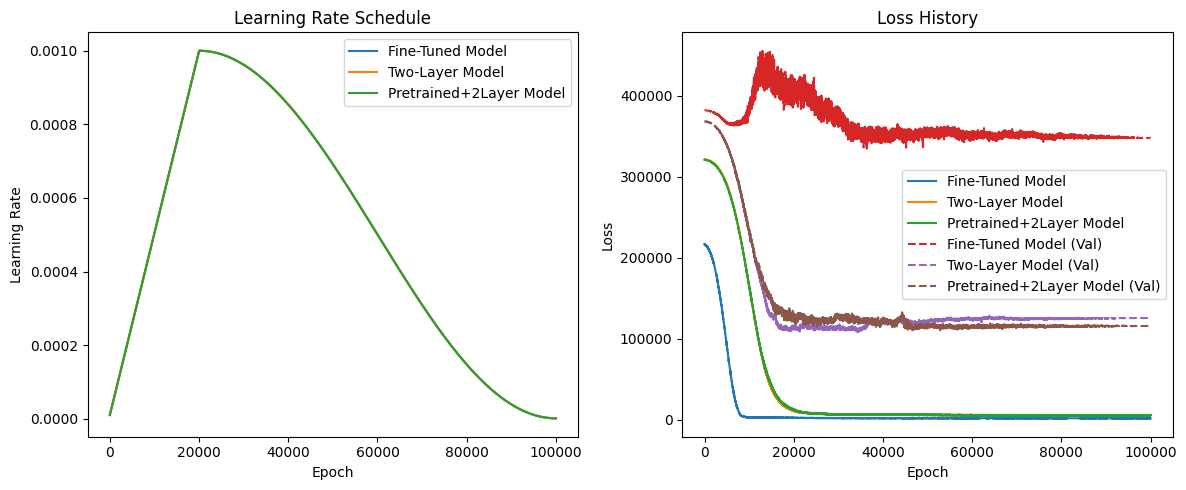

In [305]:
# Visualize and compare the learning rate schedules
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lr_history_fine, label='Fine-Tuned Model')
plt.plot(lr_history_two, label='Two-Layer Model')   
plt.plot(lr_history_pre2, label='Pretrained+2Layer Model')
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history_fine, label='Fine-Tuned Model')
plt.plot(train_loss_history_two, label='Two-Layer Model')
plt.plot(train_loss_history_pre2, label='Pretrained+2Layer Model')
plt.plot(val_loss_history_fine, label='Fine-Tuned Model (Val)', linestyle='dashed')
plt.plot(val_loss_history_two, label='Two-Layer Model (Val)', linestyle='dashed')
plt.plot(val_loss_history_pre2, label='Pretrained+2Layer Model (Val)', linestyle='dashed')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


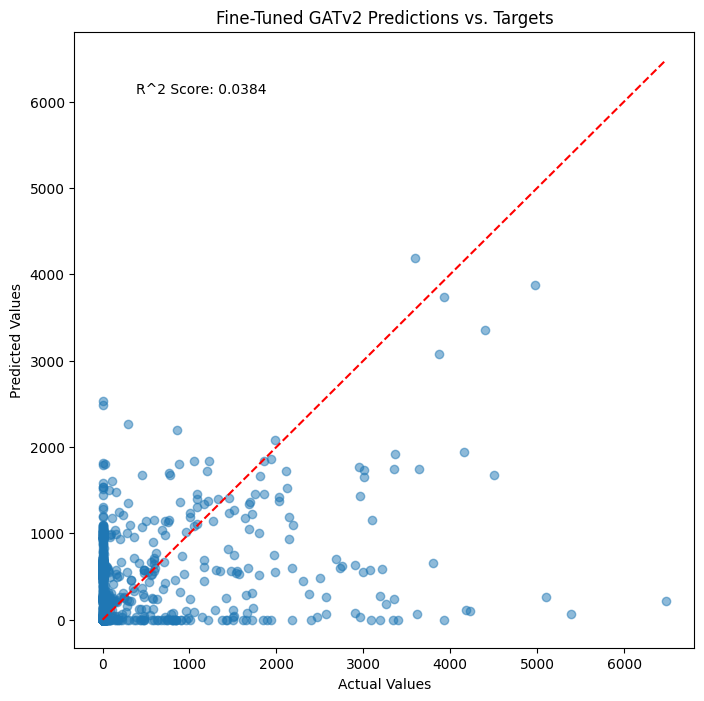

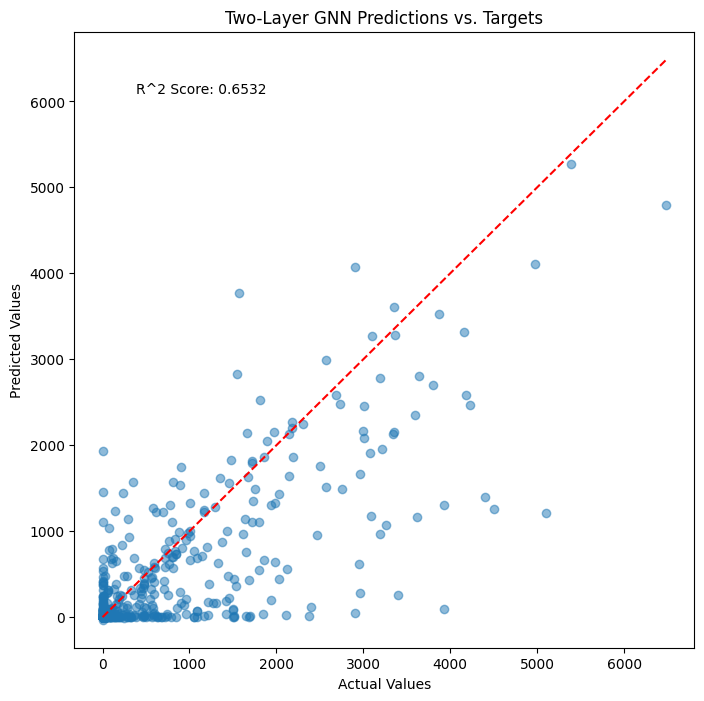

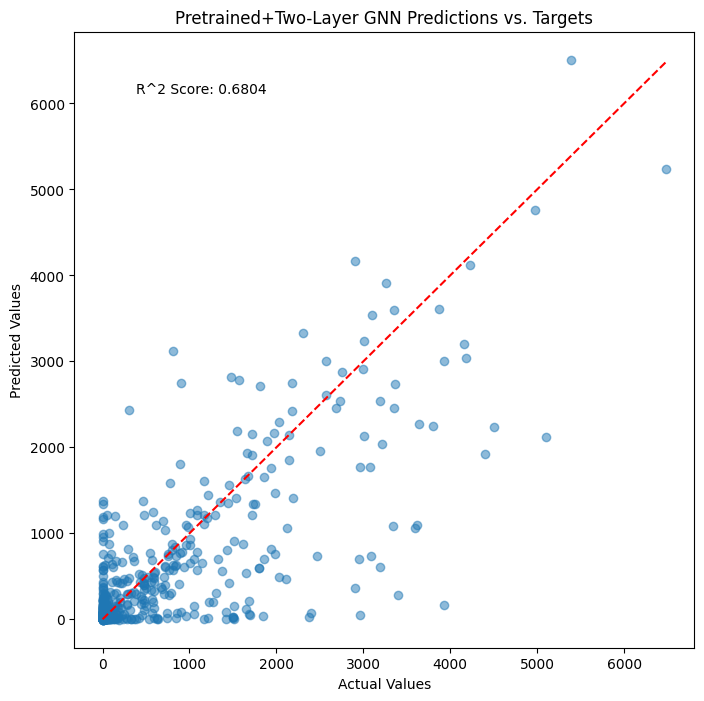

In [308]:
# Visualize the predicted validation vs actual values with the r squared value
from sklearn.metrics import r2_score

def visualize_predictions(predictions, targets, title="Predictions vs. Targets"):
    plt.figure(figsize=(8, 8))
    plt.scatter(targets, predictions, alpha=0.5)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)

    r2 = r2_score(targets, predictions)
    plt.text(0.1, 0.9, f"R^2 Score: {r2:.4f}", transform=plt.gca().transAxes)
    plt.show()

# Extract validation predictions
val_predictions_fine = fine_tuned_model(data)[data.val_mask].cpu().detach().numpy().flatten()
val_predictions_two = two_layer_model(data)[data.val_mask].cpu().detach().numpy().flatten()
val_predictions_pre2 = pretrained_plus_two_layer_model(data)[data.val_mask].cpu().detach().numpy().flatten()

# Extract validation targets
val_targets = data.y[data.val_mask].cpu().detach().numpy().flatten()

# Visualize predictions
visualize_predictions(val_predictions_fine, val_targets, title="Fine-Tuned GATv2 Predictions vs. Targets")
visualize_predictions(val_predictions_two, val_targets, title="Two-Layer GNN Predictions vs. Targets")
visualize_predictions(val_predictions_pre2, val_targets, title="Pretrained+Two-Layer GNN Predictions vs. Targets")


# Evaluate the usage of the embedding of the output

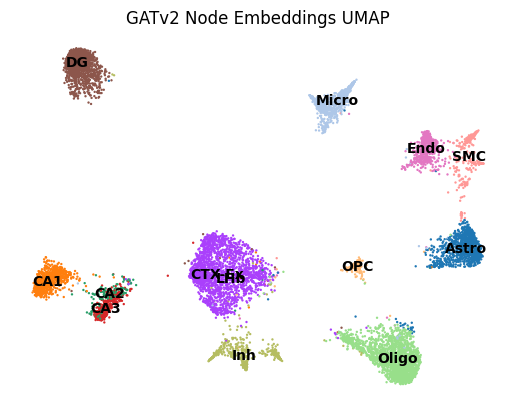

In [329]:
import torch
import scanpy as sc

# Ensure reproducibility and consistency
torch.manual_seed(0)

# Set the model to evaluation mode
model.eval()

# Disable gradient computations for inference
with torch.no_grad():
    # Extract embeddings using the model's forward or encode method
    # Replace `model.encode` with the appropriate method if different
    embeddings = model.encoders[1](model.encoders[0](data.x, data.edge_index, data.edge_attr),
                                  data.edge_index, data.edge_attr)

# Move embeddings to CPU and convert to NumPy array
embeddings_np = embeddings.cpu().numpy()

# Create a copy of the AnnData object
adata_sample = adatas['13months-disease-replicate_1'].copy()

# Verify that the number of embeddings matches the number of observations
assert embeddings_np.shape[0] == adata_sample.n_obs, (
    f"Number of embeddings ({embeddings_np.shape[0]}) does not match number of observations "
    f"({adata_sample.n_obs}) in AnnData."
)

# Add the embeddings to the AnnData object
adata_sample.obsm["GATv2_Embeddings"] = embeddings_np

# Compute the neighborhood graph using the embeddings
sc.pp.neighbors(adata_sample, use_rep='GATv2_Embeddings', n_neighbors=15)

# Perform UMAP dimensionality reduction
sc.tl.umap(adata_sample)

# Plot the UMAP, coloring by a specific cell type
sc.pl.umap(
    adata_sample,
    color='top_level_cell_type_x',
    title='GATv2 Node Embeddings UMAP',
    frameon=False,
    legend_loc='on data'
)


In [225]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 40930], edge_attr=[40930, 1], y=[8186, 1], pos=[8186, 2], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 51860], edge_attr=[51860, 1], y=[10372, 1], pos=[10372, 2], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 41010], edge_attr=[41010, 1], y=[8202, 1], pos=[8202, 2], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 48170], edge_attr=[48170, 1], y=[9634, 1], pos=[9634, 2], patches=[9634, 128, 128, 1])}

# Positive pathces prediction model

In [352]:
# ------------------------------------------------------------------
# 10. Initialize Models
# ------------------------------------------------------------------

# A) Fine-Tuned Model (original NodeValuePredictor)
fine_tuned_model_pos_pre = NodeValuePredictor(
    in_features=in_features,
    hidden_channels=hidden_channels,
    edge_dim=edge_dim,
    heads=heads,
    num_encoders=num_encoders,
    dropout=dropout,
    out_dim=1
).to(device)
fine_tuned_model_pos_pre.load_encoder_weights(masked_pre_model)
fine_tuned_model_pos_pre.train()

# B) Simple Two-Layer GNN Model
two_layer_model_pos_pre = SimpleTwoLayerGNNValuePredictor(
    in_features=in_features,
    hidden_channels=hidden_channels,
    out_dim=1,
    dropout=dropout,
    with_residual=True
).to(device)
two_layer_model_pos_pre.train()

# C) Pretrained + Two-Layer GNN
pretrained_plus_two_layer_model_pos_pre = PretrainedAndTwoLayerGNNValuePredictor(
    in_features=in_features,
    hidden_channels=hidden_channels,
    edge_dim=edge_dim,
    heads=heads,
    num_encoders=num_encoders,
    dropout=dropout,
    out_dim=1,
    with_residual=True
).to(device)
pretrained_plus_two_layer_model_pos_pre.load_encoder_weights(masked_pre_model)
pretrained_plus_two_layer_model_pos_pre.train()


PretrainedAndTwoLayerGNNValuePredictor(
  (encoders): ModuleList(
    (0): GATv2EncoderLayer(
      (gatv2): GATv2Conv(2766, 64, heads=4)
      (heads_transform): Linear(in_features=256, out_features=64, bias=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm(256, affine=True, mode=graph)
      (norm2): LayerNorm(64, affine=True, mode=graph)
      (dropout): Dropout(p=0.2, inplace=False)
      (activation): GELU(approximate='none')
    )
    (1): GATv2EncoderLayer(
      (gatv2): GATv2Conv(64, 64, heads=4)
      (heads_transform): Linear(in_features=256, out_features=64, bias=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm(256, aff

In [355]:
data.binary_y = data.y.clone()
data.binary_y[data.y > 0] = 1

In [357]:
# Create validation and train masks for binary classification

# Total number of nodes
num_nodes = data.num_nodes

# Define split ratio
train_ratio = 0.8
val_ratio = 0.2

# Ensure that train_ratio + val_ratio == 1
assert train_ratio + val_ratio == 1.0, "Train and validation ratios must sum to 1."

# Generate shuffled indices
indices = torch.randperm(num_nodes).tolist()

# Calculate split sizes
train_size = int(train_ratio * num_nodes)
val_size = num_nodes - train_size

# Split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
val_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)

train_mask[train_indices] = True
val_mask[val_indices] = True

# Assign masks to the data object
data.train_mask = train_mask
data.val_mask = val_mask


In [ ]:
# ------------------------------------------------------------------
# 11. Define Warmup + Cosine Annealing for each model
# ------------------------------------------------------------------
warmup_epochs = 2000
total_epochs = 10000
initial_lr = 1e-3
warmup_lr = 1e-5
eta_min = 1e-6

optimizer_fine_tuned = Adam(fine_tuned_model_pos_pre.parameters(), lr=warmup_lr)
scheduler_fine_tuned = CosineAnnealingLR(
    optimizer_fine_tuned,
    T_max=total_epochs - warmup_epochs,
    eta_min=eta_min
)

optimizer_two_layer = Adam(two_layer_model_pos_pre.parameters(), lr=warmup_lr)
scheduler_two_layer = CosineAnnealingLR(
    optimizer_two_layer,
    T_max=total_epochs - warmup_epochs,
    eta_min=eta_min
)

optimizer_pretrained_plus = Adam(pretrained_plus_two_layer_model.parameters(), lr=warmup_lr)
scheduler_pretrained_plus = CosineAnnealingLR(
    optimizer_pretrained_plus,
    T_max=total_epochs - warmup_epochs,
    eta_min=eta_min
)

criterion = nn.BCEWithLogitsLoss()

# Track losses and learning rates
train_loss_history_fine = []
val_loss_history_fine = []
lr_history_fine = []

train_loss_history_two = []
val_loss_history_two = []
lr_history_two = []

train_loss_history_pre2 = []
val_loss_history_pre2 = []
lr_history_pre2 = []

# For smoothing
smoothing_factor = 0.9
smoothed_train_loss_fine = None
smoothed_train_loss_two = None
smoothed_train_loss_pre2 = None

# ------------------------------------------------------------------
# 12. Training Loop (all three models in parallel)
# ------------------------------------------------------------------
for epoch in tqdm(range(1, total_epochs + 1), desc="Training All Models", leave=True):

    # -------------------------------------------------
    # 12a. Train Model A (Fine-Tuned GATv2)
    # -------------------------------------------------
    fine_tuned_model_pos_pre.train()
    optimizer_fine_tuned.zero_grad()

    # Warmup or Scheduler
    if epoch <= warmup_epochs:
        lr_inc = (initial_lr - warmup_lr) / warmup_epochs
        current_lr_fine = warmup_lr + lr_inc * epoch
        for param_group in optimizer_fine_tuned.param_groups:
            param_group['lr'] = current_lr_fine
    else:
        scheduler_fine_tuned.step()
        current_lr_fine = optimizer_fine_tuned.param_groups[0]['lr']
    lr_history_fine.append(current_lr_fine)

    # Forward
    predictions_fine = fine_tuned_model_pos_pre(data)
    loss_fine = criterion(
        predictions_fine[data.train_mask].view(-1),
        data.binary_y[data.train_mask].view(-1).float()
    )
    loss_fine.backward()
    torch.nn.utils.clip_grad_norm_(fine_tuned_model_pos_pre.parameters(), max_norm=1.0)
    optimizer_fine_tuned.step()

    # Smooth training loss
    avg_train_loss_fine = loss_fine.item()
    if smoothed_train_loss_fine is None:
        smoothed_train_loss_fine = avg_train_loss_fine
    else:
        smoothed_train_loss_fine = smoothing_factor * smoothed_train_loss_fine + \
                                   (1 - smoothing_factor) * avg_train_loss_fine
    train_loss_history_fine.append(smoothed_train_loss_fine)

    # Validation
    fine_tuned_model_pos_pre.eval()
    with torch.no_grad():
        val_predictions_fine = fine_tuned_model_pos_pre(data)
        val_loss_fine = criterion(
            val_predictions_fine[data.val_mask].view(-1),
            data.binary_y[data.val_mask].view(-1).float()
        )
    val_loss_history_fine.append(val_loss_fine.item())

    # -------------------------------------------------
    # 12b. Train Model B (Two-Layer GNN)
    # -------------------------------------------------
    two_layer_model.train()
    optimizer_two_layer.zero_grad()

    if epoch <= warmup_epochs:
        lr_inc = (initial_lr - warmup_lr) / warmup_epochs
        current_lr_two = warmup_lr + lr_inc * epoch
        for param_group in optimizer_two_layer.param_groups:
            param_group['lr'] = current_lr_two
    else:
        scheduler_two_layer.step()
        current_lr_two = optimizer_two_layer.param_groups[0]['lr']
    lr_history_two.append(current_lr_two)

    predictions_two = two_layer_model_pos_pre(data)
    loss_two = criterion(
        predictions_two[data.train_mask].view(-1),
        data.binary_y[data.train_mask].view(-1).float()
    )
    loss_two.backward()
    torch.nn.utils.clip_grad_norm_(pretrained_plus_two_layer_model_pos_pre.parameters(), max_norm=1.0)
    optimizer_two_layer.step()

    avg_train_loss_two = loss_two.item()
    if smoothed_train_loss_two is None:
        smoothed_train_loss_two = avg_train_loss_two
    else:
        smoothed_train_loss_two = smoothing_factor * smoothed_train_loss_two + \
                                  (1 - smoothing_factor) * avg_train_loss_two
    train_loss_history_two.append(smoothed_train_loss_two)

    pretrained_plus_two_layer_model_pos_pre.eval()
    with torch.no_grad():
        val_predictions_two = pretrained_plus_two_layer_model_pos_pre(data)
        val_loss_two = criterion(
            val_predictions_two[data.val_mask].view(-1),
            data.binary_y[data.val_mask].view(-1).float()
        )
    val_loss_history_two.append(val_loss_two.item())

    # -------------------------------------------------
    # 12c. Train Model C (Pretrained + Two-Layer GNN)
    # -------------------------------------------------
    pretrained_plus_two_layer_model_pos_pre.train()
    optimizer_pretrained_plus.zero_grad()

    if epoch <= warmup_epochs:
        lr_inc = (initial_lr - warmup_lr) / warmup_epochs
        current_lr_pre2 = warmup_lr + lr_inc * epoch
        for param_group in optimizer_pretrained_plus.param_groups:
            param_group['lr'] = current_lr_pre2
    else:
        scheduler_pretrained_plus.step()
        current_lr_pre2 = optimizer_pretrained_plus.param_groups[0]['lr']
    lr_history_pre2.append(current_lr_pre2)

    predictions_pre2 = pretrained_plus_two_layer_model_pos_pre(data)
    loss_pre2 = criterion(
        predictions_pre2[data.train_mask].view(-1),
        data.binary_y[data.train_mask].view(-1).float()
    )
    loss_pre2.backward()
    torch.nn.utils.clip_grad_norm_(pretrained_plus_two_layer_model_pos_pre.parameters(), max_norm=1.0)
    optimizer_pretrained_plus.step()

    avg_train_loss_pre2 = loss_pre2.item()
    if smoothed_train_loss_pre2 is None:
        smoothed_train_loss_pre2 = avg_train_loss_pre2
    else:
        smoothed_train_loss_pre2 = smoothing_factor * smoothed_train_loss_pre2 + \
                                   (1 - smoothing_factor) * avg_train_loss_pre2
    train_loss_history_pre2.append(smoothed_train_loss_pre2)

    pretrained_plus_two_layer_model_pos_pre.eval()
    with torch.no_grad():
        val_predictions_pre2 = pretrained_plus_two_layer_model_pos_pre(data)
        val_loss_pre2 = criterion(
            val_predictions_pre2[data.val_mask].view(-1),
            data.binary_y[data.val_mask].view(-1).float()
        )
    val_loss_history_pre2.append(val_loss_pre2.item())

    # -------------------------------------------------
    # 12d. Print Progress
    # -------------------------------------------------
    if epoch % 50 == 0:
        tqdm.write(
            f"Epoch [{epoch}/{total_epochs}]\n"
            f"    [A: Fine-Tuned GATv2]  "
            f"Train Loss: {smoothed_train_loss_fine:.6f}, "
            f"Val Loss: {val_loss_fine.item():.6f}, "
            f"LR: {current_lr_fine:.6f}\n"
            f"    [B: Two-Layer GNN]     "
            f"Train Loss: {smoothed_train_loss_two:.6f}, "
            f"Val Loss: {val_loss_two.item():.6f}, "
            f"LR: {current_lr_two:.6f}\n"
            f"    [C: Pretrained+2Layer] "
            f"Train Loss: {smoothed_train_loss_pre2:.6f}, "
            f"Val Loss: {val_loss_pre2.item():.6f}, "
            f"LR: {current_lr_pre2:.6f}\n"
        )

# ------------------------------------------------------------------
# 13. Results and Comparison
# ------------------------------------------------------------------
print("Training finished.")
print("--------------------------------------------------------")
print("[A: Fine-Tuned GATv2] Final Val Loss :", val_loss_history_fine[-1])
print("[B: Two-Layer GNN]    Final Val Loss :", val_loss_history_two[-1])
print("[C: Pretrained+2Layer] Final Val Loss:", val_loss_history_pre2[-1])

Training All Models:   1%|          | 53/10000 [00:03<10:01, 16.55it/s]

Epoch [50/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.714435, Val Loss: 0.664403, LR: 0.000035
    [B: Two-Layer GNN]     Train Loss: 0.620596, Val Loss: 0.643971, LR: 0.000035
    [C: Pretrained+2Layer] Train Loss: 0.660559, Val Loss: 0.643971, LR: 0.000035



Training All Models:   1%|          | 103/10000 [00:06<10:51, 15.18it/s]

Epoch [100/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.519737, Val Loss: 0.462301, LR: 0.000060
    [B: Two-Layer GNN]     Train Loss: 0.539087, Val Loss: 0.643971, LR: 0.000060
    [C: Pretrained+2Layer] Train Loss: 0.660235, Val Loss: 0.643971, LR: 0.000060



Training All Models:   2%|▏         | 153/10000 [00:09<09:57, 16.49it/s]

Epoch [150/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.371653, Val Loss: 0.340940, LR: 0.000084
    [B: Two-Layer GNN]     Train Loss: 0.472384, Val Loss: 0.643971, LR: 0.000084
    [C: Pretrained+2Layer] Train Loss: 0.660496, Val Loss: 0.643971, LR: 0.000084



Training All Models:   2%|▏         | 204/10000 [00:12<08:09, 20.00it/s]

Epoch [200/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.299553, Val Loss: 0.312825, LR: 0.000109
    [B: Two-Layer GNN]     Train Loss: 0.419100, Val Loss: 0.643971, LR: 0.000109
    [C: Pretrained+2Layer] Train Loss: 0.660053, Val Loss: 0.643971, LR: 0.000109



Training All Models:   3%|▎         | 252/10000 [00:14<07:35, 21.40it/s]

Epoch [250/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.265503, Val Loss: 0.312811, LR: 0.000134
    [B: Two-Layer GNN]     Train Loss: 0.368830, Val Loss: 0.643971, LR: 0.000134
    [C: Pretrained+2Layer] Train Loss: 0.660227, Val Loss: 0.643971, LR: 0.000134



Training All Models:   3%|▎         | 303/10000 [00:17<07:32, 21.41it/s]

Epoch [300/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.244454, Val Loss: 0.319215, LR: 0.000159
    [B: Two-Layer GNN]     Train Loss: 0.329856, Val Loss: 0.643971, LR: 0.000159
    [C: Pretrained+2Layer] Train Loss: 0.660016, Val Loss: 0.643971, LR: 0.000159



Training All Models:   4%|▎         | 354/10000 [00:19<07:30, 21.43it/s]

Epoch [350/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.229869, Val Loss: 0.331145, LR: 0.000183
    [B: Two-Layer GNN]     Train Loss: 0.302907, Val Loss: 0.643971, LR: 0.000183
    [C: Pretrained+2Layer] Train Loss: 0.660158, Val Loss: 0.643971, LR: 0.000183



Training All Models:   4%|▍         | 402/10000 [00:21<07:29, 21.36it/s]

Epoch [400/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.218898, Val Loss: 0.341194, LR: 0.000208
    [B: Two-Layer GNN]     Train Loss: 0.282706, Val Loss: 0.643971, LR: 0.000208
    [C: Pretrained+2Layer] Train Loss: 0.660288, Val Loss: 0.643971, LR: 0.000208



Training All Models:   5%|▍         | 453/10000 [00:24<07:25, 21.41it/s]

Epoch [450/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.212298, Val Loss: 0.348832, LR: 0.000233
    [B: Two-Layer GNN]     Train Loss: 0.267506, Val Loss: 0.643971, LR: 0.000233
    [C: Pretrained+2Layer] Train Loss: 0.661004, Val Loss: 0.643971, LR: 0.000233



Training All Models:   5%|▌         | 504/10000 [00:26<07:22, 21.45it/s]

Epoch [500/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.205778, Val Loss: 0.362685, LR: 0.000258
    [B: Two-Layer GNN]     Train Loss: 0.255342, Val Loss: 0.643971, LR: 0.000258
    [C: Pretrained+2Layer] Train Loss: 0.660690, Val Loss: 0.643971, LR: 0.000258



Training All Models:   6%|▌         | 552/10000 [00:28<07:21, 21.38it/s]

Epoch [550/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.201518, Val Loss: 0.380411, LR: 0.000282
    [B: Two-Layer GNN]     Train Loss: 0.245632, Val Loss: 0.643971, LR: 0.000282
    [C: Pretrained+2Layer] Train Loss: 0.660515, Val Loss: 0.643971, LR: 0.000282



Training All Models:   6%|▌         | 603/10000 [00:31<07:18, 21.44it/s]

Epoch [600/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.197762, Val Loss: 0.394012, LR: 0.000307
    [B: Two-Layer GNN]     Train Loss: 0.237359, Val Loss: 0.643971, LR: 0.000307
    [C: Pretrained+2Layer] Train Loss: 0.660202, Val Loss: 0.643971, LR: 0.000307



Training All Models:   7%|▋         | 654/10000 [00:33<07:16, 21.42it/s]

Epoch [650/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.194579, Val Loss: 0.402082, LR: 0.000332
    [B: Two-Layer GNN]     Train Loss: 0.231843, Val Loss: 0.643971, LR: 0.000332
    [C: Pretrained+2Layer] Train Loss: 0.659990, Val Loss: 0.643971, LR: 0.000332



Training All Models:   7%|▋         | 702/10000 [00:35<07:14, 21.39it/s]

Epoch [700/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.192063, Val Loss: 0.405202, LR: 0.000357
    [B: Two-Layer GNN]     Train Loss: 0.225042, Val Loss: 0.643971, LR: 0.000357
    [C: Pretrained+2Layer] Train Loss: 0.660489, Val Loss: 0.643971, LR: 0.000357



Training All Models:   8%|▊         | 753/10000 [00:37<07:11, 21.43it/s]

Epoch [750/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.189747, Val Loss: 0.421773, LR: 0.000381
    [B: Two-Layer GNN]     Train Loss: 0.219578, Val Loss: 0.643971, LR: 0.000381
    [C: Pretrained+2Layer] Train Loss: 0.660512, Val Loss: 0.643971, LR: 0.000381



Training All Models:   8%|▊         | 804/10000 [00:40<07:09, 21.39it/s]

Epoch [800/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.186722, Val Loss: 0.441450, LR: 0.000406
    [B: Two-Layer GNN]     Train Loss: 0.215621, Val Loss: 0.643971, LR: 0.000406
    [C: Pretrained+2Layer] Train Loss: 0.660169, Val Loss: 0.643971, LR: 0.000406



Training All Models:   9%|▊         | 852/10000 [00:42<07:07, 21.39it/s]

Epoch [850/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.185249, Val Loss: 0.454305, LR: 0.000431
    [B: Two-Layer GNN]     Train Loss: 0.213406, Val Loss: 0.643971, LR: 0.000431
    [C: Pretrained+2Layer] Train Loss: 0.660026, Val Loss: 0.643971, LR: 0.000431



Training All Models:   9%|▉         | 903/10000 [00:44<07:04, 21.42it/s]

Epoch [900/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.184187, Val Loss: 0.462407, LR: 0.000456
    [B: Two-Layer GNN]     Train Loss: 0.210978, Val Loss: 0.643971, LR: 0.000456
    [C: Pretrained+2Layer] Train Loss: 0.660349, Val Loss: 0.643971, LR: 0.000456



Training All Models:  10%|▉         | 954/10000 [00:47<07:05, 21.24it/s]

Epoch [950/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.183112, Val Loss: 0.479068, LR: 0.000480
    [B: Two-Layer GNN]     Train Loss: 0.206198, Val Loss: 0.643971, LR: 0.000480
    [C: Pretrained+2Layer] Train Loss: 0.660684, Val Loss: 0.643971, LR: 0.000480



Training All Models:  10%|█         | 1002/10000 [00:49<07:01, 21.35it/s]

Epoch [1000/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.182833, Val Loss: 0.488789, LR: 0.000505
    [B: Two-Layer GNN]     Train Loss: 0.204556, Val Loss: 0.643971, LR: 0.000505
    [C: Pretrained+2Layer] Train Loss: 0.660349, Val Loss: 0.643971, LR: 0.000505



Training All Models:  11%|█         | 1053/10000 [00:51<06:57, 21.43it/s]

Epoch [1050/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.181981, Val Loss: 0.489524, LR: 0.000530
    [B: Two-Layer GNN]     Train Loss: 0.202671, Val Loss: 0.643971, LR: 0.000530
    [C: Pretrained+2Layer] Train Loss: 0.660223, Val Loss: 0.643971, LR: 0.000530



Training All Models:  11%|█         | 1104/10000 [00:54<06:54, 21.44it/s]

Epoch [1100/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.179368, Val Loss: 0.515039, LR: 0.000555
    [B: Two-Layer GNN]     Train Loss: 0.202332, Val Loss: 0.643971, LR: 0.000555
    [C: Pretrained+2Layer] Train Loss: 0.660252, Val Loss: 0.643971, LR: 0.000555



Training All Models:  12%|█▏        | 1152/10000 [00:56<06:52, 21.43it/s]

Epoch [1150/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.179223, Val Loss: 0.517456, LR: 0.000579
    [B: Two-Layer GNN]     Train Loss: 0.198069, Val Loss: 0.643971, LR: 0.000579
    [C: Pretrained+2Layer] Train Loss: 0.660430, Val Loss: 0.643971, LR: 0.000579



Training All Models:  12%|█▏        | 1203/10000 [00:58<06:50, 21.45it/s]

Epoch [1200/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.178230, Val Loss: 0.528991, LR: 0.000604
    [B: Two-Layer GNN]     Train Loss: 0.196596, Val Loss: 0.643971, LR: 0.000604
    [C: Pretrained+2Layer] Train Loss: 0.660055, Val Loss: 0.643971, LR: 0.000604



Training All Models:  13%|█▎        | 1254/10000 [01:01<06:47, 21.44it/s]

Epoch [1250/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.178699, Val Loss: 0.532104, LR: 0.000629
    [B: Two-Layer GNN]     Train Loss: 0.194313, Val Loss: 0.643971, LR: 0.000629
    [C: Pretrained+2Layer] Train Loss: 0.660295, Val Loss: 0.643971, LR: 0.000629



Training All Models:  13%|█▎        | 1302/10000 [01:03<06:46, 21.40it/s]

Epoch [1300/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.177450, Val Loss: 0.554672, LR: 0.000654
    [B: Two-Layer GNN]     Train Loss: 0.197397, Val Loss: 0.643971, LR: 0.000654
    [C: Pretrained+2Layer] Train Loss: 0.661167, Val Loss: 0.643971, LR: 0.000654



Training All Models:  14%|█▎        | 1353/10000 [01:05<06:42, 21.47it/s]

Epoch [1350/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.176473, Val Loss: 0.564720, LR: 0.000678
    [B: Two-Layer GNN]     Train Loss: 0.194846, Val Loss: 0.643971, LR: 0.000678
    [C: Pretrained+2Layer] Train Loss: 0.660660, Val Loss: 0.643971, LR: 0.000678



Training All Models:  14%|█▍        | 1404/10000 [01:08<06:40, 21.46it/s]

Epoch [1400/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.176035, Val Loss: 0.568621, LR: 0.000703
    [B: Two-Layer GNN]     Train Loss: 0.190962, Val Loss: 0.643971, LR: 0.000703
    [C: Pretrained+2Layer] Train Loss: 0.660376, Val Loss: 0.643971, LR: 0.000703



Training All Models:  15%|█▍        | 1452/10000 [01:10<06:39, 21.40it/s]

Epoch [1450/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.175872, Val Loss: 0.582758, LR: 0.000728
    [B: Two-Layer GNN]     Train Loss: 0.189475, Val Loss: 0.643971, LR: 0.000728
    [C: Pretrained+2Layer] Train Loss: 0.660961, Val Loss: 0.643971, LR: 0.000728



Training All Models:  15%|█▌        | 1503/10000 [01:12<06:36, 21.43it/s]

Epoch [1500/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.175374, Val Loss: 0.595930, LR: 0.000753
    [B: Two-Layer GNN]     Train Loss: 0.189736, Val Loss: 0.643971, LR: 0.000753
    [C: Pretrained+2Layer] Train Loss: 0.660386, Val Loss: 0.643971, LR: 0.000753



Training All Models:  16%|█▌        | 1554/10000 [01:15<06:33, 21.44it/s]

Epoch [1550/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.174721, Val Loss: 0.593231, LR: 0.000777
    [B: Two-Layer GNN]     Train Loss: 0.190891, Val Loss: 0.643971, LR: 0.000777
    [C: Pretrained+2Layer] Train Loss: 0.660406, Val Loss: 0.643971, LR: 0.000777



Training All Models:  16%|█▌        | 1602/10000 [01:17<06:32, 21.37it/s]

Epoch [1600/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.174718, Val Loss: 0.603319, LR: 0.000802
    [B: Two-Layer GNN]     Train Loss: 0.186043, Val Loss: 0.643971, LR: 0.000802
    [C: Pretrained+2Layer] Train Loss: 0.660775, Val Loss: 0.643971, LR: 0.000802



Training All Models:  17%|█▋        | 1653/10000 [01:19<06:29, 21.42it/s]

Epoch [1650/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.174690, Val Loss: 0.581964, LR: 0.000827
    [B: Two-Layer GNN]     Train Loss: 0.185003, Val Loss: 0.643971, LR: 0.000827
    [C: Pretrained+2Layer] Train Loss: 0.659978, Val Loss: 0.643971, LR: 0.000827



Training All Models:  17%|█▋        | 1704/10000 [01:22<06:27, 21.44it/s]

Epoch [1700/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.173873, Val Loss: 0.589159, LR: 0.000852
    [B: Two-Layer GNN]     Train Loss: 0.183571, Val Loss: 0.643971, LR: 0.000852
    [C: Pretrained+2Layer] Train Loss: 0.660031, Val Loss: 0.643971, LR: 0.000852



Training All Models:  18%|█▊        | 1752/10000 [01:24<06:26, 21.36it/s]

Epoch [1750/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.173636, Val Loss: 0.605013, LR: 0.000876
    [B: Two-Layer GNN]     Train Loss: 0.185983, Val Loss: 0.643971, LR: 0.000876
    [C: Pretrained+2Layer] Train Loss: 0.661199, Val Loss: 0.643971, LR: 0.000876



Training All Models:  18%|█▊        | 1803/10000 [01:26<06:22, 21.43it/s]

Epoch [1800/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.172818, Val Loss: 0.615950, LR: 0.000901
    [B: Two-Layer GNN]     Train Loss: 0.184574, Val Loss: 0.643971, LR: 0.000901
    [C: Pretrained+2Layer] Train Loss: 0.659742, Val Loss: 0.643971, LR: 0.000901



Training All Models:  19%|█▊        | 1854/10000 [01:29<06:20, 21.42it/s]

Epoch [1850/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.172995, Val Loss: 0.605674, LR: 0.000926
    [B: Two-Layer GNN]     Train Loss: 0.181886, Val Loss: 0.643971, LR: 0.000926
    [C: Pretrained+2Layer] Train Loss: 0.660855, Val Loss: 0.643971, LR: 0.000926



Training All Models:  19%|█▉        | 1902/10000 [01:31<06:18, 21.38it/s]

Epoch [1900/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.172007, Val Loss: 0.643014, LR: 0.000951
    [B: Two-Layer GNN]     Train Loss: 0.180303, Val Loss: 0.643971, LR: 0.000951
    [C: Pretrained+2Layer] Train Loss: 0.660068, Val Loss: 0.643971, LR: 0.000951



Training All Models:  20%|█▉        | 1953/10000 [01:33<06:15, 21.41it/s]

Epoch [1950/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.171577, Val Loss: 0.653008, LR: 0.000975
    [B: Two-Layer GNN]     Train Loss: 0.179768, Val Loss: 0.643971, LR: 0.000975
    [C: Pretrained+2Layer] Train Loss: 0.660066, Val Loss: 0.643971, LR: 0.000975



Training All Models:  20%|██        | 2004/10000 [01:36<06:13, 21.41it/s]

Epoch [2000/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.171005, Val Loss: 0.652127, LR: 0.001000
    [B: Two-Layer GNN]     Train Loss: 0.179056, Val Loss: 0.643971, LR: 0.001000
    [C: Pretrained+2Layer] Train Loss: 0.660276, Val Loss: 0.643971, LR: 0.001000



Training All Models:  21%|██        | 2052/10000 [01:38<06:11, 21.37it/s]

Epoch [2050/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.171111, Val Loss: 0.650763, LR: 0.001000
    [B: Two-Layer GNN]     Train Loss: 0.178145, Val Loss: 0.643971, LR: 0.001000
    [C: Pretrained+2Layer] Train Loss: 0.660801, Val Loss: 0.643971, LR: 0.001000



Training All Models:  21%|██        | 2103/10000 [01:40<06:09, 21.37it/s]

Epoch [2100/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.170483, Val Loss: 0.644691, LR: 0.001000
    [B: Two-Layer GNN]     Train Loss: 0.177107, Val Loss: 0.643971, LR: 0.001000
    [C: Pretrained+2Layer] Train Loss: 0.660650, Val Loss: 0.643971, LR: 0.001000



Training All Models:  22%|██▏       | 2154/10000 [01:43<06:05, 21.44it/s]

Epoch [2150/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.170293, Val Loss: 0.667112, LR: 0.000999
    [B: Two-Layer GNN]     Train Loss: 0.176640, Val Loss: 0.643971, LR: 0.000999
    [C: Pretrained+2Layer] Train Loss: 0.660290, Val Loss: 0.643971, LR: 0.000999



Training All Models:  22%|██▏       | 2202/10000 [01:45<06:04, 21.37it/s]

Epoch [2200/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.169961, Val Loss: 0.666512, LR: 0.000998
    [B: Two-Layer GNN]     Train Loss: 0.175738, Val Loss: 0.643971, LR: 0.000998
    [C: Pretrained+2Layer] Train Loss: 0.660497, Val Loss: 0.643971, LR: 0.000998



Training All Models:  23%|██▎       | 2253/10000 [01:47<06:01, 21.41it/s]

Epoch [2250/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.169255, Val Loss: 0.663830, LR: 0.000998
    [B: Two-Layer GNN]     Train Loss: 0.175111, Val Loss: 0.643971, LR: 0.000998
    [C: Pretrained+2Layer] Train Loss: 0.660143, Val Loss: 0.643971, LR: 0.000998



Training All Models:  23%|██▎       | 2304/10000 [01:50<05:59, 21.41it/s]

Epoch [2300/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.168966, Val Loss: 0.653416, LR: 0.000997
    [B: Two-Layer GNN]     Train Loss: 0.175086, Val Loss: 0.643971, LR: 0.000997
    [C: Pretrained+2Layer] Train Loss: 0.659371, Val Loss: 0.643971, LR: 0.000997



Training All Models:  24%|██▎       | 2352/10000 [01:52<05:58, 21.35it/s]

Epoch [2350/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.168356, Val Loss: 0.645997, LR: 0.000995
    [B: Two-Layer GNN]     Train Loss: 0.174402, Val Loss: 0.643971, LR: 0.000995
    [C: Pretrained+2Layer] Train Loss: 0.659623, Val Loss: 0.643971, LR: 0.000995



Training All Models:  24%|██▍       | 2403/10000 [01:54<05:54, 21.40it/s]

Epoch [2400/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.166864, Val Loss: 0.698111, LR: 0.000994
    [B: Two-Layer GNN]     Train Loss: 0.174067, Val Loss: 0.643971, LR: 0.000994
    [C: Pretrained+2Layer] Train Loss: 0.660755, Val Loss: 0.643971, LR: 0.000994



Training All Models:  25%|██▍       | 2454/10000 [01:57<05:52, 21.40it/s]

Epoch [2450/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.165946, Val Loss: 0.711705, LR: 0.000992
    [B: Two-Layer GNN]     Train Loss: 0.172515, Val Loss: 0.643971, LR: 0.000992
    [C: Pretrained+2Layer] Train Loss: 0.659794, Val Loss: 0.643971, LR: 0.000992



Training All Models:  25%|██▌       | 2502/10000 [01:59<05:50, 21.37it/s]

Epoch [2500/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.166403, Val Loss: 0.687212, LR: 0.000990
    [B: Two-Layer GNN]     Train Loss: 0.172567, Val Loss: 0.643971, LR: 0.000990
    [C: Pretrained+2Layer] Train Loss: 0.660079, Val Loss: 0.643971, LR: 0.000990



Training All Models:  26%|██▌       | 2553/10000 [02:01<05:47, 21.41it/s]

Epoch [2550/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.164288, Val Loss: 0.684401, LR: 0.000988
    [B: Two-Layer GNN]     Train Loss: 0.172198, Val Loss: 0.643971, LR: 0.000988
    [C: Pretrained+2Layer] Train Loss: 0.660377, Val Loss: 0.643971, LR: 0.000988



Training All Models:  26%|██▌       | 2604/10000 [02:04<05:45, 21.42it/s]

Epoch [2600/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.163936, Val Loss: 0.707503, LR: 0.000986
    [B: Two-Layer GNN]     Train Loss: 0.171469, Val Loss: 0.643971, LR: 0.000986
    [C: Pretrained+2Layer] Train Loss: 0.660498, Val Loss: 0.643971, LR: 0.000986



Training All Models:  27%|██▋       | 2652/10000 [02:06<05:43, 21.37it/s]

Epoch [2650/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.164390, Val Loss: 0.691419, LR: 0.000984
    [B: Two-Layer GNN]     Train Loss: 0.170914, Val Loss: 0.643971, LR: 0.000984
    [C: Pretrained+2Layer] Train Loss: 0.660727, Val Loss: 0.643971, LR: 0.000984



Training All Models:  27%|██▋       | 2703/10000 [02:08<05:40, 21.42it/s]

Epoch [2700/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.162917, Val Loss: 0.670230, LR: 0.000981
    [B: Two-Layer GNN]     Train Loss: 0.170173, Val Loss: 0.643971, LR: 0.000981
    [C: Pretrained+2Layer] Train Loss: 0.660538, Val Loss: 0.643971, LR: 0.000981



Training All Models:  28%|██▊       | 2754/10000 [02:11<05:38, 21.40it/s]

Epoch [2750/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.162762, Val Loss: 0.684551, LR: 0.000978
    [B: Two-Layer GNN]     Train Loss: 0.170131, Val Loss: 0.643971, LR: 0.000978
    [C: Pretrained+2Layer] Train Loss: 0.660574, Val Loss: 0.643971, LR: 0.000978



Training All Models:  28%|██▊       | 2802/10000 [02:13<05:36, 21.38it/s]

Epoch [2800/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.161030, Val Loss: 0.684081, LR: 0.000976
    [B: Two-Layer GNN]     Train Loss: 0.169867, Val Loss: 0.643971, LR: 0.000976
    [C: Pretrained+2Layer] Train Loss: 0.660723, Val Loss: 0.643971, LR: 0.000976



Training All Models:  29%|██▊       | 2853/10000 [02:15<05:33, 21.41it/s]

Epoch [2850/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.160454, Val Loss: 0.733775, LR: 0.000972
    [B: Two-Layer GNN]     Train Loss: 0.169388, Val Loss: 0.643971, LR: 0.000972
    [C: Pretrained+2Layer] Train Loss: 0.660840, Val Loss: 0.643971, LR: 0.000972



Training All Models:  29%|██▉       | 2904/10000 [02:18<05:31, 21.38it/s]

Epoch [2900/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.159658, Val Loss: 0.734017, LR: 0.000969
    [B: Two-Layer GNN]     Train Loss: 0.169056, Val Loss: 0.643971, LR: 0.000969
    [C: Pretrained+2Layer] Train Loss: 0.660219, Val Loss: 0.643971, LR: 0.000969



Training All Models:  30%|██▉       | 2952/10000 [02:20<05:30, 21.32it/s]

Epoch [2950/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.158616, Val Loss: 0.744171, LR: 0.000966
    [B: Two-Layer GNN]     Train Loss: 0.168826, Val Loss: 0.643971, LR: 0.000966
    [C: Pretrained+2Layer] Train Loss: 0.660921, Val Loss: 0.643971, LR: 0.000966



Training All Models:  30%|███       | 3003/10000 [02:22<05:26, 21.41it/s]

Epoch [3000/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.159189, Val Loss: 0.721364, LR: 0.000962
    [B: Two-Layer GNN]     Train Loss: 0.168608, Val Loss: 0.643971, LR: 0.000962
    [C: Pretrained+2Layer] Train Loss: 0.660266, Val Loss: 0.643971, LR: 0.000962



Training All Models:  31%|███       | 3054/10000 [02:25<05:24, 21.39it/s]

Epoch [3050/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.157174, Val Loss: 0.729639, LR: 0.000958
    [B: Two-Layer GNN]     Train Loss: 0.167502, Val Loss: 0.643971, LR: 0.000958
    [C: Pretrained+2Layer] Train Loss: 0.660116, Val Loss: 0.643971, LR: 0.000958



Training All Models:  31%|███       | 3102/10000 [02:27<05:22, 21.36it/s]

Epoch [3100/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.156991, Val Loss: 0.717564, LR: 0.000954
    [B: Two-Layer GNN]     Train Loss: 0.167618, Val Loss: 0.643971, LR: 0.000954
    [C: Pretrained+2Layer] Train Loss: 0.660481, Val Loss: 0.643971, LR: 0.000954



Training All Models:  32%|███▏      | 3153/10000 [02:29<05:19, 21.43it/s]

Epoch [3150/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.156308, Val Loss: 0.735913, LR: 0.000950
    [B: Two-Layer GNN]     Train Loss: 0.167584, Val Loss: 0.643971, LR: 0.000950
    [C: Pretrained+2Layer] Train Loss: 0.660132, Val Loss: 0.643971, LR: 0.000950



Training All Models:  32%|███▏      | 3204/10000 [02:32<05:17, 21.41it/s]

Epoch [3200/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.156069, Val Loss: 0.764898, LR: 0.000946
    [B: Two-Layer GNN]     Train Loss: 0.167604, Val Loss: 0.643971, LR: 0.000946
    [C: Pretrained+2Layer] Train Loss: 0.660248, Val Loss: 0.643971, LR: 0.000946



Training All Models:  33%|███▎      | 3252/10000 [02:34<05:15, 21.37it/s]

Epoch [3250/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.154912, Val Loss: 0.730569, LR: 0.000941
    [B: Two-Layer GNN]     Train Loss: 0.166675, Val Loss: 0.643971, LR: 0.000941
    [C: Pretrained+2Layer] Train Loss: 0.661210, Val Loss: 0.643971, LR: 0.000941



Training All Models:  33%|███▎      | 3303/10000 [02:36<05:12, 21.41it/s]

Epoch [3300/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.153849, Val Loss: 0.744003, LR: 0.000936
    [B: Two-Layer GNN]     Train Loss: 0.166437, Val Loss: 0.643971, LR: 0.000936
    [C: Pretrained+2Layer] Train Loss: 0.659865, Val Loss: 0.643971, LR: 0.000936



Training All Models:  34%|███▎      | 3354/10000 [02:39<05:10, 21.40it/s]

Epoch [3350/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.152761, Val Loss: 0.770720, LR: 0.000931
    [B: Two-Layer GNN]     Train Loss: 0.166501, Val Loss: 0.643971, LR: 0.000931
    [C: Pretrained+2Layer] Train Loss: 0.660272, Val Loss: 0.643971, LR: 0.000931



Training All Models:  34%|███▍      | 3402/10000 [02:41<05:09, 21.34it/s]

Epoch [3400/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.152191, Val Loss: 0.732627, LR: 0.000926
    [B: Two-Layer GNN]     Train Loss: 0.166469, Val Loss: 0.643971, LR: 0.000926
    [C: Pretrained+2Layer] Train Loss: 0.660919, Val Loss: 0.643971, LR: 0.000926



Training All Models:  35%|███▍      | 3453/10000 [02:43<05:05, 21.42it/s]

Epoch [3450/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.153172, Val Loss: 0.722375, LR: 0.000921
    [B: Two-Layer GNN]     Train Loss: 0.165564, Val Loss: 0.643971, LR: 0.000921
    [C: Pretrained+2Layer] Train Loss: 0.660671, Val Loss: 0.643971, LR: 0.000921



Training All Models:  35%|███▌      | 3504/10000 [02:46<05:03, 21.41it/s]

Epoch [3500/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.150770, Val Loss: 0.774063, LR: 0.000916
    [B: Two-Layer GNN]     Train Loss: 0.165913, Val Loss: 0.643971, LR: 0.000916
    [C: Pretrained+2Layer] Train Loss: 0.660623, Val Loss: 0.643971, LR: 0.000916



Training All Models:  36%|███▌      | 3552/10000 [02:48<05:01, 21.39it/s]

Epoch [3550/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.150530, Val Loss: 0.793402, LR: 0.000910
    [B: Two-Layer GNN]     Train Loss: 0.165560, Val Loss: 0.643971, LR: 0.000910
    [C: Pretrained+2Layer] Train Loss: 0.660022, Val Loss: 0.643971, LR: 0.000910



Training All Models:  63%|██████▎   | 6252/10000 [04:54<02:55, 21.38it/s]

Epoch [6250/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.135987, Val Loss: 0.949141, LR: 0.000452
    [B: Two-Layer GNN]     Train Loss: 0.157856, Val Loss: 0.643971, LR: 0.000452
    [C: Pretrained+2Layer] Train Loss: 0.660137, Val Loss: 0.643971, LR: 0.000452



Training All Models:  63%|██████▎   | 6303/10000 [04:56<02:52, 21.38it/s]

Epoch [6300/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.135474, Val Loss: 0.973431, LR: 0.000442
    [B: Two-Layer GNN]     Train Loss: 0.158111, Val Loss: 0.643971, LR: 0.000442
    [C: Pretrained+2Layer] Train Loss: 0.659968, Val Loss: 0.643971, LR: 0.000442



Training All Models:  64%|██████▎   | 6354/10000 [04:58<02:50, 21.40it/s]

Epoch [6350/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134456, Val Loss: 0.986617, LR: 0.000432
    [B: Two-Layer GNN]     Train Loss: 0.157735, Val Loss: 0.643971, LR: 0.000432
    [C: Pretrained+2Layer] Train Loss: 0.660498, Val Loss: 0.643971, LR: 0.000432



Training All Models:  64%|██████▍   | 6402/10000 [05:01<02:48, 21.30it/s]

Epoch [6400/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134710, Val Loss: 0.982473, LR: 0.000422
    [B: Two-Layer GNN]     Train Loss: 0.157990, Val Loss: 0.643971, LR: 0.000422
    [C: Pretrained+2Layer] Train Loss: 0.660311, Val Loss: 0.643971, LR: 0.000422



Training All Models:  65%|██████▍   | 6453/10000 [05:03<02:45, 21.41it/s]

Epoch [6450/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.135112, Val Loss: 0.996679, LR: 0.000413
    [B: Two-Layer GNN]     Train Loss: 0.157403, Val Loss: 0.643971, LR: 0.000413
    [C: Pretrained+2Layer] Train Loss: 0.660342, Val Loss: 0.643971, LR: 0.000413



Training All Models:  65%|██████▌   | 6504/10000 [05:05<02:43, 21.42it/s]

Epoch [6500/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134536, Val Loss: 1.006646, LR: 0.000403
    [B: Two-Layer GNN]     Train Loss: 0.157999, Val Loss: 0.643971, LR: 0.000403
    [C: Pretrained+2Layer] Train Loss: 0.660440, Val Loss: 0.643971, LR: 0.000403



Training All Models:  66%|██████▌   | 6552/10000 [05:08<02:41, 21.37it/s]

Epoch [6550/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.133977, Val Loss: 1.014375, LR: 0.000393
    [B: Two-Layer GNN]     Train Loss: 0.157447, Val Loss: 0.643971, LR: 0.000393
    [C: Pretrained+2Layer] Train Loss: 0.660373, Val Loss: 0.643971, LR: 0.000393



Training All Models:  66%|██████▌   | 6603/10000 [05:10<02:38, 21.42it/s]

Epoch [6600/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134408, Val Loss: 1.012360, LR: 0.000384
    [B: Two-Layer GNN]     Train Loss: 0.157330, Val Loss: 0.643971, LR: 0.000384
    [C: Pretrained+2Layer] Train Loss: 0.660463, Val Loss: 0.643971, LR: 0.000384



Training All Models:  67%|██████▋   | 6654/10000 [05:12<02:36, 21.40it/s]

Epoch [6650/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134453, Val Loss: 0.996435, LR: 0.000374
    [B: Two-Layer GNN]     Train Loss: 0.157418, Val Loss: 0.643971, LR: 0.000374
    [C: Pretrained+2Layer] Train Loss: 0.660027, Val Loss: 0.643971, LR: 0.000374



Training All Models:  67%|██████▋   | 6702/10000 [05:15<02:34, 21.39it/s]

Epoch [6700/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134219, Val Loss: 0.980568, LR: 0.000365
    [B: Two-Layer GNN]     Train Loss: 0.157321, Val Loss: 0.643971, LR: 0.000365
    [C: Pretrained+2Layer] Train Loss: 0.659966, Val Loss: 0.643971, LR: 0.000365



Training All Models:  68%|██████▊   | 6753/10000 [05:17<02:31, 21.40it/s]

Epoch [6750/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.133688, Val Loss: 0.976754, LR: 0.000356
    [B: Two-Layer GNN]     Train Loss: 0.157604, Val Loss: 0.643971, LR: 0.000356
    [C: Pretrained+2Layer] Train Loss: 0.660934, Val Loss: 0.643971, LR: 0.000356



Training All Models:  68%|██████▊   | 6804/10000 [05:19<02:29, 21.39it/s]

Epoch [6800/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.133731, Val Loss: 0.973023, LR: 0.000346
    [B: Two-Layer GNN]     Train Loss: 0.157420, Val Loss: 0.643971, LR: 0.000346
    [C: Pretrained+2Layer] Train Loss: 0.660205, Val Loss: 0.643971, LR: 0.000346



Training All Models:  69%|██████▊   | 6852/10000 [05:22<02:27, 21.37it/s]

Epoch [6850/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134085, Val Loss: 0.988798, LR: 0.000337
    [B: Two-Layer GNN]     Train Loss: 0.157682, Val Loss: 0.643971, LR: 0.000337
    [C: Pretrained+2Layer] Train Loss: 0.660389, Val Loss: 0.643971, LR: 0.000337



Training All Models:  69%|██████▉   | 6903/10000 [05:24<02:24, 21.40it/s]

Epoch [6900/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.133804, Val Loss: 1.001849, LR: 0.000328
    [B: Two-Layer GNN]     Train Loss: 0.157648, Val Loss: 0.643971, LR: 0.000328
    [C: Pretrained+2Layer] Train Loss: 0.660675, Val Loss: 0.643971, LR: 0.000328



Training All Models:  70%|██████▉   | 6954/10000 [05:26<02:22, 21.41it/s]

Epoch [6950/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134054, Val Loss: 0.987240, LR: 0.000318
    [B: Two-Layer GNN]     Train Loss: 0.157369, Val Loss: 0.643971, LR: 0.000318
    [C: Pretrained+2Layer] Train Loss: 0.660163, Val Loss: 0.643971, LR: 0.000318



Training All Models:  70%|███████   | 7002/10000 [05:29<02:20, 21.38it/s]

Epoch [7000/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.134267, Val Loss: 1.002194, LR: 0.000309
    [B: Two-Layer GNN]     Train Loss: 0.157096, Val Loss: 0.643971, LR: 0.000309
    [C: Pretrained+2Layer] Train Loss: 0.660303, Val Loss: 0.643971, LR: 0.000309



Training All Models:  71%|███████   | 7053/10000 [05:31<02:17, 21.43it/s]

Epoch [7050/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.133710, Val Loss: 1.030953, LR: 0.000300
    [B: Two-Layer GNN]     Train Loss: 0.157186, Val Loss: 0.643971, LR: 0.000300
    [C: Pretrained+2Layer] Train Loss: 0.659952, Val Loss: 0.643971, LR: 0.000300



Training All Models:  71%|███████   | 7104/10000 [05:33<02:15, 21.40it/s]

Epoch [7100/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.133041, Val Loss: 1.020041, LR: 0.000291
    [B: Two-Layer GNN]     Train Loss: 0.157771, Val Loss: 0.643971, LR: 0.000291
    [C: Pretrained+2Layer] Train Loss: 0.660610, Val Loss: 0.643971, LR: 0.000291



Training All Models:  72%|███████▏  | 7152/10000 [05:36<02:13, 21.38it/s]

Epoch [7150/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.133835, Val Loss: 1.007476, LR: 0.000283
    [B: Two-Layer GNN]     Train Loss: 0.157242, Val Loss: 0.643971, LR: 0.000283
    [C: Pretrained+2Layer] Train Loss: 0.660010, Val Loss: 0.643971, LR: 0.000283



Training All Models:  72%|███████▏  | 7203/10000 [05:38<02:10, 21.48it/s]

Epoch [7200/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.133111, Val Loss: 1.022083, LR: 0.000274
    [B: Two-Layer GNN]     Train Loss: 0.156801, Val Loss: 0.643971, LR: 0.000274
    [C: Pretrained+2Layer] Train Loss: 0.659980, Val Loss: 0.643971, LR: 0.000274



Training All Models:  73%|███████▎  | 7254/10000 [05:40<02:08, 21.37it/s]

Epoch [7250/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132977, Val Loss: 1.007177, LR: 0.000265
    [B: Two-Layer GNN]     Train Loss: 0.156993, Val Loss: 0.643971, LR: 0.000265
    [C: Pretrained+2Layer] Train Loss: 0.659812, Val Loss: 0.643971, LR: 0.000265



Training All Models:  73%|███████▎  | 7302/10000 [05:43<02:06, 21.40it/s]

Epoch [7300/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132696, Val Loss: 1.008104, LR: 0.000256
    [B: Two-Layer GNN]     Train Loss: 0.156395, Val Loss: 0.643971, LR: 0.000256
    [C: Pretrained+2Layer] Train Loss: 0.661358, Val Loss: 0.643971, LR: 0.000256



Training All Models:  74%|███████▎  | 7353/10000 [05:45<02:03, 21.39it/s]

Epoch [7350/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132855, Val Loss: 1.030897, LR: 0.000248
    [B: Two-Layer GNN]     Train Loss: 0.156426, Val Loss: 0.643971, LR: 0.000248
    [C: Pretrained+2Layer] Train Loss: 0.660417, Val Loss: 0.643971, LR: 0.000248



Training All Models:  74%|███████▍  | 7404/10000 [05:47<02:01, 21.40it/s]

Epoch [7400/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132906, Val Loss: 1.009807, LR: 0.000240
    [B: Two-Layer GNN]     Train Loss: 0.156144, Val Loss: 0.643971, LR: 0.000240
    [C: Pretrained+2Layer] Train Loss: 0.660732, Val Loss: 0.643971, LR: 0.000240



Training All Models:  75%|███████▍  | 7452/10000 [05:50<01:59, 21.40it/s]

Epoch [7450/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132639, Val Loss: 1.023844, LR: 0.000231
    [B: Two-Layer GNN]     Train Loss: 0.156442, Val Loss: 0.643971, LR: 0.000231
    [C: Pretrained+2Layer] Train Loss: 0.660797, Val Loss: 0.643971, LR: 0.000231



Training All Models:  75%|███████▌  | 7503/10000 [05:52<01:56, 21.42it/s]

Epoch [7500/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132930, Val Loss: 1.006623, LR: 0.000223
    [B: Two-Layer GNN]     Train Loss: 0.156622, Val Loss: 0.643971, LR: 0.000223
    [C: Pretrained+2Layer] Train Loss: 0.660376, Val Loss: 0.643971, LR: 0.000223



Training All Models:  76%|███████▌  | 7554/10000 [05:54<01:54, 21.39it/s]

Epoch [7550/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132120, Val Loss: 1.033888, LR: 0.000215
    [B: Two-Layer GNN]     Train Loss: 0.156292, Val Loss: 0.643971, LR: 0.000215
    [C: Pretrained+2Layer] Train Loss: 0.660328, Val Loss: 0.643971, LR: 0.000215



Training All Models:  76%|███████▌  | 7602/10000 [05:57<01:52, 21.37it/s]

Epoch [7600/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132151, Val Loss: 1.019953, LR: 0.000207
    [B: Two-Layer GNN]     Train Loss: 0.156281, Val Loss: 0.643971, LR: 0.000207
    [C: Pretrained+2Layer] Train Loss: 0.659332, Val Loss: 0.643971, LR: 0.000207



Training All Models:  77%|███████▋  | 7653/10000 [05:59<01:49, 21.41it/s]

Epoch [7650/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132372, Val Loss: 1.011531, LR: 0.000199
    [B: Two-Layer GNN]     Train Loss: 0.156628, Val Loss: 0.643971, LR: 0.000199
    [C: Pretrained+2Layer] Train Loss: 0.659665, Val Loss: 0.643971, LR: 0.000199



Training All Models:  77%|███████▋  | 7704/10000 [06:01<01:47, 21.43it/s]

Epoch [7700/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132164, Val Loss: 1.030277, LR: 0.000191
    [B: Two-Layer GNN]     Train Loss: 0.156466, Val Loss: 0.643971, LR: 0.000191
    [C: Pretrained+2Layer] Train Loss: 0.660706, Val Loss: 0.643971, LR: 0.000191



Training All Models:  78%|███████▊  | 7752/10000 [06:04<01:45, 21.34it/s]

Epoch [7750/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132610, Val Loss: 1.031637, LR: 0.000184
    [B: Two-Layer GNN]     Train Loss: 0.155830, Val Loss: 0.643971, LR: 0.000184
    [C: Pretrained+2Layer] Train Loss: 0.659886, Val Loss: 0.643971, LR: 0.000184



Training All Models:  78%|███████▊  | 7803/10000 [06:06<01:42, 21.41it/s]

Epoch [7800/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132257, Val Loss: 1.008522, LR: 0.000176
    [B: Two-Layer GNN]     Train Loss: 0.155951, Val Loss: 0.643971, LR: 0.000176
    [C: Pretrained+2Layer] Train Loss: 0.660270, Val Loss: 0.643971, LR: 0.000176



Training All Models:  79%|███████▊  | 7854/10000 [06:08<01:40, 21.41it/s]

Epoch [7850/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132011, Val Loss: 1.017057, LR: 0.000169
    [B: Two-Layer GNN]     Train Loss: 0.156384, Val Loss: 0.643971, LR: 0.000169
    [C: Pretrained+2Layer] Train Loss: 0.660273, Val Loss: 0.643971, LR: 0.000169



Training All Models:  79%|███████▉  | 7902/10000 [06:11<01:38, 21.37it/s]

Epoch [7900/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.131768, Val Loss: 1.032136, LR: 0.000161
    [B: Two-Layer GNN]     Train Loss: 0.156440, Val Loss: 0.643971, LR: 0.000161
    [C: Pretrained+2Layer] Train Loss: 0.661533, Val Loss: 0.643971, LR: 0.000161



Training All Models:  80%|███████▉  | 7953/10000 [06:13<01:35, 21.40it/s]

Epoch [7950/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.132037, Val Loss: 1.039886, LR: 0.000154
    [B: Two-Layer GNN]     Train Loss: 0.156387, Val Loss: 0.643971, LR: 0.000154
    [C: Pretrained+2Layer] Train Loss: 0.660295, Val Loss: 0.643971, LR: 0.000154



Training All Models:  80%|████████  | 8004/10000 [06:15<01:33, 21.40it/s]

Epoch [8000/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.131426, Val Loss: 1.040248, LR: 0.000147
    [B: Two-Layer GNN]     Train Loss: 0.156098, Val Loss: 0.643971, LR: 0.000147
    [C: Pretrained+2Layer] Train Loss: 0.660452, Val Loss: 0.643971, LR: 0.000147



Training All Models:  81%|████████  | 8052/10000 [06:18<01:31, 21.37it/s]

Epoch [8050/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.131315, Val Loss: 1.040010, LR: 0.000140
    [B: Two-Layer GNN]     Train Loss: 0.155679, Val Loss: 0.643971, LR: 0.000140
    [C: Pretrained+2Layer] Train Loss: 0.660710, Val Loss: 0.643971, LR: 0.000140



Training All Models:  81%|████████  | 8103/10000 [06:20<01:28, 21.43it/s]

Epoch [8100/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.131883, Val Loss: 1.027853, LR: 0.000134
    [B: Two-Layer GNN]     Train Loss: 0.155822, Val Loss: 0.643971, LR: 0.000134
    [C: Pretrained+2Layer] Train Loss: 0.660665, Val Loss: 0.643971, LR: 0.000134



Training All Models:  82%|████████▏ | 8154/10000 [06:22<01:26, 21.40it/s]

Epoch [8150/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.131223, Val Loss: 1.048105, LR: 0.000127
    [B: Two-Layer GNN]     Train Loss: 0.155688, Val Loss: 0.643971, LR: 0.000127
    [C: Pretrained+2Layer] Train Loss: 0.660244, Val Loss: 0.643971, LR: 0.000127



Training All Models:  82%|████████▏ | 8202/10000 [06:25<01:24, 21.37it/s]

Epoch [8200/10000]
    [A: Fine-Tuned GATv2]  Train Loss: 0.131614, Val Loss: 1.056030, LR: 0.000121
    [B: Two-Layer GNN]     Train Loss: 0.155904, Val Loss: 0.643971, LR: 0.000121
    [C: Pretrained+2Layer] Train Loss: 0.660452, Val Loss: 0.643971, LR: 0.000121



Training All Models:  82%|████████▏ | 8232/10000 [06:26<01:22, 21.48it/s]

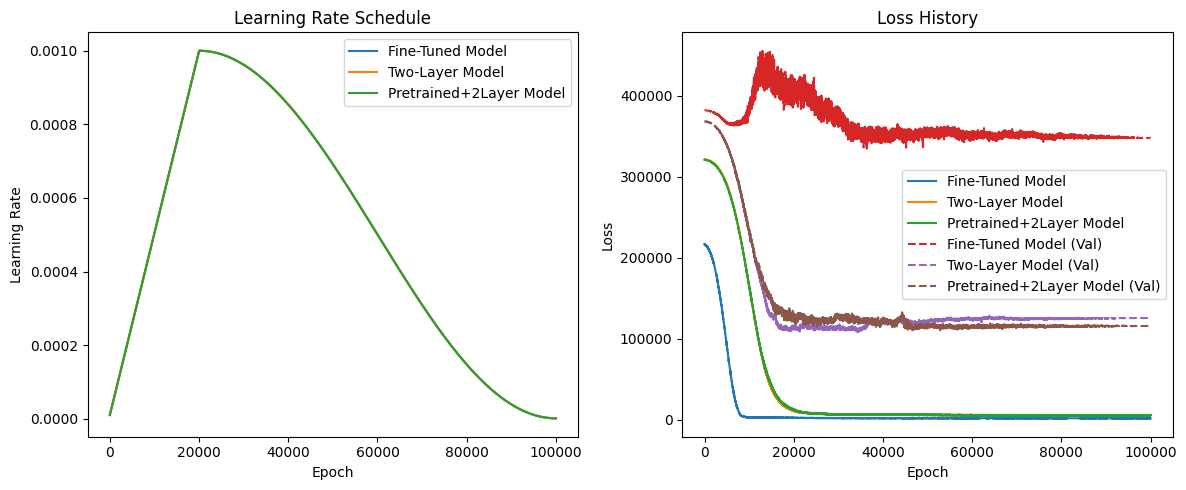

In [ ]:
# Visualize and compare the learning rate schedules
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lr_history_fine, label='Fine-Tuned Model')
plt.plot(lr_history_two, label='Two-Layer Model')   
plt.plot(lr_history_pre2, label='Pretrained+2Layer Model')
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history_fine, label='Fine-Tuned Model')
plt.plot(train_loss_history_two, label='Two-Layer Model')
plt.plot(train_loss_history_pre2, label='Pretrained+2Layer Model')
plt.plot(val_loss_history_fine, label='Fine-Tuned Model (Val)', linestyle='dashed')
plt.plot(val_loss_history_two, label='Two-Layer Model (Val)', linestyle='dashed')
plt.plot(val_loss_history_pre2, label='Pretrained+2Layer Model (Val)', linestyle='dashed')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


RuntimeError: Error(s) in loading state_dict for GATv2EncoderLayer:
	Missing key(s) in state_dict: "gatv2.att_src", "gatv2.att_dst", "gatv2.att_edge", "gatv2.lin.weight". 
	Unexpected key(s) in state_dict: "gatv2.att", "gatv2.lin_l.weight", "gatv2.lin_l.bias", "gatv2.lin_r.weight", "gatv2.lin_r.bias". 
	size mismatch for gatv2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for gatv2.lin_edge.weight: copying a param with shape torch.Size([256, 1]) from checkpoint, the shape in current model is torch.Size([512, 1]).
	size mismatch for gatv2.res.weight: copying a param with shape torch.Size([256, 2766]) from checkpoint, the shape in current model is torch.Size([512, 2766]).
	size mismatch for heads_transform.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for heads_transform.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for mlp.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for mlp.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for mlp.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for mlp.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).

# Try to create CLIP

In [330]:
from diffusers import AutoencoderKL

# Define the autoencoder model

vae = AutoencoderKL(in_channels=1, out_channels=1, down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", ), 
                    up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", ), block_out_channels=(64, 128, )).to(device)

In [331]:
# Load the best model
vae.load_state_dict(torch.load('../vae_checkpoints/vae_epoch_10.pth'))

/tmp/ipykernel_30576/1066312679.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('../vae_checkpoints/vae_epoch_10.pth'))


<All keys matched successfully>

In [332]:
# Function to visualize reconstructions
def visualize_reconstructions(model, dataloader, device, epoch, num_images=5):
    model.eval()
    with torch.no_grad():
        data = next(iter(dataloader))  # Retrieve only data
        data = data.to(device)
        latent_dist = model.encode(data).latent_dist  # Obtain latent distribution
        recon_data = model.decode(latent_dist.sample()).sample  # Decode sampled latent vectors

        # Move tensors to CPU and convert to numpy
        data = data.cpu().numpy()
        recon_data = recon_data.cpu().numpy()

    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Original Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed Image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_data[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.suptitle(f"Reconstruction at Epoch {epoch}")
    plt.tight_layout()
    plt.show()

In [333]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
from PIL import Image

# Define the PositivePatchDataset
class PositivePatchDataset(Dataset):
    def __init__(self, patches):
        """
        Args:
            patches (torch.Tensor): Tensor of patches with shape [N, 1, 128, 128]
        """
        self.patches = patches  # Keep patches on CPU
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),  # Ensure tensor is in [0,1]
        ])

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]  # [1,128,128]
        patch_np = (patch.squeeze(0).cpu().numpy() * 255).astype(np.uint8)  # Convert to [0,255] uint8
        patch_pil = Image.fromarray(patch_np, mode='L')  # Convert to PIL Image in grayscale
        patch_transformed = self.transform(patch_pil)  # Apply augmentations
        return patch_transformed  # [1,128,128], float in [0,1]


In [ ]:
# Collect positive patches
positive_patches = []

for key, data in graph_data_dict.items():
    positive_nodes = positive_nodes_dict[key].cpu()  # Ensure on CPU
    positive_patches_sample = data.patches[positive_nodes].permute(0, 3, 1, 2)  # [num_positive, 1, 128, 128]
    positive_patches.append(positive_patches_sample)

# Concatenate all positive patches
positive_patches_sample = torch.cat(positive_patches, dim=0)  # [total_positive, 1, 128, 128]

# Create the dataset
positive_dataset = PositivePatchDataset(positive_patches_sample)

# Compare with a graph autoencoder

In [181]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        """
        in_channels: Dimension of input node features
        hidden_channels: Dimension of hidden layers
        latent_dim: Dimension of the latent space (z)
        """
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Linear layers for mean and log variance
        self.mu_proj = nn.Linear(hidden_channels, latent_dim)
        self.logvar_proj = nn.Linear(hidden_channels, latent_dim)
    
    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        mu = self.mu_proj(x)
        logvar = self.logvar_proj(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, node_feature_dim):
        """
        latent_dim: Dimension of the latent space (z)
        node_feature_dim: Dimension of node features to reconstruct
        """
        super(Decoder, self).__init__()
        # MLP to reconstruct node features
        self.node_mlp = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, node_feature_dim)
        )
    
    def forward(self, z):
        """
        z: [total_num_nodes, latent_dim]
        Returns:
            adj_recon: Reconstructed adjacency matrix probabilities [total_num_nodes, total_num_nodes]
            x_recon: Reconstructed node features [total_num_nodes, node_feature_dim]
        """
        # Adjacency reconstruction via inner product
        adj_recon = torch.sigmoid(torch.matmul(z, z.t()))
        
        # Node feature reconstruction via MLP
        x_recon = self.node_mlp(z)
        
        return adj_recon, x_recon

class VGAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VGAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + eps * sigma
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, edge_index, edge_attr):
        mu, logvar = self.encoder(x, edge_index, edge_attr)
        z = self.reparameterize(mu, logvar)
        adj_recon, x_recon = self.decoder(z)
        return adj_recon, x_recon, mu, logvar


class GATv2StackEncoder(nn.Module):
    """
    Stacks multiple GATv2EncoderLayers. 
    The final layer outputs mu and logvar for the VGAE.
    """
    def __init__(self,
                 in_channels,
                 hidden_channels,
                 latent_dim,
                 num_layers=2,
                 heads=4,
                 edge_dim=None,
                 dropout=0.1):
        """
        :param in_channels:   Dimensionality of input node features
        :param hidden_channels: Dim of intermediate embeddings
        :param latent_dim:    Dim of final embeddings for mu/logvar
        :param num_layers:    How many GATv2EncoderLayer blocks to stack
        :param heads:         Number of attention heads in each GATv2Conv
        :param edge_dim:      Dim of edge features if applicable
        :param dropout:       Dropout rate
        """
        super(GATv2StackEncoder, self).__init__()
        
        self.num_layers = num_layers
        
        # The first layer: in_channels -> hidden_channels
        self.layers = nn.ModuleList()
        self.layers.append(GATv2EncoderLayer(
            in_channels=in_channels,
            out_channels=hidden_channels,
            heads=heads,
            edge_dim=edge_dim,
            dropout=dropout
        ))
        
        # Additional layers: hidden_channels -> hidden_channels
        for _ in range(num_layers - 1):
            self.layers.append(GATv2EncoderLayer(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                heads=heads,
                edge_dim=edge_dim,
                dropout=dropout
            ))
        
        # Projection heads for mu and logvar (each of size latent_dim)
        self.mu_proj = nn.Linear(hidden_channels, latent_dim)
        self.logvar_proj = nn.Linear(hidden_channels, latent_dim)
    
    def forward(self, x, edge_index, edge_attr):
        # Pass through stacked GATv2 encoder layers
        for layer in self.layers:
            x = layer(x, edge_index, edge_attr)
        
        mu = self.mu_proj(x)
        logvar = self.logvar_proj(x)
        return mu, logvar


In [183]:
hyperparams = {
    "in_channels": 2766,          # Dimension of input node features
    "hidden_channels": 512,       # Hidden dimension in GCN layers
    "latent_dim": 256,            # Dimension of latent space z
    "lr": 1e-3,                   # Learning rate
    "weight_decay": 1e-4,         # L2 weight decay
    "epochs": 200,                # Number of training epochs
    "kl_anneal_start": 0.0,       # Starting weight for KL term
    "kl_anneal_end": 1.0,         # Final weight for KL term
    "kl_anneal_duration": 50,     # Number of epochs to anneal KL weight
    "recon_lambda_start": 0.5,    # Starting weight for node feature reconstruction
    "recon_lambda_end": 1.0,      # Final weight for node feature reconstruction
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Device configuration
}


In [184]:
def train_vgae(model, loader, hyperparams):
    """
    model: VGAE model
    loader: DataLoader with batched graphs
    hyperparams: dict of hyperparameters
    
    Returns:
        loss_history: List of loss dictionaries per epoch
    """
    kl_anneal_start = hyperparams["kl_anneal_start"]
    kl_anneal_end = hyperparams["kl_anneal_end"]
    kl_anneal_duration = hyperparams["kl_anneal_duration"]
    
    recon_lambda_start = hyperparams.get("recon_lambda_start", 1.0)
    recon_lambda_end = hyperparams.get("recon_lambda_end", 1.0)
    
    epochs = hyperparams["epochs"]
    device = hyperparams["device"]
    loss_history = []
    
    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        total_loss = 0.0
        total_adj_loss = 0.0
        total_x_loss = 0.0
        total_kl_div = 0.0
        
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            adj_recon, x_recon, mu, logvar = model(batch.x, batch.edge_index, batch.edge_attr)
            
            # Ground truth adjacency matrix
            num_nodes = batch.num_nodes
            adj_truth = torch.zeros((num_nodes, num_nodes), device=device)
            adj_truth[batch.edge_index[0], batch.edge_index[1]] = 1.0
            # If undirected, mirror the adjacency
            adj_truth = adj_truth + adj_truth.t()
            adj_truth = (adj_truth > 0).float()
            
            # Adjacency Reconstruction Loss (Binary Cross-Entropy)
            adj_loss = F.binary_cross_entropy(adj_recon, adj_truth)
            
            # Node Feature Reconstruction Loss (Mean Squared Error)
            x_loss = F.mse_loss(x_recon, batch.x)
            
            # KL Divergence
            kl_div = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
            
            # Annealing Coefficients
            if epoch < kl_anneal_duration:
                kl_weight = kl_anneal_start + (kl_anneal_end - kl_anneal_start) * (epoch / kl_anneal_duration)
                recon_lambda = recon_lambda_start + (recon_lambda_end - recon_lambda_start) * (epoch / kl_anneal_duration)
            else:
                kl_weight = kl_anneal_end
                recon_lambda = recon_lambda_end
            
            # Total Loss
            loss = adj_loss + recon_lambda * x_loss + kl_weight * kl_div
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_adj_loss += adj_loss.item()
            total_x_loss += x_loss.item()
            total_kl_div += kl_div.item()
        
        # Average losses over the dataset
        avg_loss = total_loss / len(loader)
        avg_adj_loss = total_adj_loss / len(loader)
        avg_x_loss = total_x_loss / len(loader)
        avg_kl_div = total_kl_div / len(loader)
        
        # Record loss history
        loss_history.append({
            "epoch": epoch,
            "total_loss": avg_loss,
            "adj_bce_loss": avg_adj_loss,
            "x_mse_loss": avg_x_loss,
            "kl_div": avg_kl_div,
            "kl_weight": kl_weight,
            "recon_lambda": recon_lambda
        })
        
        # Update tqdm with current loss
        tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | Adj BCE: {avg_adj_loss:.4f} | X MSE: {avg_x_loss:.4f} | KL Div: {avg_kl_div:.4f} | KL Weight: {kl_weight:.4f} | Recon Lambda: {recon_lambda:.4f}")
    
    return loss_history


In [172]:
# Convert the dictionary to a list
dataset = list(graph_data_dict.values())

# Create DataLoader
batch_size = 1  # Since graphs are large, batch_size=1 is typical
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [185]:
# Initialize Encoder and Decoder
encoder = GATv2StackEncoder(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    latent_dim=latent_dim,
    num_layers=num_layers,
    heads=heads,
    edge_dim=edge_dim,
    dropout=dropout
)

decoder = Decoder(latent_dim=hyperparams["latent_dim"],
                  node_feature_dim=hyperparams["in_channels"])

# Initialize VGAE model
model = VGAE(encoder, decoder).to(hyperparams["device"])

# Initialize Optimizer
optimizer = Adam(model.parameters(), lr=hyperparams["lr"], weight_decay=hyperparams["weight_decay"])


In [186]:
# Train the model
loss_history = train_vgae(model, loader, hyperparams)


Training:   0%|          | 1/200 [00:01<04:25,  1.34s/it]

Epoch 1/200 - Loss: 63.4530 | Adj BCE: 62.9267 | X MSE: 1.0526 | KL Div: 140.3648 | KL Weight: 0.0000 | Recon Lambda: 0.5000


Training:   1%|          | 2/200 [00:02<04:24,  1.33s/it]

Epoch 2/200 - Loss: 11689.2354 | Adj BCE: 32.7476 | X MSE: 24.0013 | KL Div: 582212.3671 | KL Weight: 0.0200 | Recon Lambda: 0.5100


Training:   2%|▏         | 3/200 [00:04<04:23,  1.34s/it]

Epoch 3/200 - Loss: 27.1102 | Adj BCE: 25.6737 | X MSE: 0.9935 | KL Div: 22.9953 | KL Weight: 0.0400 | Recon Lambda: 0.5200


Training:   2%|▏         | 4/200 [00:05<04:20,  1.33s/it]

Epoch 4/200 - Loss: 21.4952 | Adj BCE: 19.9688 | X MSE: 0.9915 | KL Div: 16.6808 | KL Weight: 0.0600 | Recon Lambda: 0.5300


Training:   2%|▎         | 5/200 [00:06<04:28,  1.38s/it]

Epoch 5/200 - Loss: 20.5582 | Adj BCE: 18.8218 | X MSE: 0.9925 | KL Div: 15.0058 | KL Weight: 0.0800 | Recon Lambda: 0.5400


Training:   3%|▎         | 6/200 [00:08<04:29,  1.39s/it]

Epoch 6/200 - Loss: 19.4882 | Adj BCE: 17.5517 | X MSE: 0.9918 | KL Div: 13.9096 | KL Weight: 0.1000 | Recon Lambda: 0.5500


Training:   4%|▎         | 7/200 [00:09<04:20,  1.35s/it]

Epoch 7/200 - Loss: 19.4307 | Adj BCE: 17.2879 | X MSE: 0.9906 | KL Div: 13.2335 | KL Weight: 0.1200 | Recon Lambda: 0.5600


Training:   4%|▍         | 8/200 [00:10<04:16,  1.34s/it]

Epoch 8/200 - Loss: 18.9785 | Adj BCE: 16.6161 | X MSE: 0.9890 | KL Div: 12.8480 | KL Weight: 0.1400 | Recon Lambda: 0.5700


Training:   4%|▍         | 9/200 [00:12<04:19,  1.36s/it]

Epoch 9/200 - Loss: 18.9742 | Adj BCE: 16.3935 | X MSE: 0.9859 | KL Div: 12.5556 | KL Weight: 0.1600 | Recon Lambda: 0.5800


Training:   5%|▌         | 10/200 [00:13<04:20,  1.37s/it]

Epoch 10/200 - Loss: 19.1565 | Adj BCE: 16.3807 | X MSE: 0.9840 | KL Div: 12.1959 | KL Weight: 0.1800 | Recon Lambda: 0.5900


Training:   6%|▌         | 11/200 [00:14<04:07,  1.31s/it]

Epoch 11/200 - Loss: 19.2722 | Adj BCE: 16.3067 | X MSE: 0.9812 | KL Div: 11.8841 | KL Weight: 0.2000 | Recon Lambda: 0.6000


Training:   6%|▌         | 12/200 [00:16<04:06,  1.31s/it]

Epoch 12/200 - Loss: 19.5389 | Adj BCE: 16.3743 | X MSE: 0.9795 | KL Div: 11.6688 | KL Weight: 0.2200 | Recon Lambda: 0.6100


Training:   6%|▋         | 13/200 [00:17<04:05,  1.31s/it]

Epoch 13/200 - Loss: 19.6999 | Adj BCE: 16.3509 | X MSE: 0.9771 | KL Div: 11.4297 | KL Weight: 0.2400 | Recon Lambda: 0.6200


Training:   7%|▋         | 14/200 [00:18<04:07,  1.33s/it]

Epoch 14/200 - Loss: 19.9989 | Adj BCE: 16.4754 | X MSE: 0.9752 | KL Div: 11.1888 | KL Weight: 0.2600 | Recon Lambda: 0.6300


Training:   8%|▊         | 15/200 [00:19<04:00,  1.30s/it]

Epoch 15/200 - Loss: 20.3048 | Adj BCE: 16.6195 | X MSE: 0.9736 | KL Div: 10.9364 | KL Weight: 0.2800 | Recon Lambda: 0.6400


Training:   8%|▊         | 16/200 [00:21<04:02,  1.32s/it]

Epoch 16/200 - Loss: 20.6034 | Adj BCE: 16.7706 | X MSE: 0.9721 | KL Div: 10.6696 | KL Weight: 0.3000 | Recon Lambda: 0.6500


Training:   8%|▊         | 17/200 [00:22<04:04,  1.33s/it]

Epoch 17/200 - Loss: 20.9191 | Adj BCE: 16.9287 | X MSE: 0.9708 | KL Div: 10.4678 | KL Weight: 0.3200 | Recon Lambda: 0.6600


Training:   9%|▉         | 18/200 [00:23<03:59,  1.32s/it]

Epoch 18/200 - Loss: 21.1207 | Adj BCE: 16.9832 | X MSE: 0.9696 | KL Div: 10.2586 | KL Weight: 0.3400 | Recon Lambda: 0.6700


Training:  10%|▉         | 19/200 [00:25<04:01,  1.33s/it]

Epoch 19/200 - Loss: 21.3694 | Adj BCE: 17.0825 | X MSE: 0.9685 | KL Div: 10.0785 | KL Weight: 0.3600 | Recon Lambda: 0.6800


Training:  10%|█         | 20/200 [00:26<04:03,  1.35s/it]

Epoch 20/200 - Loss: 21.6302 | Adj BCE: 17.2043 | X MSE: 0.9676 | KL Div: 9.8903 | KL Weight: 0.3800 | Recon Lambda: 0.6900


Training:  10%|█         | 21/200 [00:28<03:56,  1.32s/it]

Epoch 21/200 - Loss: 21.8247 | Adj BCE: 17.2700 | X MSE: 0.9668 | KL Div: 9.6948 | KL Weight: 0.4000 | Recon Lambda: 0.7000


Training:  11%|█         | 22/200 [00:29<03:56,  1.33s/it]

Epoch 22/200 - Loss: 22.0222 | Adj BCE: 17.3270 | X MSE: 0.9660 | KL Div: 9.5459 | KL Weight: 0.4200 | Recon Lambda: 0.7100


Training:  12%|█▏        | 23/200 [00:30<03:58,  1.35s/it]

Epoch 23/200 - Loss: 22.1613 | Adj BCE: 17.3478 | X MSE: 0.9653 | KL Div: 9.3601 | KL Weight: 0.4400 | Recon Lambda: 0.7200


Training:  12%|█▏        | 24/200 [00:32<04:00,  1.37s/it]

Epoch 24/200 - Loss: 22.3050 | Adj BCE: 17.3615 | X MSE: 0.9646 | KL Div: 9.2159 | KL Weight: 0.4600 | Recon Lambda: 0.7300


Training:  12%|█▎        | 25/200 [00:33<03:54,  1.34s/it]

Epoch 25/200 - Loss: 22.4602 | Adj BCE: 17.3906 | X MSE: 0.9640 | KL Div: 9.0754 | KL Weight: 0.4800 | Recon Lambda: 0.7400


Training:  13%|█▎        | 26/200 [00:34<03:50,  1.32s/it]

Epoch 26/200 - Loss: 22.6404 | Adj BCE: 17.4697 | X MSE: 0.9636 | KL Div: 8.8961 | KL Weight: 0.5000 | Recon Lambda: 0.7500


Training:  14%|█▎        | 27/200 [00:36<03:53,  1.35s/it]

Epoch 27/200 - Loss: 22.7376 | Adj BCE: 17.4607 | X MSE: 0.9630 | KL Div: 8.7404 | KL Weight: 0.5200 | Recon Lambda: 0.7600


Training:  14%|█▍        | 28/200 [00:37<03:50,  1.34s/it]

Epoch 28/200 - Loss: 22.8184 | Adj BCE: 17.4376 | X MSE: 0.9626 | KL Div: 8.5918 | KL Weight: 0.5400 | Recon Lambda: 0.7700


Training:  14%|█▍        | 29/200 [00:38<03:50,  1.35s/it]

Epoch 29/200 - Loss: 22.9588 | Adj BCE: 17.4778 | X MSE: 0.9621 | KL Div: 8.4474 | KL Weight: 0.5600 | Recon Lambda: 0.7800


Training:  15%|█▌        | 30/200 [00:40<03:49,  1.35s/it]

Epoch 30/200 - Loss: 23.1093 | Adj BCE: 17.5373 | X MSE: 0.9618 | KL Div: 8.2968 | KL Weight: 0.5800 | Recon Lambda: 0.7900


Training:  16%|█▌        | 31/200 [00:41<03:45,  1.33s/it]

Epoch 31/200 - Loss: 23.2008 | Adj BCE: 17.5440 | X MSE: 0.9614 | KL Div: 8.1461 | KL Weight: 0.6000 | Recon Lambda: 0.8000


Training:  16%|█▌        | 32/200 [00:42<03:39,  1.31s/it]

Epoch 32/200 - Loss: 23.2931 | Adj BCE: 17.5598 | X MSE: 0.9611 | KL Div: 7.9917 | KL Weight: 0.6200 | Recon Lambda: 0.8100


Training:  16%|█▋        | 33/200 [00:44<03:41,  1.33s/it]

Epoch 33/200 - Loss: 23.3761 | Adj BCE: 17.5574 | X MSE: 0.9607 | KL Div: 7.8608 | KL Weight: 0.6400 | Recon Lambda: 0.8200


Training:  17%|█▋        | 34/200 [00:45<03:42,  1.34s/it]

Epoch 34/200 - Loss: 23.4376 | Adj BCE: 17.5521 | X MSE: 0.9604 | KL Div: 7.7096 | KL Weight: 0.6600 | Recon Lambda: 0.8300


Training:  18%|█▊        | 35/200 [00:46<03:37,  1.32s/it]

Epoch 35/200 - Loss: 23.5428 | Adj BCE: 17.5985 | X MSE: 0.9601 | KL Div: 7.5557 | KL Weight: 0.6800 | Recon Lambda: 0.8400


Training:  18%|█▊        | 36/200 [00:47<03:33,  1.30s/it]

Epoch 36/200 - Loss: 23.5741 | Adj BCE: 17.5797 | X MSE: 0.9598 | KL Div: 7.3980 | KL Weight: 0.7000 | Recon Lambda: 0.8500


Training:  18%|█▊        | 37/200 [00:49<03:37,  1.33s/it]

Epoch 37/200 - Loss: 23.5874 | Adj BCE: 17.5569 | X MSE: 0.9596 | KL Div: 7.2295 | KL Weight: 0.7200 | Recon Lambda: 0.8600


Training:  19%|█▉        | 38/200 [00:50<03:38,  1.35s/it]

Epoch 38/200 - Loss: 23.6334 | Adj BCE: 17.5568 | X MSE: 0.9593 | KL Div: 7.0839 | KL Weight: 0.7400 | Recon Lambda: 0.8700


Training:  20%|█▉        | 39/200 [00:52<03:33,  1.33s/it]

Epoch 39/200 - Loss: 23.6397 | Adj BCE: 17.5398 | X MSE: 0.9590 | KL Div: 6.9157 | KL Weight: 0.7600 | Recon Lambda: 0.8800


Training:  20%|██        | 40/200 [00:53<03:30,  1.31s/it]

Epoch 40/200 - Loss: 23.6882 | Adj BCE: 17.5855 | X MSE: 0.9588 | KL Div: 6.7298 | KL Weight: 0.7800 | Recon Lambda: 0.8900


Training:  20%|██        | 41/200 [00:54<03:34,  1.35s/it]

Epoch 41/200 - Loss: 23.6848 | Adj BCE: 17.5640 | X MSE: 0.9586 | KL Div: 6.5725 | KL Weight: 0.8000 | Recon Lambda: 0.9000


Training:  21%|██        | 42/200 [00:56<03:32,  1.35s/it]

Epoch 42/200 - Loss: 23.6195 | Adj BCE: 17.5290 | X MSE: 0.9584 | KL Div: 6.3639 | KL Weight: 0.8200 | Recon Lambda: 0.9100


Training:  22%|██▏       | 43/200 [00:57<03:31,  1.35s/it]

Epoch 43/200 - Loss: 23.5996 | Adj BCE: 17.5436 | X MSE: 0.9582 | KL Div: 6.1601 | KL Weight: 0.8400 | Recon Lambda: 0.9200


Training:  22%|██▏       | 44/200 [00:58<03:30,  1.35s/it]

Epoch 44/200 - Loss: 23.5506 | Adj BCE: 17.5374 | X MSE: 0.9580 | KL Div: 5.9560 | KL Weight: 0.8600 | Recon Lambda: 0.9300


Training:  22%|██▎       | 45/200 [01:00<03:28,  1.35s/it]

Epoch 45/200 - Loss: 23.4575 | Adj BCE: 17.5104 | X MSE: 0.9578 | KL Div: 5.7350 | KL Weight: 0.8800 | Recon Lambda: 0.9400


Training:  23%|██▎       | 46/200 [01:01<03:23,  1.32s/it]

Epoch 46/200 - Loss: 23.3337 | Adj BCE: 17.4790 | X MSE: 0.9576 | KL Div: 5.4943 | KL Weight: 0.9000 | Recon Lambda: 0.9500


Training:  24%|██▎       | 47/200 [01:02<03:25,  1.34s/it]

Epoch 47/200 - Loss: 23.2620 | Adj BCE: 17.4809 | X MSE: 0.9575 | KL Div: 5.2847 | KL Weight: 0.9200 | Recon Lambda: 0.9600


Training:  24%|██▍       | 48/200 [01:04<03:25,  1.35s/it]

Epoch 48/200 - Loss: 23.1567 | Adj BCE: 17.4776 | X MSE: 0.9573 | KL Div: 5.0537 | KL Weight: 0.9400 | Recon Lambda: 0.9700


Training:  24%|██▍       | 49/200 [01:05<03:18,  1.31s/it]

Epoch 49/200 - Loss: 22.9843 | Adj BCE: 17.4063 | X MSE: 0.9572 | KL Div: 4.8333 | KL Weight: 0.9600 | Recon Lambda: 0.9800


Training:  25%|██▌       | 50/200 [01:06<03:15,  1.31s/it]

Epoch 50/200 - Loss: 22.8982 | Adj BCE: 17.4386 | X MSE: 0.9570 | KL Div: 4.6043 | KL Weight: 0.9800 | Recon Lambda: 0.9900


Training:  26%|██▌       | 51/200 [01:08<03:18,  1.33s/it]

Epoch 51/200 - Loss: 22.7605 | Adj BCE: 17.4149 | X MSE: 0.9569 | KL Div: 4.3887 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  26%|██▌       | 52/200 [01:09<03:21,  1.36s/it]

Epoch 52/200 - Loss: 22.5166 | Adj BCE: 17.3839 | X MSE: 0.9567 | KL Div: 4.1759 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  26%|██▋       | 53/200 [01:10<03:15,  1.33s/it]

Epoch 53/200 - Loss: 22.2979 | Adj BCE: 17.3682 | X MSE: 0.9566 | KL Div: 3.9731 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  27%|██▋       | 54/200 [01:12<03:10,  1.31s/it]

Epoch 54/200 - Loss: 22.0927 | Adj BCE: 17.3495 | X MSE: 0.9565 | KL Div: 3.7867 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  28%|██▊       | 55/200 [01:13<03:13,  1.33s/it]

Epoch 55/200 - Loss: 21.8876 | Adj BCE: 17.3326 | X MSE: 0.9564 | KL Div: 3.5986 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  28%|██▊       | 56/200 [01:14<03:14,  1.35s/it]

Epoch 56/200 - Loss: 21.7025 | Adj BCE: 17.3302 | X MSE: 0.9562 | KL Div: 3.4160 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  28%|██▊       | 57/200 [01:16<03:08,  1.32s/it]

Epoch 57/200 - Loss: 21.5214 | Adj BCE: 17.3144 | X MSE: 0.9561 | KL Div: 3.2509 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  29%|██▉       | 58/200 [01:17<03:07,  1.32s/it]

Epoch 58/200 - Loss: 21.3249 | Adj BCE: 17.2786 | X MSE: 0.9561 | KL Div: 3.0902 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  30%|██▉       | 59/200 [01:18<03:06,  1.32s/it]

Epoch 59/200 - Loss: 21.1604 | Adj BCE: 17.2733 | X MSE: 0.9560 | KL Div: 2.9312 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  30%|███       | 60/200 [01:20<03:04,  1.32s/it]

Epoch 60/200 - Loss: 21.0128 | Adj BCE: 17.2764 | X MSE: 0.9559 | KL Div: 2.7805 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  30%|███       | 61/200 [01:21<03:02,  1.31s/it]

Epoch 61/200 - Loss: 20.8497 | Adj BCE: 17.2502 | X MSE: 0.9558 | KL Div: 2.6438 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  31%|███       | 62/200 [01:22<03:05,  1.35s/it]

Epoch 62/200 - Loss: 20.6999 | Adj BCE: 17.2390 | X MSE: 0.9557 | KL Div: 2.5052 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  32%|███▏      | 63/200 [01:24<03:03,  1.34s/it]

Epoch 63/200 - Loss: 20.5596 | Adj BCE: 17.2289 | X MSE: 0.9556 | KL Div: 2.3751 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  32%|███▏      | 64/200 [01:25<02:56,  1.30s/it]

Epoch 64/200 - Loss: 20.4302 | Adj BCE: 17.2288 | X MSE: 0.9556 | KL Div: 2.2459 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  32%|███▎      | 65/200 [01:26<02:59,  1.33s/it]

Epoch 65/200 - Loss: 20.2786 | Adj BCE: 17.2027 | X MSE: 0.9555 | KL Div: 2.1204 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  33%|███▎      | 66/200 [01:28<03:01,  1.35s/it]

Epoch 66/200 - Loss: 20.1572 | Adj BCE: 17.2052 | X MSE: 0.9554 | KL Div: 1.9965 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  34%|███▎      | 67/200 [01:29<02:56,  1.33s/it]

Epoch 67/200 - Loss: 20.0542 | Adj BCE: 17.2209 | X MSE: 0.9554 | KL Div: 1.8779 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  34%|███▍      | 68/200 [01:30<02:52,  1.31s/it]

Epoch 68/200 - Loss: 19.9242 | Adj BCE: 17.2049 | X MSE: 0.9553 | KL Div: 1.7640 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  34%|███▍      | 69/200 [01:32<02:56,  1.35s/it]

Epoch 69/200 - Loss: 19.8099 | Adj BCE: 17.2007 | X MSE: 0.9552 | KL Div: 1.6540 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  35%|███▌      | 70/200 [01:33<02:54,  1.35s/it]

Epoch 70/200 - Loss: 19.6718 | Adj BCE: 17.1796 | X MSE: 0.9552 | KL Div: 1.5371 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  36%|███▌      | 71/200 [01:34<02:53,  1.34s/it]

Epoch 71/200 - Loss: 19.5791 | Adj BCE: 17.1924 | X MSE: 0.9551 | KL Div: 1.4316 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  36%|███▌      | 72/200 [01:36<02:53,  1.35s/it]

Epoch 72/200 - Loss: 19.4527 | Adj BCE: 17.1699 | X MSE: 0.9551 | KL Div: 1.3277 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  36%|███▋      | 73/200 [01:37<02:53,  1.37s/it]

Epoch 73/200 - Loss: 19.3776 | Adj BCE: 17.1995 | X MSE: 0.9550 | KL Div: 1.2231 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  37%|███▋      | 74/200 [01:38<02:50,  1.35s/it]

Epoch 74/200 - Loss: 19.2411 | Adj BCE: 17.1636 | X MSE: 0.9550 | KL Div: 1.1225 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  38%|███▊      | 75/200 [01:40<02:49,  1.36s/it]

Epoch 75/200 - Loss: 19.1381 | Adj BCE: 17.1528 | X MSE: 0.9549 | KL Div: 1.0304 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  38%|███▊      | 76/200 [01:41<02:48,  1.36s/it]

Epoch 76/200 - Loss: 19.0497 | Adj BCE: 17.1589 | X MSE: 0.9549 | KL Div: 0.9359 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  38%|███▊      | 77/200 [01:42<02:45,  1.34s/it]

Epoch 77/200 - Loss: 18.9493 | Adj BCE: 17.1486 | X MSE: 0.9549 | KL Div: 0.8457 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  39%|███▉      | 78/200 [01:44<02:40,  1.32s/it]

Epoch 78/200 - Loss: 18.8898 | Adj BCE: 17.1773 | X MSE: 0.9548 | KL Div: 0.7577 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  40%|███▉      | 79/200 [01:45<02:42,  1.34s/it]

Epoch 79/200 - Loss: 18.8106 | Adj BCE: 17.1780 | X MSE: 0.9548 | KL Div: 0.6778 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  40%|████      | 80/200 [01:46<02:44,  1.37s/it]

Epoch 80/200 - Loss: 18.7141 | Adj BCE: 17.1566 | X MSE: 0.9548 | KL Div: 0.6027 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  40%|████      | 81/200 [01:48<02:39,  1.34s/it]

Epoch 81/200 - Loss: 18.6500 | Adj BCE: 17.1600 | X MSE: 0.9547 | KL Div: 0.5353 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  41%|████      | 82/200 [01:49<02:36,  1.32s/it]

Epoch 82/200 - Loss: 18.6027 | Adj BCE: 17.1717 | X MSE: 0.9547 | KL Div: 0.4763 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  42%|████▏     | 83/200 [01:50<02:37,  1.35s/it]

Epoch 83/200 - Loss: 18.5524 | Adj BCE: 17.1732 | X MSE: 0.9547 | KL Div: 0.4245 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  42%|████▏     | 84/200 [01:52<02:37,  1.36s/it]

Epoch 84/200 - Loss: 18.5127 | Adj BCE: 17.1699 | X MSE: 0.9547 | KL Div: 0.3882 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  42%|████▎     | 85/200 [01:53<02:33,  1.33s/it]

Epoch 85/200 - Loss: 18.4782 | Adj BCE: 17.1595 | X MSE: 0.9546 | KL Div: 0.3640 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  43%|████▎     | 86/200 [01:54<02:31,  1.33s/it]

Epoch 86/200 - Loss: 18.4590 | Adj BCE: 17.1626 | X MSE: 0.9546 | KL Div: 0.3418 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  44%|████▎     | 87/200 [01:56<02:29,  1.33s/it]

Epoch 87/200 - Loss: 18.4692 | Adj BCE: 17.1794 | X MSE: 0.9546 | KL Div: 0.3351 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  44%|████▍     | 88/200 [01:57<02:27,  1.32s/it]

Epoch 88/200 - Loss: 18.4679 | Adj BCE: 17.1872 | X MSE: 0.9546 | KL Div: 0.3262 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  44%|████▍     | 89/200 [01:58<02:27,  1.33s/it]

Epoch 89/200 - Loss: 18.4440 | Adj BCE: 17.1701 | X MSE: 0.9545 | KL Div: 0.3194 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  45%|████▌     | 90/200 [02:00<02:28,  1.35s/it]

Epoch 90/200 - Loss: 18.4360 | Adj BCE: 17.1678 | X MSE: 0.9545 | KL Div: 0.3137 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  46%|████▌     | 91/200 [02:01<02:24,  1.32s/it]

Epoch 91/200 - Loss: 18.4404 | Adj BCE: 17.1807 | X MSE: 0.9545 | KL Div: 0.3052 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  46%|████▌     | 92/200 [02:02<02:21,  1.31s/it]

Epoch 92/200 - Loss: 18.4067 | Adj BCE: 17.1537 | X MSE: 0.9545 | KL Div: 0.2985 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  46%|████▋     | 93/200 [02:04<02:22,  1.34s/it]

Epoch 93/200 - Loss: 18.4050 | Adj BCE: 17.1583 | X MSE: 0.9544 | KL Div: 0.2923 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  47%|████▋     | 94/200 [02:05<02:25,  1.37s/it]

Epoch 94/200 - Loss: 18.4108 | Adj BCE: 17.1668 | X MSE: 0.9544 | KL Div: 0.2896 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  48%|████▊     | 95/200 [02:06<02:19,  1.33s/it]

Epoch 95/200 - Loss: 18.3870 | Adj BCE: 17.1527 | X MSE: 0.9544 | KL Div: 0.2799 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  48%|████▊     | 96/200 [02:08<02:17,  1.32s/it]

Epoch 96/200 - Loss: 18.3875 | Adj BCE: 17.1547 | X MSE: 0.9544 | KL Div: 0.2784 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  48%|████▊     | 97/200 [02:09<02:18,  1.35s/it]

Epoch 97/200 - Loss: 18.3884 | Adj BCE: 17.1583 | X MSE: 0.9544 | KL Div: 0.2757 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  49%|████▉     | 98/200 [02:10<02:17,  1.35s/it]

Epoch 98/200 - Loss: 18.3807 | Adj BCE: 17.1586 | X MSE: 0.9544 | KL Div: 0.2678 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  50%|████▉     | 99/200 [02:12<02:14,  1.33s/it]

Epoch 99/200 - Loss: 18.3772 | Adj BCE: 17.1579 | X MSE: 0.9543 | KL Div: 0.2649 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  50%|█████     | 100/200 [02:13<02:12,  1.33s/it]

Epoch 100/200 - Loss: 18.3849 | Adj BCE: 17.1699 | X MSE: 0.9543 | KL Div: 0.2606 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  50%|█████     | 101/200 [02:14<02:12,  1.33s/it]

Epoch 101/200 - Loss: 18.3628 | Adj BCE: 17.1515 | X MSE: 0.9543 | KL Div: 0.2569 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  51%|█████     | 102/200 [02:16<02:09,  1.32s/it]

Epoch 102/200 - Loss: 18.3594 | Adj BCE: 17.1529 | X MSE: 0.9543 | KL Div: 0.2522 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  52%|█████▏    | 103/200 [02:17<02:06,  1.30s/it]

Epoch 103/200 - Loss: 18.3452 | Adj BCE: 17.1404 | X MSE: 0.9543 | KL Div: 0.2506 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  52%|█████▏    | 104/200 [02:18<02:07,  1.33s/it]

Epoch 104/200 - Loss: 18.3569 | Adj BCE: 17.1565 | X MSE: 0.9543 | KL Div: 0.2462 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  52%|█████▎    | 105/200 [02:20<02:06,  1.33s/it]

Epoch 105/200 - Loss: 18.3484 | Adj BCE: 17.1518 | X MSE: 0.9542 | KL Div: 0.2424 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  53%|█████▎    | 106/200 [02:21<02:00,  1.28s/it]

Epoch 106/200 - Loss: 18.3420 | Adj BCE: 17.1491 | X MSE: 0.9542 | KL Div: 0.2387 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  54%|█████▎    | 107/200 [02:22<02:02,  1.32s/it]

Epoch 107/200 - Loss: 18.3656 | Adj BCE: 17.1761 | X MSE: 0.9542 | KL Div: 0.2353 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  54%|█████▍    | 108/200 [02:24<02:03,  1.34s/it]

Epoch 108/200 - Loss: 18.3382 | Adj BCE: 17.1531 | X MSE: 0.9542 | KL Div: 0.2309 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  55%|█████▍    | 109/200 [02:25<02:01,  1.33s/it]

Epoch 109/200 - Loss: 18.3362 | Adj BCE: 17.1533 | X MSE: 0.9542 | KL Div: 0.2288 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  55%|█████▌    | 110/200 [02:26<01:56,  1.30s/it]

Epoch 110/200 - Loss: 18.3353 | Adj BCE: 17.1541 | X MSE: 0.9542 | KL Div: 0.2270 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  56%|█████▌    | 111/200 [02:28<01:58,  1.33s/it]

Epoch 111/200 - Loss: 18.3335 | Adj BCE: 17.1579 | X MSE: 0.9542 | KL Div: 0.2214 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  56%|█████▌    | 112/200 [02:29<01:59,  1.36s/it]

Epoch 112/200 - Loss: 18.3075 | Adj BCE: 17.1351 | X MSE: 0.9542 | KL Div: 0.2182 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  56%|█████▋    | 113/200 [02:30<01:55,  1.33s/it]

Epoch 113/200 - Loss: 18.3372 | Adj BCE: 17.1668 | X MSE: 0.9542 | KL Div: 0.2163 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  57%|█████▋    | 114/200 [02:32<01:54,  1.33s/it]

Epoch 114/200 - Loss: 18.3221 | Adj BCE: 17.1546 | X MSE: 0.9541 | KL Div: 0.2134 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  57%|█████▊    | 115/200 [02:33<01:53,  1.33s/it]

Epoch 115/200 - Loss: 18.3263 | Adj BCE: 17.1593 | X MSE: 0.9541 | KL Div: 0.2128 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  58%|█████▊    | 116/200 [02:34<01:50,  1.32s/it]

Epoch 116/200 - Loss: 18.3108 | Adj BCE: 17.1478 | X MSE: 0.9541 | KL Div: 0.2089 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  58%|█████▊    | 117/200 [02:35<01:48,  1.31s/it]

Epoch 117/200 - Loss: 18.3136 | Adj BCE: 17.1541 | X MSE: 0.9541 | KL Div: 0.2054 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  59%|█████▉    | 118/200 [02:37<01:49,  1.33s/it]

Epoch 118/200 - Loss: 18.3004 | Adj BCE: 17.1415 | X MSE: 0.9541 | KL Div: 0.2048 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  60%|█████▉    | 119/200 [02:38<01:47,  1.33s/it]

Epoch 119/200 - Loss: 18.3014 | Adj BCE: 17.1463 | X MSE: 0.9541 | KL Div: 0.2010 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  60%|██████    | 120/200 [02:39<01:42,  1.28s/it]

Epoch 120/200 - Loss: 18.2849 | Adj BCE: 17.1332 | X MSE: 0.9541 | KL Div: 0.1976 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  60%|██████    | 121/200 [02:41<01:42,  1.30s/it]

Epoch 121/200 - Loss: 18.3054 | Adj BCE: 17.1545 | X MSE: 0.9541 | KL Div: 0.1968 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  61%|██████    | 122/200 [02:42<01:42,  1.31s/it]

Epoch 122/200 - Loss: 18.2839 | Adj BCE: 17.1357 | X MSE: 0.9541 | KL Div: 0.1941 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  62%|██████▏   | 123/200 [02:43<01:41,  1.32s/it]

Epoch 123/200 - Loss: 18.2832 | Adj BCE: 17.1353 | X MSE: 0.9541 | KL Div: 0.1938 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  62%|██████▏   | 124/200 [02:45<01:38,  1.30s/it]

Epoch 124/200 - Loss: 18.2696 | Adj BCE: 17.1244 | X MSE: 0.9541 | KL Div: 0.1911 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  62%|██████▎   | 125/200 [02:46<01:39,  1.33s/it]

Epoch 125/200 - Loss: 18.2688 | Adj BCE: 17.1258 | X MSE: 0.9541 | KL Div: 0.1890 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  63%|██████▎   | 126/200 [02:47<01:39,  1.35s/it]

Epoch 126/200 - Loss: 18.2829 | Adj BCE: 17.1436 | X MSE: 0.9540 | KL Div: 0.1852 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  64%|██████▎   | 127/200 [02:49<01:35,  1.31s/it]

Epoch 127/200 - Loss: 18.2891 | Adj BCE: 17.1510 | X MSE: 0.9540 | KL Div: 0.1841 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  64%|██████▍   | 128/200 [02:50<01:35,  1.33s/it]

Epoch 128/200 - Loss: 18.2794 | Adj BCE: 17.1435 | X MSE: 0.9540 | KL Div: 0.1819 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  64%|██████▍   | 129/200 [02:51<01:33,  1.31s/it]

Epoch 129/200 - Loss: 18.2684 | Adj BCE: 17.1352 | X MSE: 0.9540 | KL Div: 0.1792 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  65%|██████▌   | 130/200 [02:53<01:32,  1.33s/it]

Epoch 130/200 - Loss: 18.2756 | Adj BCE: 17.1437 | X MSE: 0.9540 | KL Div: 0.1778 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  66%|██████▌   | 131/200 [02:54<01:30,  1.31s/it]

Epoch 131/200 - Loss: 18.2568 | Adj BCE: 17.1274 | X MSE: 0.9540 | KL Div: 0.1754 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  66%|██████▌   | 132/200 [02:55<01:30,  1.34s/it]

Epoch 132/200 - Loss: 18.2585 | Adj BCE: 17.1306 | X MSE: 0.9540 | KL Div: 0.1739 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  66%|██████▋   | 133/200 [02:57<01:29,  1.34s/it]

Epoch 133/200 - Loss: 18.2589 | Adj BCE: 17.1336 | X MSE: 0.9540 | KL Div: 0.1713 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  67%|██████▋   | 134/200 [02:58<01:27,  1.32s/it]

Epoch 134/200 - Loss: 18.2655 | Adj BCE: 17.1404 | X MSE: 0.9540 | KL Div: 0.1711 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  68%|██████▊   | 135/200 [02:59<01:25,  1.31s/it]

Epoch 135/200 - Loss: 18.2516 | Adj BCE: 17.1271 | X MSE: 0.9540 | KL Div: 0.1705 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  68%|██████▊   | 136/200 [03:01<01:25,  1.34s/it]

Epoch 136/200 - Loss: 18.2664 | Adj BCE: 17.1459 | X MSE: 0.9540 | KL Div: 0.1665 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  68%|██████▊   | 137/200 [03:02<01:25,  1.35s/it]

Epoch 137/200 - Loss: 18.2562 | Adj BCE: 17.1371 | X MSE: 0.9540 | KL Div: 0.1651 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  69%|██████▉   | 138/200 [03:03<01:20,  1.30s/it]

Epoch 138/200 - Loss: 18.2239 | Adj BCE: 17.1066 | X MSE: 0.9540 | KL Div: 0.1633 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  70%|██████▉   | 139/200 [03:05<01:20,  1.33s/it]

Epoch 139/200 - Loss: 18.2723 | Adj BCE: 17.1536 | X MSE: 0.9540 | KL Div: 0.1647 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  70%|███████   | 140/200 [03:06<01:20,  1.35s/it]

Epoch 140/200 - Loss: 18.2546 | Adj BCE: 17.1405 | X MSE: 0.9540 | KL Div: 0.1601 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  70%|███████   | 141/200 [03:07<01:19,  1.34s/it]

Epoch 141/200 - Loss: 18.2687 | Adj BCE: 17.1550 | X MSE: 0.9540 | KL Div: 0.1596 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  71%|███████   | 142/200 [03:09<01:16,  1.32s/it]

Epoch 142/200 - Loss: 18.2456 | Adj BCE: 17.1342 | X MSE: 0.9540 | KL Div: 0.1575 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  72%|███████▏  | 143/200 [03:10<01:15,  1.32s/it]

Epoch 143/200 - Loss: 18.2500 | Adj BCE: 17.1402 | X MSE: 0.9540 | KL Div: 0.1558 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  72%|███████▏  | 144/200 [03:11<01:14,  1.33s/it]

Epoch 144/200 - Loss: 18.2514 | Adj BCE: 17.1411 | X MSE: 0.9540 | KL Div: 0.1564 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  72%|███████▎  | 145/200 [03:13<01:11,  1.31s/it]

Epoch 145/200 - Loss: 18.2241 | Adj BCE: 17.1190 | X MSE: 0.9540 | KL Div: 0.1512 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  73%|███████▎  | 146/200 [03:14<01:11,  1.32s/it]

Epoch 146/200 - Loss: 18.2485 | Adj BCE: 17.1426 | X MSE: 0.9539 | KL Div: 0.1520 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  74%|███████▎  | 147/200 [03:15<01:11,  1.34s/it]

Epoch 147/200 - Loss: 18.2605 | Adj BCE: 17.1575 | X MSE: 0.9539 | KL Div: 0.1491 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  74%|███████▍  | 148/200 [03:17<01:09,  1.33s/it]

Epoch 148/200 - Loss: 18.2107 | Adj BCE: 17.1076 | X MSE: 0.9539 | KL Div: 0.1492 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  74%|███████▍  | 149/200 [03:18<01:07,  1.32s/it]

Epoch 149/200 - Loss: 18.2566 | Adj BCE: 17.1545 | X MSE: 0.9539 | KL Div: 0.1481 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  75%|███████▌  | 150/200 [03:19<01:07,  1.34s/it]

Epoch 150/200 - Loss: 18.2281 | Adj BCE: 17.1281 | X MSE: 0.9539 | KL Div: 0.1461 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  76%|███████▌  | 151/200 [03:21<01:06,  1.35s/it]

Epoch 151/200 - Loss: 18.2351 | Adj BCE: 17.1356 | X MSE: 0.9539 | KL Div: 0.1455 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  76%|███████▌  | 152/200 [03:22<01:02,  1.31s/it]

Epoch 152/200 - Loss: 18.2499 | Adj BCE: 17.1523 | X MSE: 0.9539 | KL Div: 0.1437 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  76%|███████▋  | 153/200 [03:23<01:00,  1.30s/it]

Epoch 153/200 - Loss: 18.2334 | Adj BCE: 17.1388 | X MSE: 0.9539 | KL Div: 0.1406 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  77%|███████▋  | 154/200 [03:25<01:00,  1.33s/it]

Epoch 154/200 - Loss: 18.2329 | Adj BCE: 17.1406 | X MSE: 0.9539 | KL Div: 0.1384 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  78%|███████▊  | 155/200 [03:26<01:00,  1.34s/it]

Epoch 155/200 - Loss: 18.2188 | Adj BCE: 17.1270 | X MSE: 0.9539 | KL Div: 0.1380 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  78%|███████▊  | 156/200 [03:27<00:58,  1.33s/it]

Epoch 156/200 - Loss: 18.2127 | Adj BCE: 17.1188 | X MSE: 0.9539 | KL Div: 0.1400 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  78%|███████▊  | 157/200 [03:29<00:57,  1.34s/it]

Epoch 157/200 - Loss: 18.2529 | Adj BCE: 17.1610 | X MSE: 0.9539 | KL Div: 0.1380 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  79%|███████▉  | 158/200 [03:30<00:56,  1.35s/it]

Epoch 158/200 - Loss: 18.2331 | Adj BCE: 17.1446 | X MSE: 0.9539 | KL Div: 0.1346 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  80%|███████▉  | 159/200 [03:31<00:53,  1.31s/it]

Epoch 159/200 - Loss: 18.2314 | Adj BCE: 17.1420 | X MSE: 0.9539 | KL Div: 0.1356 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  80%|████████  | 160/200 [03:32<00:52,  1.31s/it]

Epoch 160/200 - Loss: 18.2318 | Adj BCE: 17.1471 | X MSE: 0.9539 | KL Div: 0.1307 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  80%|████████  | 161/200 [03:34<00:52,  1.34s/it]

Epoch 161/200 - Loss: 18.2161 | Adj BCE: 17.1324 | X MSE: 0.9539 | KL Div: 0.1298 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  81%|████████  | 162/200 [03:35<00:50,  1.32s/it]

Epoch 162/200 - Loss: 18.2153 | Adj BCE: 17.1313 | X MSE: 0.9539 | KL Div: 0.1300 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  82%|████████▏ | 163/200 [03:36<00:47,  1.27s/it]

Epoch 163/200 - Loss: 18.2209 | Adj BCE: 17.1375 | X MSE: 0.9539 | KL Div: 0.1295 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  82%|████████▏ | 164/200 [03:38<00:47,  1.32s/it]

Epoch 164/200 - Loss: 18.2202 | Adj BCE: 17.1384 | X MSE: 0.9539 | KL Div: 0.1279 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  82%|████████▎ | 165/200 [03:39<00:47,  1.34s/it]

Epoch 165/200 - Loss: 18.2076 | Adj BCE: 17.1263 | X MSE: 0.9539 | KL Div: 0.1274 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  83%|████████▎ | 166/200 [03:40<00:45,  1.34s/it]

Epoch 166/200 - Loss: 18.2228 | Adj BCE: 17.1416 | X MSE: 0.9539 | KL Div: 0.1273 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  84%|████████▎ | 167/200 [03:42<00:43,  1.31s/it]

Epoch 167/200 - Loss: 18.2137 | Adj BCE: 17.1357 | X MSE: 0.9539 | KL Div: 0.1240 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  84%|████████▍ | 168/200 [03:43<00:42,  1.34s/it]

Epoch 168/200 - Loss: 18.1946 | Adj BCE: 17.1173 | X MSE: 0.9539 | KL Div: 0.1234 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  84%|████████▍ | 169/200 [03:44<00:41,  1.35s/it]

Epoch 169/200 - Loss: 18.1960 | Adj BCE: 17.1209 | X MSE: 0.9539 | KL Div: 0.1212 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  85%|████████▌ | 170/200 [03:46<00:39,  1.33s/it]

Epoch 170/200 - Loss: 18.2046 | Adj BCE: 17.1282 | X MSE: 0.9539 | KL Div: 0.1225 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  86%|████████▌ | 171/200 [03:47<00:38,  1.34s/it]

Epoch 171/200 - Loss: 18.2068 | Adj BCE: 17.1313 | X MSE: 0.9539 | KL Div: 0.1216 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  86%|████████▌ | 172/200 [03:48<00:37,  1.34s/it]

Epoch 172/200 - Loss: 18.1961 | Adj BCE: 17.1217 | X MSE: 0.9539 | KL Div: 0.1204 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  86%|████████▋ | 173/200 [03:50<00:35,  1.33s/it]

Epoch 173/200 - Loss: 18.1969 | Adj BCE: 17.1259 | X MSE: 0.9539 | KL Div: 0.1170 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  87%|████████▋ | 174/200 [03:51<00:34,  1.34s/it]

Epoch 174/200 - Loss: 18.1988 | Adj BCE: 17.1272 | X MSE: 0.9539 | KL Div: 0.1177 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  88%|████████▊ | 175/200 [03:53<00:33,  1.36s/it]

Epoch 175/200 - Loss: 18.1824 | Adj BCE: 17.1103 | X MSE: 0.9539 | KL Div: 0.1182 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  88%|████████▊ | 176/200 [03:54<00:31,  1.33s/it]

Epoch 176/200 - Loss: 18.1922 | Adj BCE: 17.1228 | X MSE: 0.9539 | KL Div: 0.1155 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  88%|████████▊ | 177/200 [03:55<00:30,  1.31s/it]

Epoch 177/200 - Loss: 18.1880 | Adj BCE: 17.1181 | X MSE: 0.9539 | KL Div: 0.1160 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  89%|████████▉ | 178/200 [03:56<00:29,  1.33s/it]

Epoch 178/200 - Loss: 18.1993 | Adj BCE: 17.1312 | X MSE: 0.9539 | KL Div: 0.1142 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  90%|████████▉ | 179/200 [03:58<00:28,  1.36s/it]

Epoch 179/200 - Loss: 18.2054 | Adj BCE: 17.1381 | X MSE: 0.9539 | KL Div: 0.1134 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  90%|█████████ | 180/200 [03:59<00:26,  1.34s/it]

Epoch 180/200 - Loss: 18.1974 | Adj BCE: 17.1286 | X MSE: 0.9539 | KL Div: 0.1150 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  90%|█████████ | 181/200 [04:00<00:25,  1.33s/it]

Epoch 181/200 - Loss: 18.1880 | Adj BCE: 17.1230 | X MSE: 0.9539 | KL Div: 0.1111 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  91%|█████████ | 182/200 [04:02<00:24,  1.34s/it]

Epoch 182/200 - Loss: 18.2064 | Adj BCE: 17.1418 | X MSE: 0.9539 | KL Div: 0.1108 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  92%|█████████▏| 183/200 [04:03<00:23,  1.36s/it]

Epoch 183/200 - Loss: 18.1706 | Adj BCE: 17.1054 | X MSE: 0.9539 | KL Div: 0.1114 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  92%|█████████▏| 184/200 [04:04<00:21,  1.32s/it]

Epoch 184/200 - Loss: 18.1943 | Adj BCE: 17.1312 | X MSE: 0.9539 | KL Div: 0.1092 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  92%|█████████▎| 185/200 [04:06<00:20,  1.33s/it]

Epoch 185/200 - Loss: 18.2200 | Adj BCE: 17.1583 | X MSE: 0.9539 | KL Div: 0.1078 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  93%|█████████▎| 186/200 [04:07<00:18,  1.35s/it]

Epoch 186/200 - Loss: 18.1820 | Adj BCE: 17.1210 | X MSE: 0.9539 | KL Div: 0.1071 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  94%|█████████▎| 187/200 [04:09<00:17,  1.35s/it]

Epoch 187/200 - Loss: 18.1999 | Adj BCE: 17.1382 | X MSE: 0.9539 | KL Div: 0.1078 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  94%|█████████▍| 188/200 [04:10<00:16,  1.36s/it]

Epoch 188/200 - Loss: 18.1854 | Adj BCE: 17.1261 | X MSE: 0.9539 | KL Div: 0.1055 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  94%|█████████▍| 189/200 [04:11<00:14,  1.36s/it]

Epoch 189/200 - Loss: 18.1735 | Adj BCE: 17.1151 | X MSE: 0.9539 | KL Div: 0.1046 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  95%|█████████▌| 190/200 [04:13<00:13,  1.35s/it]

Epoch 190/200 - Loss: 18.1929 | Adj BCE: 17.1349 | X MSE: 0.9539 | KL Div: 0.1041 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  96%|█████████▌| 191/200 [04:14<00:12,  1.34s/it]

Epoch 191/200 - Loss: 18.2052 | Adj BCE: 17.1471 | X MSE: 0.9539 | KL Div: 0.1042 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  96%|█████████▌| 192/200 [04:15<00:10,  1.36s/it]

Epoch 192/200 - Loss: 18.1789 | Adj BCE: 17.1224 | X MSE: 0.9539 | KL Div: 0.1026 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  96%|█████████▋| 193/200 [04:17<00:09,  1.36s/it]

Epoch 193/200 - Loss: 18.1818 | Adj BCE: 17.1266 | X MSE: 0.9539 | KL Div: 0.1014 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  97%|█████████▋| 194/200 [04:18<00:07,  1.31s/it]

Epoch 194/200 - Loss: 18.1847 | Adj BCE: 17.1286 | X MSE: 0.9538 | KL Div: 0.1022 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  98%|█████████▊| 195/200 [04:19<00:06,  1.32s/it]

Epoch 195/200 - Loss: 18.1976 | Adj BCE: 17.1411 | X MSE: 0.9539 | KL Div: 0.1026 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  98%|█████████▊| 196/200 [04:21<00:05,  1.35s/it]

Epoch 196/200 - Loss: 18.1955 | Adj BCE: 17.1425 | X MSE: 0.9538 | KL Div: 0.0992 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  98%|█████████▊| 197/200 [04:22<00:04,  1.36s/it]

Epoch 197/200 - Loss: 18.1933 | Adj BCE: 17.1407 | X MSE: 0.9538 | KL Div: 0.0987 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training:  99%|█████████▉| 198/200 [04:23<00:02,  1.30s/it]

Epoch 198/200 - Loss: 18.1675 | Adj BCE: 17.1160 | X MSE: 0.9538 | KL Div: 0.0977 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training: 100%|█████████▉| 199/200 [04:24<00:01,  1.23s/it]

Epoch 199/200 - Loss: 18.1841 | Adj BCE: 17.1324 | X MSE: 0.9538 | KL Div: 0.0979 | KL Weight: 1.0000 | Recon Lambda: 1.0000


Training: 100%|██████████| 200/200 [04:25<00:00,  1.33s/it]

Epoch 200/200 - Loss: 18.1767 | Adj BCE: 17.1274 | X MSE: 0.9538 | KL Div: 0.0955 | KL Weight: 1.0000 | Recon Lambda: 1.0000


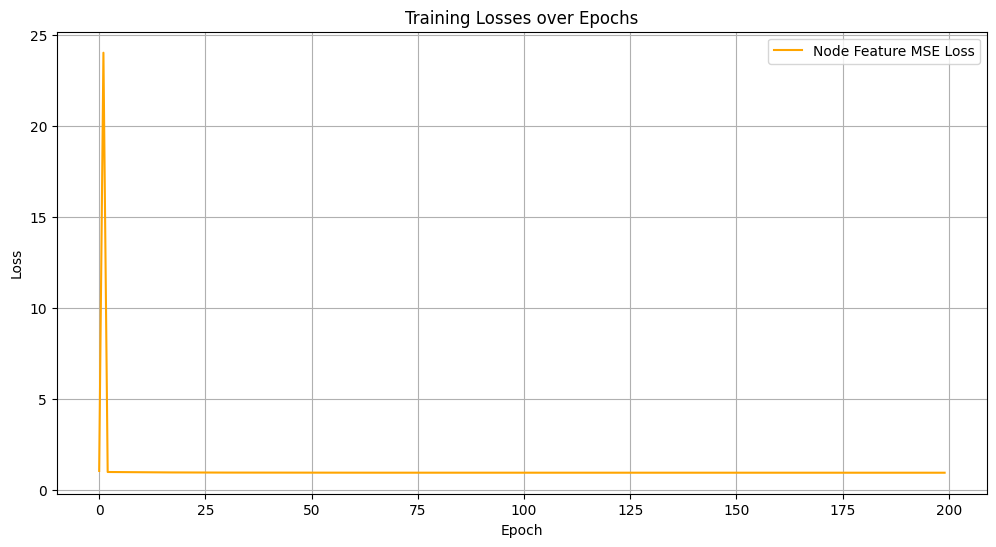

In [191]:
# Visualize the loss history
import matplotlib.pyplot as plt

# Extract losses
losses = [entry["total_loss"] for entry in loss_history]
adj_losses = [entry["adj_bce_loss"] for entry in loss_history]
x_losses = [entry["x_mse_loss"] for entry in loss_history]
kl_divs = [entry["kl_div"] for entry in loss_history]

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(x_losses, label='Node Feature MSE Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [176]:
def evaluate_vgae(model, loader, device='cpu'):
    """
    Evaluate the VGAE model on the dataset.
    
    Returns:
        all_adj_recon: List of reconstructed adjacency matrices
        all_x_recon: List of reconstructed node features
        all_adj_truth: List of ground truth adjacency matrices
        all_x: List of original node features
    """
    model.eval()
    all_adj_recon = []
    all_x_recon = []
    all_adj_truth = []
    all_x = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            batch = batch.to(device)
            adj_recon, x_recon, mu, logvar = model(batch.x, batch.edge_index, batch.edge_attr)
            
            # Ground truth adjacency matrix
            num_nodes = batch.num_nodes
            adj_truth = torch.zeros((num_nodes, num_nodes), device=device)
            adj_truth[batch.edge_index[0], batch.edge_index[1]] = 1.0
            # If undirected, mirror the adjacency
            adj_truth = adj_truth + adj_truth.t()
            adj_truth = (adj_truth > 0).float()
            
            all_adj_recon.append(adj_recon.cpu())
            all_x_recon.append(x_recon.cpu())
            all_adj_truth.append(adj_truth.cpu())
            all_x.append(batch.x.cpu())
    
    return all_adj_recon, all_x_recon, all_adj_truth, all_x


In [177]:
# Evaluate the model
all_adj_recon, all_x_recon, all_adj_truth, all_x = evaluate_vgae(model, loader, hyperparams["device"])


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


In [178]:
def compute_adj_metrics(adj_recon, adj_truth, threshold=0.5):
    """
    Compute AUC and AP scores for edge prediction.
    
    Parameters:
        adj_recon: Reconstructed adjacency matrix (torch.Tensor)
        adj_truth: Ground truth adjacency matrix (torch.Tensor)
        threshold: Threshold to binarize adjacency predictions
    
    Returns:
        auc: Area Under the ROC Curve
        ap: Average Precision
    """
    from sklearn.metrics import roc_auc_score, average_precision_score
    
    adj_recon = adj_recon.view(-1).numpy()
    adj_truth = adj_truth.view(-1).numpy()
    
    # To handle class imbalance, sample a subset of negative edges
    pos_indices = np.where(adj_truth == 1)[0]
    neg_indices = np.where(adj_truth == 0)[0]
    np.random.shuffle(neg_indices)
    neg_indices = neg_indices[:len(pos_indices)]  # Balance the classes
    
    preds = np.concatenate([adj_recon[pos_indices], adj_recon[neg_indices]])
    labels = np.concatenate([adj_truth[pos_indices], adj_truth[neg_indices]])
    
    auc = roc_auc_score(labels, preds)
    ap = average_precision_score(labels, preds)
    
    return auc, ap


In [179]:
from sklearn.metrics import roc_auc_score, average_precision_score

all_aucs = []
all_aps = []
all_maes = []
all_rmses = []

for adj_recon, adj_truth, x_recon, x in zip(all_adj_recon, all_adj_truth, all_x_recon, all_x):
    # Compute adjacency metrics
    auc, ap = compute_adj_metrics(adj_recon, adj_truth)
    all_aucs.append(auc)
    all_aps.append(ap)
    
    # Compute node feature reconstruction metrics
    x_recon_np = x_recon.numpy()
    x_np = x.numpy()
    mae = mean_absolute_error(x_np, x_recon_np)
    rmse = np.sqrt(mean_squared_error(x_np, x_recon_np))
    all_maes.append(mae)
    all_rmses.append(rmse)

# Average metrics over all graphs
avg_auc = np.mean(all_aucs)
avg_ap = np.mean(all_aps)
avg_mae = np.mean(all_maes)
avg_rmse = np.mean(all_rmses)

print(f"Average Adjacency AUC: {avg_auc:.4f}")
print(f"Average Adjacency AP: {avg_ap:.4f}")
print(f"Average Node Feature MAE: {avg_mae:.4f}")
print(f"Average Node Feature RMSE: {avg_rmse:.4f}")


Average Adjacency AUC: 0.5013
Average Adjacency AP: 0.5007
Average Node Feature MAE: 0.3843
Average Node Feature RMSE: 0.9765


/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


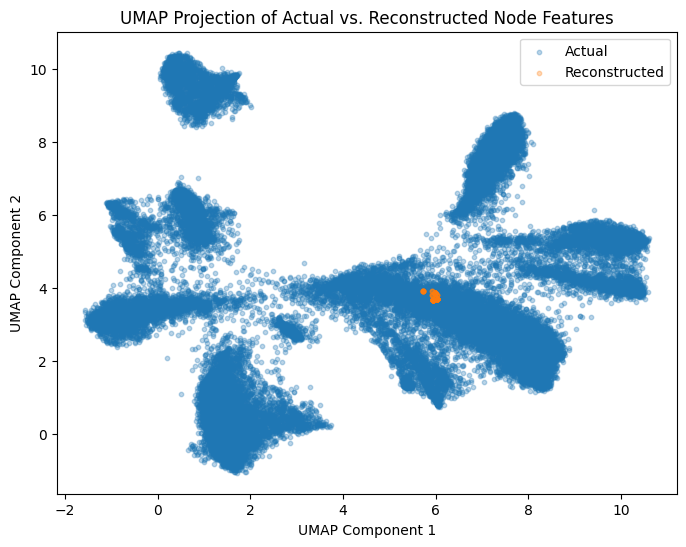

In [180]:
# Concatenate all node features and reconstructions
all_x_np = np.concatenate([x.numpy() for x in all_x], axis=0)
all_x_recon_np = np.concatenate([x_recon.numpy() for x_recon in all_x_recon], axis=0)

# PCA for initial dimensionality reduction
pca = PCA(n_components=50, random_state=42)
pca.fit(all_x_np)
x_pca = pca.transform(all_x_np)
x_recon_pca = pca.transform(all_x_recon_np)

# UMAP for 2D visualization
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
x_umap = umap_reducer.fit_transform(x_pca)
x_recon_umap = umap_reducer.transform(x_recon_pca)

# Scatter Plot: UMAP Projection
plt.figure(figsize=(8, 6))
plt.scatter(x_umap[:, 0], x_umap[:, 1], alpha=0.3, label='Actual', s=10)
plt.scatter(x_recon_umap[:, 0], x_recon_umap[:, 1], alpha=0.3, label='Reconstructed', s=10)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Actual vs. Reconstructed Node Features')
plt.legend()
plt.show()
